<a href="https://colab.research.google.com/github/DanielGreiner/Masterarbeit/blob/main/Axial_Dispersion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
#@title libraries

import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
!pip install thermo
import thermo as thermo
from scipy.optimize import minimize
!pip install rtdpy
import rtdpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 13.8 MB/s eta 0:00:00


In [ ]:
#@title cat + length

dens_cat = 0.81 #g/cm^3
d_R = 1 #cm
r_R = d_R/2 #cm
A_R = np.pi*r_R**2 #cm^2
d_P = 0.001 #m

In [ ]:
l_whole = 72

l_whole*A_R*0.93

52.59026102109314

#Impulse experiments

In [ ]:
#@title gas mixture and analyzer delay

x_H2 = 0.745
x_CO = 0.005
x_CO2 = 0.25

x_total = 1/x_H2

gas_mix_names = ['hydrogen', 'carbon monoxide', 'carbon dioxide']

BP_delay = 25 #s
analyzer_shift = 25 #s
# damping delay 2s
# response time tcd detector delay 15-30

A_P = (0.4/2)**2*np.pi
A_pipe = (0.45/2)**2*np.pi
dist_pipes1 = 1.2  # m
dist_pipes2 = 1.9  # m

A_F1 = A_R / A_P
A_F2 = A_R / A_pipe

In [ ]:
#@title bodenstein finder

def Bodenstein_finder(input):
    var, Bo = input
    #print(input)
    res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2

    return res

## Bypass Experiment 1

### data manip

In [ ]:
#@title data manip BP1

L_bed_expBP1 = 0.004
dis_P1 = 2

filepathBP1 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/RTD Rehman Greiner bypass.csv'
AxDisRawBP1 = pd.read_csv(filepathBP1, encoding='unicode_escape', sep=';')

AxDisRawBP1 = AxDisRawBP1[AxDisRawBP1['Dauer (s)'] > 2000]
AxDisRawBP1['CO (Vol%)'] = AxDisRawBP1['CO (ppm)']#.shift(-BP_delay)
#AxDisRawBP1 = AxDisRawBP1[:-BP_delay]
CutoffRawBP1 = AxDisRawBP1.index[(AxDisRawBP1['MFC CO (mln/min)'] < 10) & (AxDisRawBP1['MFC CO (mln/min)'].shift(-1) > 20)].tolist()[0] - 1
AxDisRawBP1 = AxDisRawBP1[AxDisRawBP1['Dauer (s)'] > CutoffRawBP1]
AxDisRawBP1 = AxDisRawBP1[(AxDisRawBP1['Dauer (s)'] > 10000) | (AxDisRawBP1['Dauer (s)'] < 9000)]

AxDisRawBP1['groups'] = 0
AxDisRawBP1.loc[(AxDisRawBP1['MFC CO (mln/min)'] < 10) & (AxDisRawBP1['MFC CO (mln/min)'].shift(-1) > 20), 'groups'] = 1
AxDisRawBP1['groups'] = AxDisRawBP1['groups'].cumsum()

AxDisRawBP1['CO (ppm) zeroed'] = AxDisRawBP1['CO (ppm)'].sub(AxDisRawBP1.groupby('groups')['CO (ppm)'].transform('min')*1.01)

AxDisRawBP1['RTD'] = AxDisRawBP1['CO (ppm) zeroed']/AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRawBP1['RTD2'] = AxDisRawBP1.groupby('groups')['RTD'].transform(pd.Series.cumsum)

minBP1 = AxDisRawBP1.groupby('groups')['Dauer (s)'].transform('min')
AxDisRawBP1['Dauer (s) norm'] = AxDisRawBP1['Dauer (s)'].sub(minBP1)

maxBP1 = AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
maxBP11 = AxDisRawBP1['Dauer (s) norm'].loc[maxBP1].tolist()
AxDisRawBP1['theta'] = AxDisRawBP1['Dauer (s) norm']/maxBP11

AxDisRawBP1['RTD norm'] = AxDisRawBP1['CO (ppm) zeroed']/AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].transform('sum')*maxBP11

AxDisRawBP1['Input (mlN/s)'] = AxDisRawBP1['MFC CO (mln/min)'] / 60
AxDisRawBP1['Input CO (mlN/s)'] = AxDisRawBP1['Input (mlN/s)'] * x_CO
AxDisRawBP1['Output (mlN/s)'] = AxDisRawBP1['N2-A (ln/min)'] / 60 / (1 - AxDisRawBP1['CO (ppm) zeroed'] / 100 * x_total)* 1000
AxDisRawBP1['Output CO (mlN/s)'] = AxDisRawBP1['Output (mlN/s)'] * AxDisRawBP1['CO (ppm) zeroed'] / 100

InputCOsumBP1 = AxDisRawBP1.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsumBP1 = AxDisRawBP1.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimesBP1 = AxDisRawBP1['Dauer (s) norm'].loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimesBP11 = AxDisRawBP1.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDresBP1 = pd.DataFrame(np.column_stack([ResTimesBP11, ResTimesBP1]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDresBP1['theta'] = AxDisRawBP1['theta'].loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP1['theta +1'] = AxDisRawBP1['theta'].shift(-5).loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP1['theta -1'] = AxDisRawBP1['theta'].shift(5).loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDresBP1['CO'] = AxDisRawBP1['RTD2'].loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP1['CO +1'] = AxDisRawBP1['RTD2'].shift(-5).loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP1['CO -1'] = AxDisRawBP1['RTD2'].shift(5).loc[AxDisRawBP1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDresBP1['slope_top'] = (RTDresBP1['CO'].sub(RTDresBP1['CO +1'])).div(RTDresBP1['theta'].sub(RTDresBP1['theta +1']))
RTDresBP1['slope_bottom'] = (RTDresBP1['CO -1'].sub(RTDresBP1['CO'])).div(RTDresBP1['theta -1'].sub(RTDresBP1['theta']))

RTDresBP1['Bo_top'] = (2*RTDresBP1['slope_top'])**2*np.pi
RTDresBP1['Bo_bottom'] = (2*RTDresBP1['slope_bottom'])**2*np.pi


RTDresBP1['Input total (mln/min)'] = RTDresBP1['MFC CO (mln/min)'] + 100
RTDresBP1['Fluid velocity (cm/s)'] = RTDresBP1['Input total (mln/min)'] / 60 / A_P * 423/273
RTDresBP1['Fluid velocity (m/s)'] = RTDresBP1['Fluid velocity (cm/s)']/100

RTDresBP1['Calc. Residence Time (s)'] = dis_P1 / RTDresBP1['Fluid velocity (m/s)']

# CO_1 = (RTDresBP1['MFC CO (mln/min)'] * x_CO) / (RTDresBP1['Input total (mln/min)'] + RTDresBP1['MFC CO (mln/min)'])
# CO_1 = (RTDresBP1['MFC CO (mln/min)'] * x_CO) / (RTDresBP1['Input total (mln/min)'] + RTDresBP1['MFC CO (mln/min)'])
# CO2_1 = (RTDresBP1['MFC CO (mln/min)'] * x_CO2) / (RTDresBP1['Input total (mln/min)'] + RTDresBP1['MFC CO (mln/min)'])

# IZ1 = np.array([CO_1, CO_1, CO2_1])
# gas_prop1 = thermo.Mixture(gas_mix_names, zs=IZ1, T=450, P=1E5)
# nug1 = gas_prop1.nug
# RTDresBP1['Re'] = RTDresBP1['Fluid velocity (m/s)'] * L_bed_exp1 / nug1

RTDresBP1['D_ax_top [10^-5 m2/s]'] = L_bed_expBP1 * RTDresBP1['Fluid velocity (m/s)'] / RTDresBP1['Bo_top'] * 10 ** 5
RTDresBP1['D_ax_bottom [10^-5 m2/s]'] = L_bed_expBP1 * RTDresBP1['Fluid velocity (m/s)'] / RTDresBP1['Bo_bottom'] * 10 ** 5

RTDresBP1['Re'] = 0


for i in range(len(RTDresBP1)):

    H2 = (RTDresBP1['MFC CO (mln/min)'].iat[i] * x_H2) / RTDresBP1['Input total (mln/min)'].iat[i]
    CO = (RTDresBP1['MFC CO (mln/min)'].iat[i] * x_CO) / RTDresBP1['Input total (mln/min)'].iat[i]
    CO2 = (RTDresBP1['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDresBP1['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDresBP1['Re'].iat[i] = L_bed_expBP1*RTDresBP1['Fluid velocity (m/s)'].iat[i]*rhog/mug

RTDresBP1pretty = RTDresBP1[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]
                         #, 'Var', 'Bo by Var']]
#RTDresBP1pretty = RTDresBP1pretty.drop(RTDresBP1pretty.index[[8]])

print('Input ml/min :' + str(InputCOsumBP1))
print('Output ml/min : ' + str(OutputCOsumBP1))

AxDisRawBP1['E*t'] = AxDisRawBP1['RTD']*AxDisRawBP1['Dauer (s) norm']
AxDisRawBP1['E*t^2*dt'] = AxDisRawBP1['RTD']*AxDisRawBP1['Dauer (s) norm']**2*1
normvar_1 = np.zeros(len(RTDresBP1pretty['Residence Time (s)']))
mom1_1 = AxDisRawBP1.groupby('groups')['E*t'].sum()
mom2_1 = AxDisRawBP1.groupby('groups')['E*t^2*dt'].sum()
var2_1 = mom2_1 - mom1_1**2
var1_1 = np.sqrt(var2_1)
for i in range (len(RTDresBP1pretty['Residence Time (s)'])):
    normvar_1[i] = var1_1[i+1]**2/(RTDresBP1pretty['Residence Time (s)'].iat[i]**2)
#normvar_1

Input ml/min :[0.02112, 0.01496, 0.03, 0.03095, 0.03747]
Output ml/min : [78.21968, 13.27433, -9.30317, 185.64454, -2.77724]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#@title find bodenstein for BP 1

values_1 = np.zeros(len(normvar_1))

for i in range (len(normvar_1)):
    var_1 = normvar_1 [i]
    initial_guess_1 = [var_1, 1]
    bnds1 = [(var_1, var_1), (0, 150)]

    res_min_1 = minimize(Bodenstein_finder, initial_guess_1, bounds=bnds1)

    values_1[i] = res_min_1.x[1]
#values_1

<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDresBP1pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)  \
0             59.35                 159.35                32.0   
1             59.37                 159.37                32.0   
2             98.79                 198.79                30.0   
3             98.77                 198.77                30.0   
4            122.52                 222.52                30.0   

   Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
0              0.327468                  6.107470  19.723611  21.555899   
1              0.327509                  6.106703  26.745636  32.813015   
2              0.408518                  4.895746  33.214363  34.507037   
3              0.408477                  4.896238  32.820265  36.088559   
4              0.457284                  4.373653  30.806937  36.836201   

   D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]         Re  
0               6.641134                  6.076626  21.731878  
1               4.898129                  3.992427  21.734606  
2               4.919775                  4.735474  27.110637  
3               4.978349                  4.527494  27.107910  
4               5.937411                  4.965590  30.346894

###plots BP1

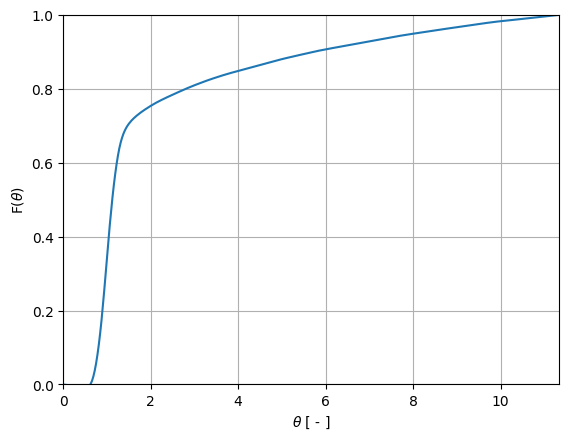

In [ ]:
#@title plot first group

# plt.plot(AxDisRawBP1['Dauer (s)'][AxDisRawBP1['groups'] == 1], AxDisRawBP1['MFC CO (mln/min)'][AxDisRawBP1['groups'] == 1], label = 'CO (mln/min)')
# plt.plot(AxDisRawBP1['Dauer (s)'][AxDisRawBP1['groups'] == 1], AxDisRawBP1['CO (ppm) zeroed'][AxDisRawBP1['groups'] == 1], label = 'CO (ppm)')

#plt.plot(AxDisRawBP1['theta'][AxDisRawBP1['groups'] == 1], AxDisRawBP1['MFC CO (mln/min)'][AxDisRawBP1['groups'] == 1], label = 'CO (mln/min)')
plt.plot(AxDisRawBP1['theta'][AxDisRawBP1['groups'] == 1], AxDisRawBP1['RTD2'][AxDisRawBP1['groups'] == 1], label = 'RTD')

# plt.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['MFC CO (mln/min)'], label = 'CO (mln/min)')
# plt.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['CO (ppm)'], label = 'CO (ppm)')

#plt.plot(AxDisRawBP1['Dauer (s)'][AxDisRawBP1['groups'] == 1], AxDisRawBP1['groups'][AxDisRawBP1['groups'] == 1])
plt.xlim(left = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == 1].iat[0], right = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

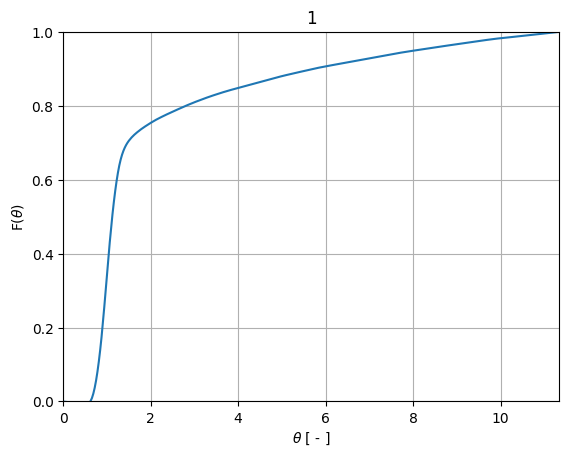

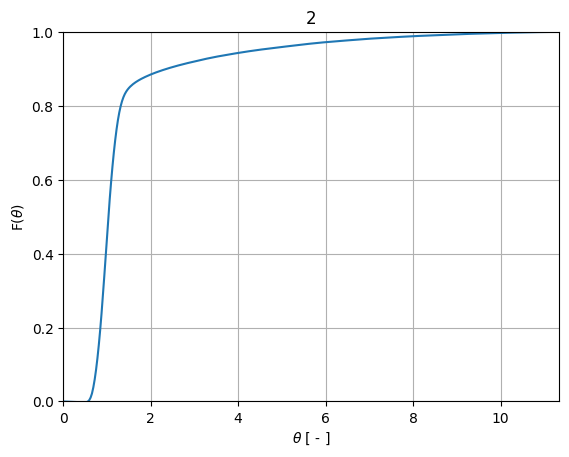

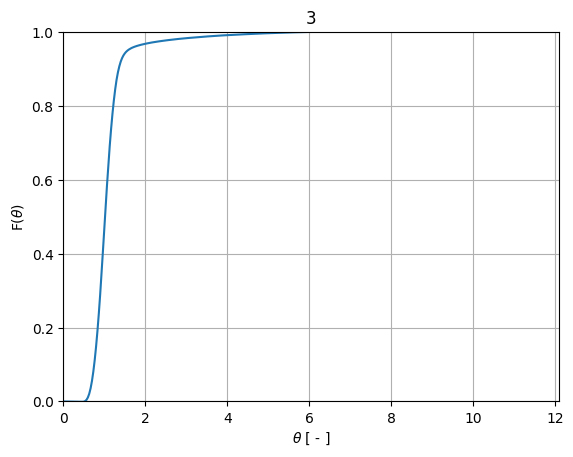

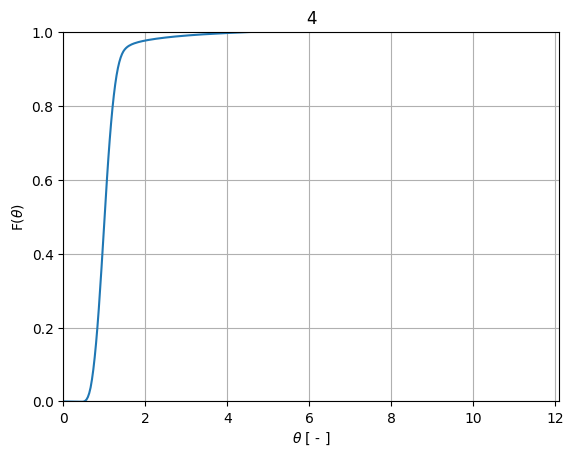

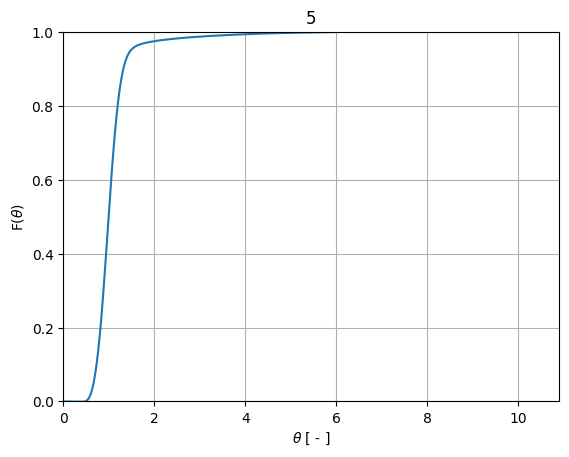

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRawBP1['groups'].iat[-1] + 1):
    # if i == 8:
    #     continue
    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRawBP1['Dauer (s)'][AxDisRawBP1['groups'] == i], AxDisRawBP1['MFC CO (mln/min)'][AxDisRawBP1['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i], AxDisRawBP1['RTD2'][AxDisRawBP1['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i].iat[0], right = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

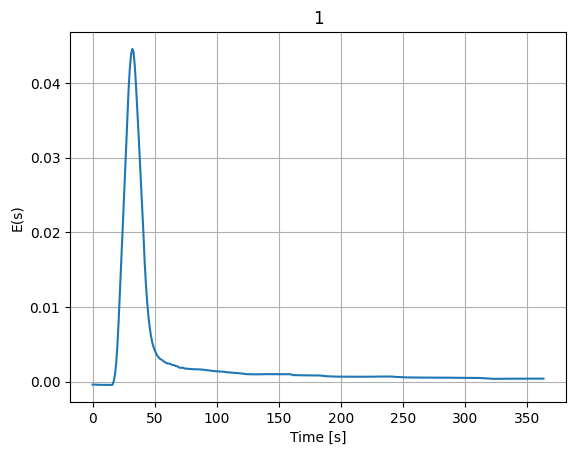

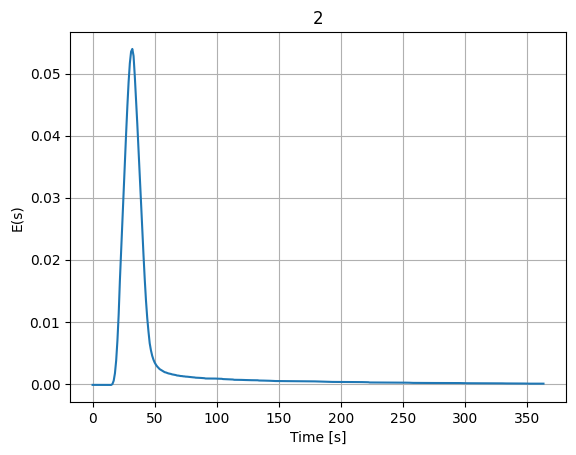

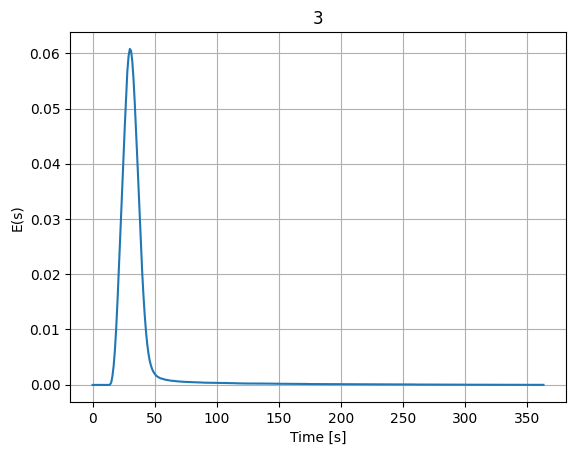

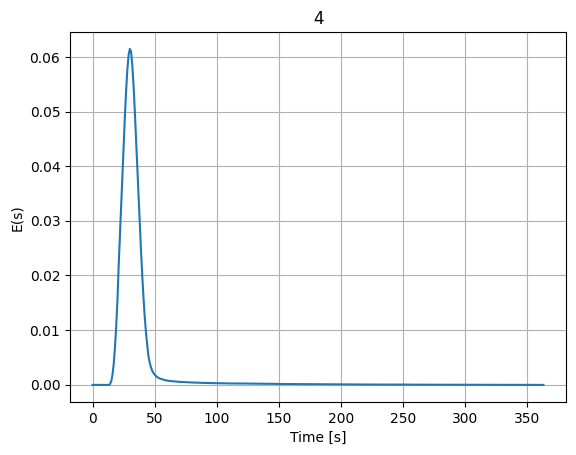

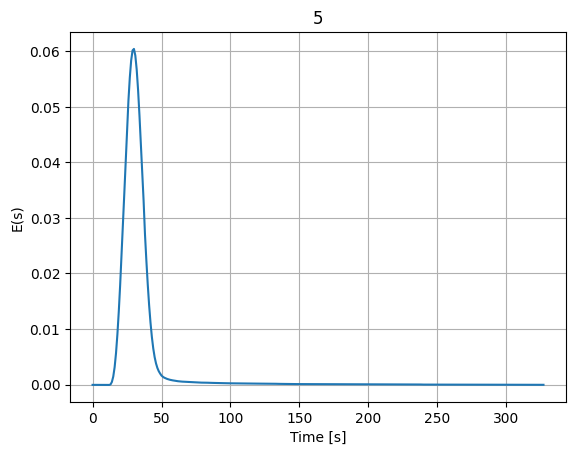

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRawBP1['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRawBP1['Dauer (s)'][AxDisRawBP1['groups'] == i], AxDisRawBP1['MFC CO (mln/min)'][AxDisRawBP1['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i], AxDisRawBP1['RTD'][AxDisRawBP1['groups'] == i], label = 'RTD')
    plt.plot(AxDisRawBP1['Dauer (s) norm'][AxDisRawBP1['groups'] == i], AxDisRawBP1['RTD'][AxDisRawBP1['groups'] == i], label = 'RTD')

    #plt.xlim(left = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i].iat[0], right = AxDisRawBP1['theta'][AxDisRawBP1['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

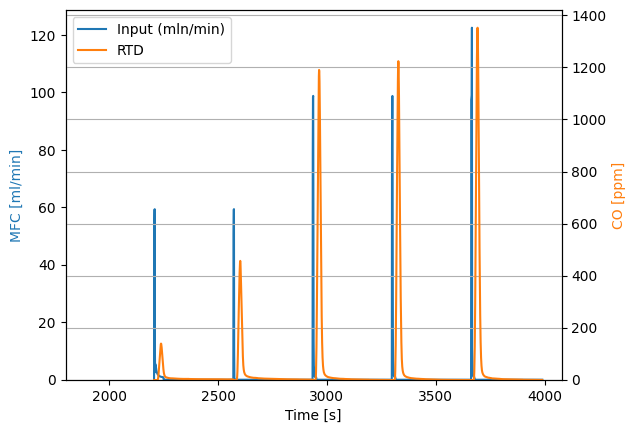

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['MFC CO (mln/min)'], 'tab:blue', label = 'Input (mln/min)')
ax2.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['CO (ppm) zeroed'], 'tab:orange', label = 'RTD')

#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 1800)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MFC [ml/min]', color = 'tab:blue')
ax2.set_ylabel('CO [ppm]', color ='tab:orange')

plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

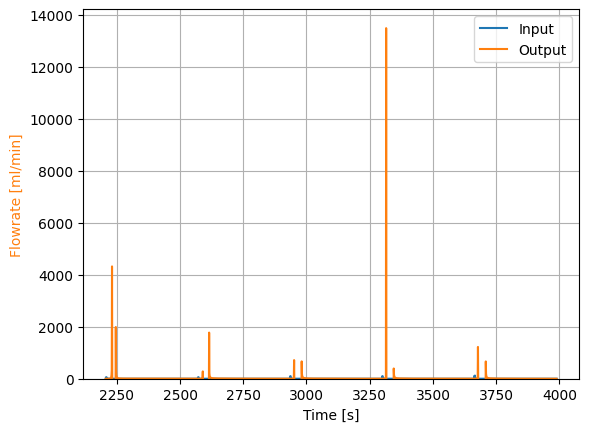

In [ ]:
#@title full hydrogen plot

plt.figure()

plt.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
plt.plot(AxDisRawBP1['Dauer (s)'], AxDisRawBP1['Output CO (mlN/s)']*60, 'tab:orange', label = 'Output')

plt.ylabel('Flowrate [ml/min]', color ='tab:orange')
plt.xlabel('Time [s]')

plt.ylim(bottom = 0)
plt.legend(loc = 'best')
plt.grid()

## Bypass Experiment 2

### data manip

In [ ]:
#@title data manip BP2

L_bed_expBP2 = 0.004
dis_P2 = 2

filepathBP2 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/RTD Rehman Greiner bypass 2.csv'
AxDisRawBP2 = pd.read_csv(filepathBP2, encoding='unicode_escape', sep=';')

AxDisRawBP2['CO (ppm)'] = AxDisRawBP2['CO (ppm)']#.shift(-BP_delay)
#AxDisRawBP2 = AxDisRawBP2[:-BP_delay]
CutoffRawBP2 = AxDisRawBP2.index[(AxDisRawBP2['MFC CO (mln/min)'] < 10) & (AxDisRawBP2['MFC CO (mln/min)'].shift(-1) > 20)].tolist()[0] - 1
AxDisRawBP2 = AxDisRawBP2[AxDisRawBP2['Dauer (s)'] > CutoffRawBP2]
AxDisRawBP2 = AxDisRawBP2[(AxDisRawBP2['Dauer (s)'] > 10000) | (AxDisRawBP2['Dauer (s)'] < 9000)]

AxDisRawBP2['groups'] = 0
AxDisRawBP2.loc[(AxDisRawBP2['MFC CO (mln/min)'] < 10) & (AxDisRawBP2['MFC CO (mln/min)'].shift(-1) > 20), 'groups'] = 1
AxDisRawBP2['groups'] = AxDisRawBP2['groups'].cumsum()

AxDisRawBP2['CO (ppm) zeroed'] = AxDisRawBP2['CO (ppm)'].sub(AxDisRawBP2.groupby('groups')['CO (ppm)'].transform('min')*1.01)
AxDisRawBP2['CO (ppm) zeroed'] = AxDisRawBP2['CO (ppm)'].sub(AxDisRawBP2.groupby('groups')['CO (ppm)'].transform('min')*1.01)

AxDisRawBP2['RTD'] = AxDisRawBP2['CO (ppm) zeroed']/AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRawBP2['RTD2'] = AxDisRawBP2.groupby('groups')['RTD'].transform(pd.Series.cumsum)

AxDisRawBP2['RTD CO'] = AxDisRawBP2['CO (ppm) zeroed']/AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRawBP2['RTD2 CO'] = AxDisRawBP2.groupby('groups')['RTD'].transform(pd.Series.cumsum)

minBP2 = AxDisRawBP2.groupby('groups')['Dauer (s)'].transform('min')
AxDisRawBP2['Dauer (s) norm'] = AxDisRawBP2['Dauer (s)'].sub(minBP2)

maxBP2 = AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
maxBP21 = AxDisRawBP2['Dauer (s) norm'].loc[maxBP2].tolist()
AxDisRawBP2['theta'] = AxDisRawBP2['Dauer (s) norm']/maxBP21

AxDisRawBP2['RTD norm'] = AxDisRawBP2['CO (ppm) zeroed']/AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].transform('sum')*maxBP21

AxDisRawBP2['Input (mlN/s)'] = AxDisRawBP2['MFC CO (mln/min)'] / 60
AxDisRawBP2['Input CO (mlN/s)'] = AxDisRawBP2['Input (mlN/s)'] * x_CO
AxDisRawBP2['Output (mlN/s)'] = AxDisRawBP2['N2-A (ln/min)'] / 60 / (1 - AxDisRawBP2['CO (ppm) zeroed'] / 100 * x_total)* 1000
AxDisRawBP2['Output CO (mlN/s)'] = AxDisRawBP2['Output (mlN/s)'] * AxDisRawBP2['CO (ppm) zeroed'] / 100

InputCOsumBP2 = AxDisRawBP2.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsumBP2 = AxDisRawBP2.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimesBP2 = AxDisRawBP2['Dauer (s) norm'].loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimesBP21 = AxDisRawBP2.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDresBP2 = pd.DataFrame(np.column_stack([ResTimesBP21, ResTimesBP2]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDresBP2['theta'] = AxDisRawBP2['theta'].loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP2['theta +1'] = AxDisRawBP2['theta'].shift(-5).loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP2['theta -1'] = AxDisRawBP2['theta'].shift(5).loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDresBP2['CO'] = AxDisRawBP2['RTD2'].loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP2['CO +1'] = AxDisRawBP2['RTD2'].shift(-5).loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDresBP2['CO -1'] = AxDisRawBP2['RTD2'].shift(5).loc[AxDisRawBP2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDresBP2['slope_top'] = (RTDresBP2['CO'].sub(RTDresBP2['CO +1'])).div(RTDresBP2['theta'].sub(RTDresBP2['theta +1']))
RTDresBP2['slope_bottom'] = (RTDresBP2['CO -1'].sub(RTDresBP2['CO'])).div(RTDresBP2['theta -1'].sub(RTDresBP2['theta']))

RTDresBP2['Bo_top'] = (2*RTDresBP2['slope_top'])**2*np.pi
RTDresBP2['Bo_bottom'] = (2*RTDresBP2['slope_bottom'])**2*np.pi

RTDresBP2['Input total (mln/min)'] = RTDresBP2['MFC CO (mln/min)'] + 100
RTDresBP2['Fluid velocity (cm/s)'] = RTDresBP2['Input total (mln/min)'] / 60 / A_P * 423/273
RTDresBP2['Fluid velocity (m/s)'] = RTDresBP2['Fluid velocity (cm/s)']/100

RTDresBP2['Calc. Residence Time (s)'] = dis_P2 / RTDresBP2['Fluid velocity (m/s)']

# CO_1 = (RTDresBP2['MFC CO (mln/min)'] * x_CO) / (RTDresBP2['Input total (mln/min)'] + RTDresBP2['MFC CO (mln/min)'])
# CO_1 = (RTDresBP2['MFC CO (mln/min)'] * x_CO) / (RTDresBP2['Input total (mln/min)'] + RTDresBP2['MFC CO (mln/min)'])
# CO2_1 = (RTDresBP2['MFC CO (mln/min)'] * x_CO2) / (RTDresBP2['Input total (mln/min)'] + RTDresBP2['MFC CO (mln/min)'])

# IZ1 = np.array([CO_1, CO_1, CO2_1])
# gas_prop1 = thermo.Mixture(gas_mix_names, zs=IZ1, T=450, P=1E5)
# nug1 = gas_prop1.nug
# RTDresBP2['Re'] = RTDresBP2['Fluid velocity (m/s)'] * L_bed_exp1 / nug1

RTDresBP2['D_ax_top [10^-5 m2/s]'] = L_bed_expBP2 * RTDresBP2['Fluid velocity (m/s)'] / RTDresBP2['Bo_top'] * 10 ** 5
RTDresBP2['D_ax_bottom [10^-5 m2/s]'] = L_bed_expBP2 * RTDresBP2['Fluid velocity (m/s)'] / RTDresBP2['Bo_bottom'] * 10 ** 5

RTDresBP2['Re'] = 0


for i in range(len(RTDresBP2)):

    H2 = (RTDresBP2['MFC CO (mln/min)'].iat[i] * x_H2) / RTDresBP2['Input total (mln/min)'].iat[i]
    CO = (RTDresBP2['MFC CO (mln/min)'].iat[i] * x_CO) / RTDresBP2['Input total (mln/min)'].iat[i]
    CO2 = (RTDresBP2['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDresBP2['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDresBP2['Re'].iat[i] = L_bed_expBP2*RTDresBP2['Fluid velocity (m/s)'].iat[i]*rhog/mug

RTDresBP2pretty = RTDresBP2[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]
                         #, 'Var', 'Bo by Var']]
#RTDresBP2pretty = RTDresBP2pretty.drop(RTDresBP2pretty.index[[8]])

print('Input ml/min :' + str(InputCOsumBP2))
print('Output ml/min : ' + str(OutputCOsumBP2))

AxDisRawBP2['E*t'] = AxDisRawBP2['RTD']*AxDisRawBP2['Dauer (s) norm']
AxDisRawBP2['E*t^2*dt'] = AxDisRawBP2['RTD']*AxDisRawBP2['Dauer (s) norm']**2*1
normvar_1 = np.zeros(len(RTDresBP2pretty['Residence Time (s)']))
mom1_1 = AxDisRawBP2.groupby('groups')['E*t'].sum()
mom2_1 = AxDisRawBP2.groupby('groups')['E*t^2*dt'].sum()
var2_1 = mom2_1 - mom1_1**2
var1_1 = np.sqrt(var2_1)
for i in range (len(RTDresBP2pretty['Residence Time (s)'])):
    normvar_1[i] = var1_1[i+1]**2/(RTDresBP2pretty['Residence Time (s)'].iat[i]**2)
#normvar_1

Input ml/min :[0.02091, 0.01494, 0.0216, 0.03106, 0.03034, 0.03073]
Output ml/min : [67.67079, -60.65678, 10.07456, -34.09427, -37.36961, -65.56769]


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
#@title find bodenstein for BP 2

values_1 = np.zeros(len(normvar_1))

for i in range (len(normvar_1)):
    var_1 = normvar_1 [i]
    initial_guess_1 = [var_1, 1]
    bnds1 = [(var_1, var_1), (0, 150)]

    res_min_1 = minimize(Bodenstein_finder, initial_guess_1, bounds=bnds1)

    values_1[i] = res_min_1.x[1]
#values_1

<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDresBP2pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)  \
0             59.61                 159.61                32.0   
1             59.37                 159.37                31.0   
2             59.52                 159.52                31.0   
3             98.90                 198.90                30.0   
4             98.81                 198.81                30.0   
5             98.81                 198.81                30.0   

   Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
0              0.328002                  6.097521  24.204085  31.391955   
1              0.327509                  6.106703  32.235972  33.792497   
2              0.327817                  6.100961  31.983010  35.626723   
3              0.408744                  4.893038  32.260285  36.626902   
4              0.408559                  4.895253  32.650179  36.118129   
5              0.408559                  4.895253  31.887191  35.890506   

   D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]         Re  
0               5.420608                  4.179442  21.767336  
1               4.063894                  3.876706  21.734606  
2               4.099892                  3.680577  21.755062  
3               5.068077                  4.463866  27.125639  
4               5.005290                  4.524698  27.113365  
5               5.125055                  4.553394  27.113365

###plots BP2

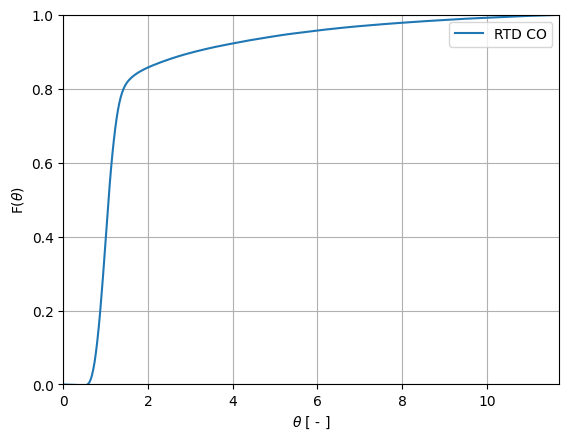

In [ ]:
#@title plot first group

# plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == 1], AxDisRawBP2['MFC CO (mln/min)'][AxDisRawBP2['groups'] == 1], label = 'CO (mln/min)')
# plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == 1], AxDisRawBP2['CO (ppm) zeroed'][AxDisRawBP2['groups'] == 1], label = 'CO (ppm)')

#plt.plot(AxDisRawBP2['theta'][AxDisRawBP2['groups'] == 1], AxDisRawBP2['MFC CO (mln/min)'][AxDisRawBP2['groups'] == 1], label = 'CO (mln/min)')
plt.plot(AxDisRawBP2['theta'][AxDisRawBP2['groups'] == 2], AxDisRawBP2['RTD2'][AxDisRawBP2['groups'] == 1], label = 'RTD CO')

# plt.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['MFC CO (mln/min)'], label = 'CO (mln/min)')
# plt.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['CO (ppm)'], label = 'CO (ppm)')

#plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == 1], AxDisRawBP2['groups'][AxDisRawBP2['groups'] == 1])
plt.xlim(left = AxDisRawBP2['theta'][AxDisRawBP2['groups'] == 2].iat[0], right = AxDisRawBP2['theta'][AxDisRawBP2['groups'] == 2].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.legend(loc='best')
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

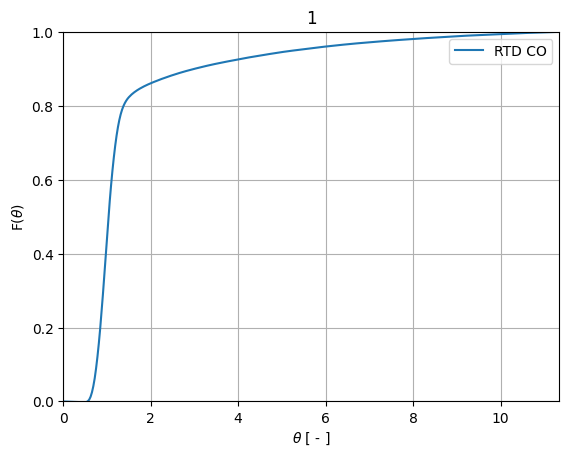

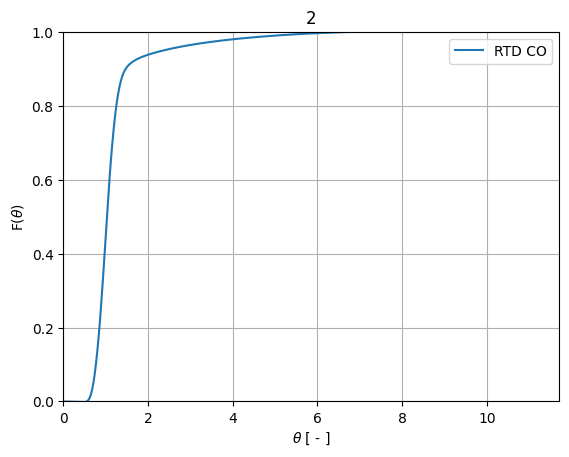

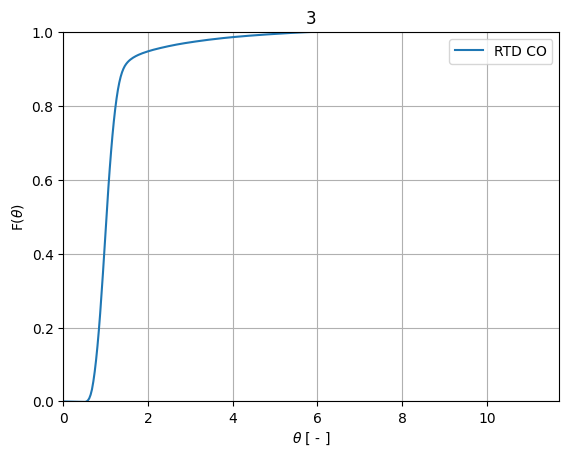

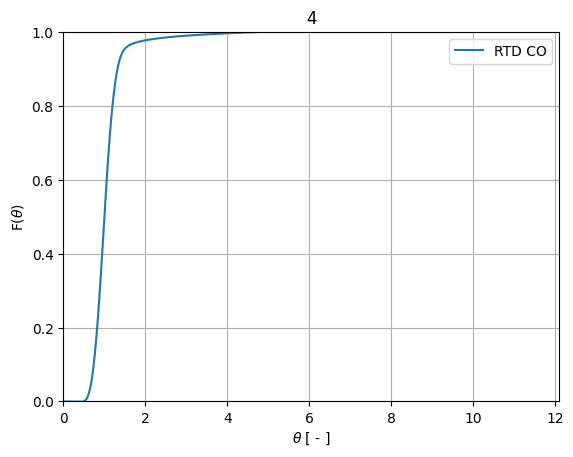

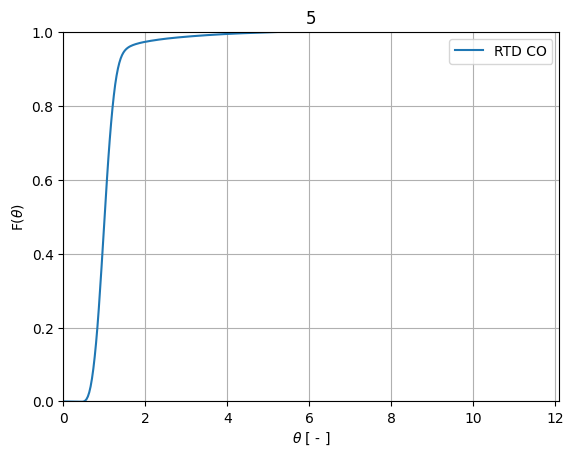

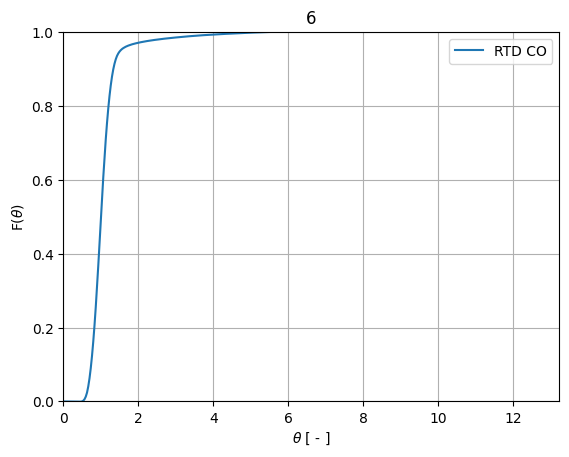

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRawBP2['groups'].iat[-1] + 1):
    # if i == 8:
    #     continue
    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == i], AxDisRawBP2['MFC CO (mln/min)'][AxDisRawBP2['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRawBP2['theta'][AxDisRawBP2['groups'] == i], AxDisRawBP2['RTD2'][AxDisRawBP2['groups'] == i], label = 'RTD CO')

    plt.xlim(left = AxDisRawBP2['theta'][AxDisRawBP2['groups'] == i].iat[0], right = AxDisRawBP2['theta'][AxDisRawBP2['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.legend(loc='best')
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

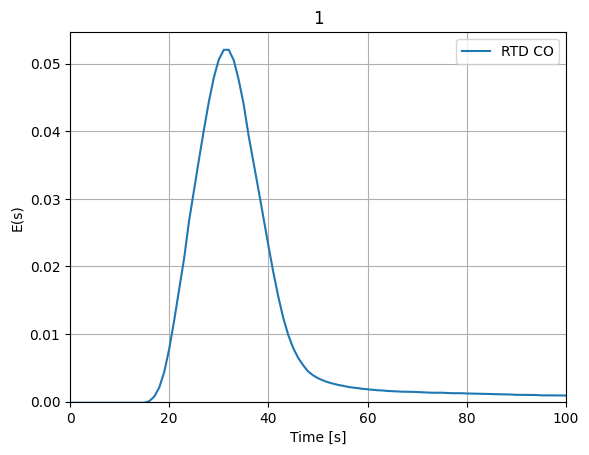

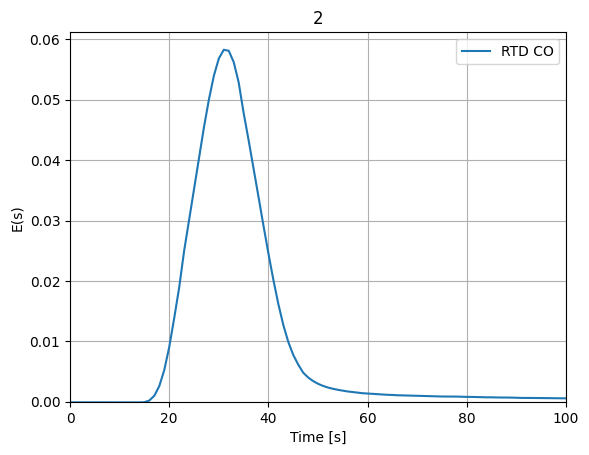

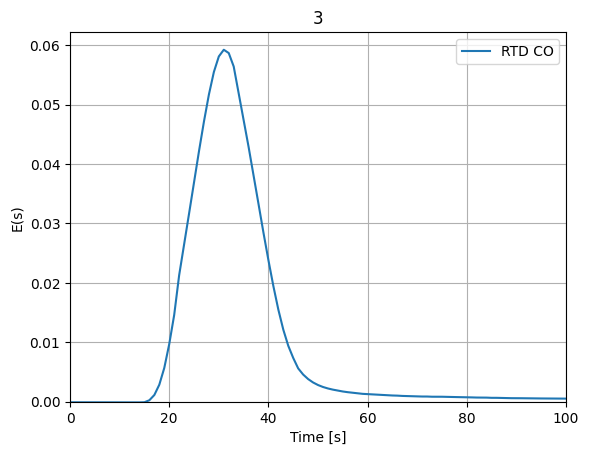

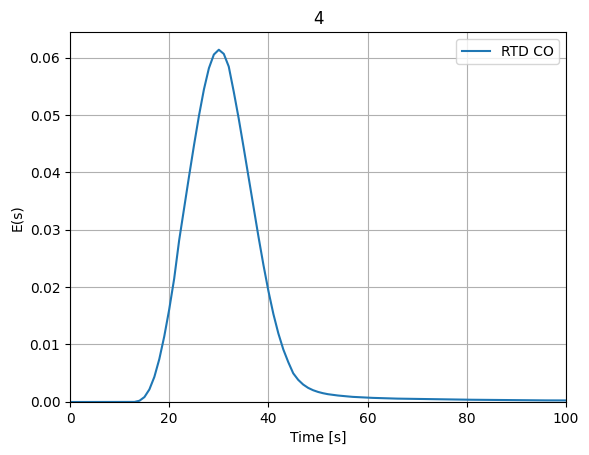

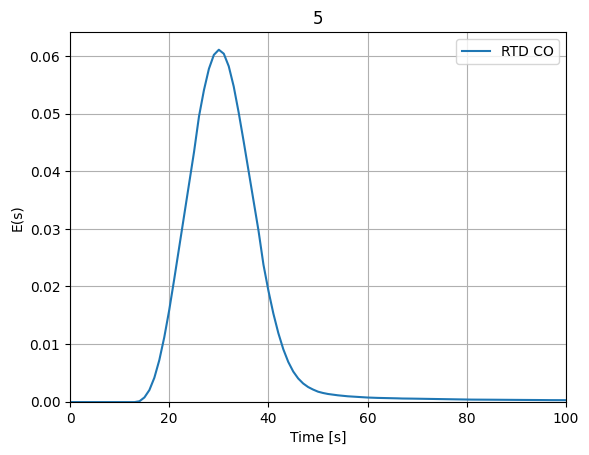

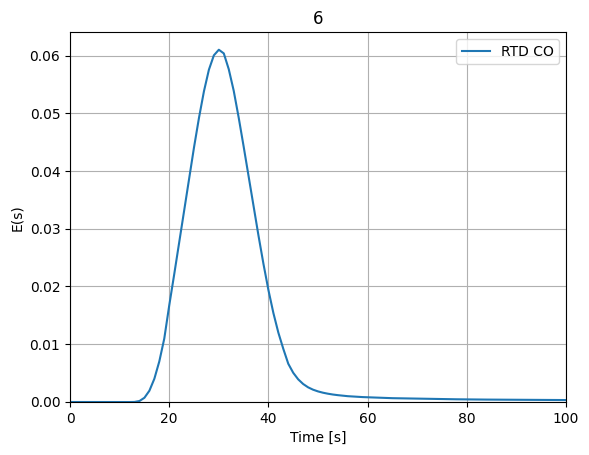

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRawBP2['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == i], AxDisRawBP2['MFC CO (mln/min)'][AxDisRawBP2['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRawBP2['theta'][AxDisRawBP2['groups'] == i], AxDisRawBP2['RTD'][AxDisRawBP2['groups'] == i], label = 'RTD')
    plt.plot(AxDisRawBP2['Dauer (s) norm'][AxDisRawBP2['groups'] == i], AxDisRawBP2['RTD'][AxDisRawBP2['groups'] == i], label = 'RTD CO')

    plt.xlim(left = AxDisRawBP2['Dauer (s) norm'][AxDisRawBP2['groups'] == i].iat[0], right = 100)
    plt.ylim(bottom = 0)
    plt.legend(loc='best')
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

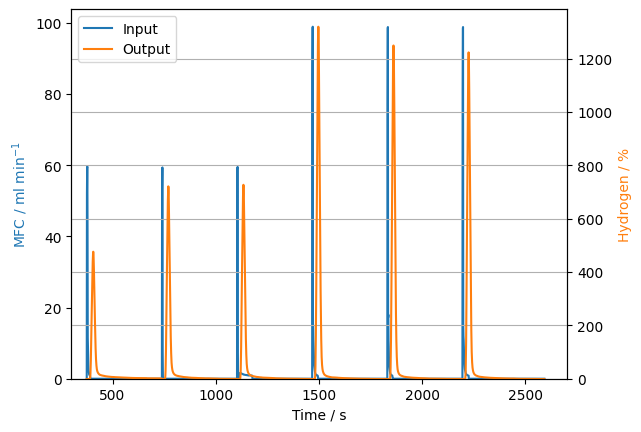

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
ax2.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['CO (ppm) zeroed'], 'tab:orange', label = 'Output')

#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 300)
ax1.set_xlabel('Time / s')
ax1.set_ylabel('MFC / ml min$^{-1}$', color = 'tab:blue')
ax2.set_ylabel('Hydrogen / %', color ='tab:orange')

plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

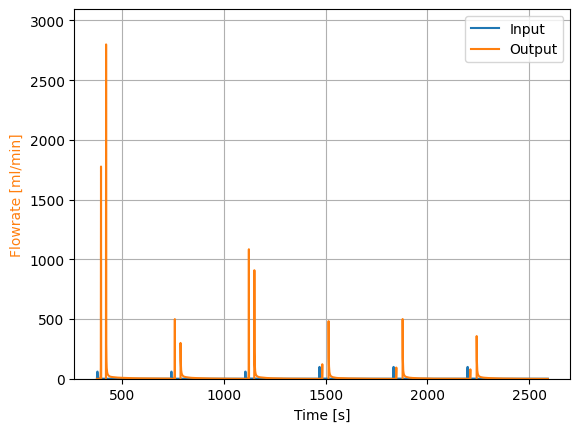

In [ ]:
#@title full hydrogen plot

plt.figure()

plt.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
plt.plot(AxDisRawBP2['Dauer (s)'], AxDisRawBP2['Output CO (mlN/s)']*60, 'tab:orange', label = 'Output')

plt.ylabel('Flowrate [ml/min]', color ='tab:orange')
plt.xlabel('Time [s]')

plt.ylim(bottom = 0)
plt.legend(loc = 'best')
plt.grid()

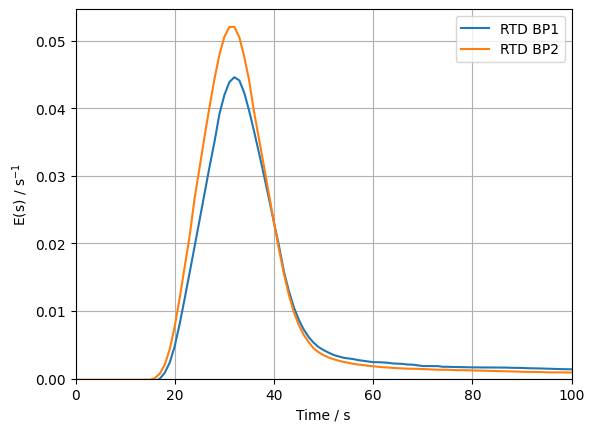

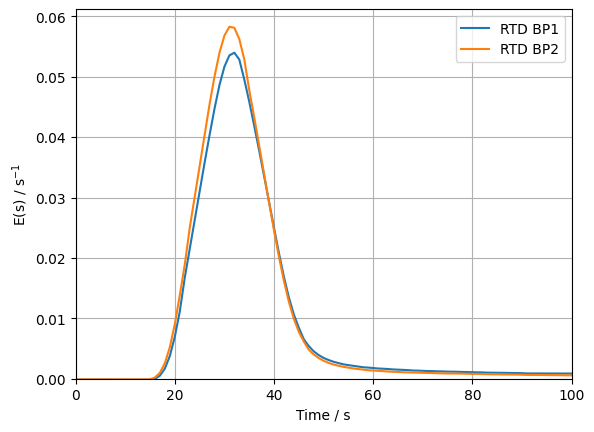

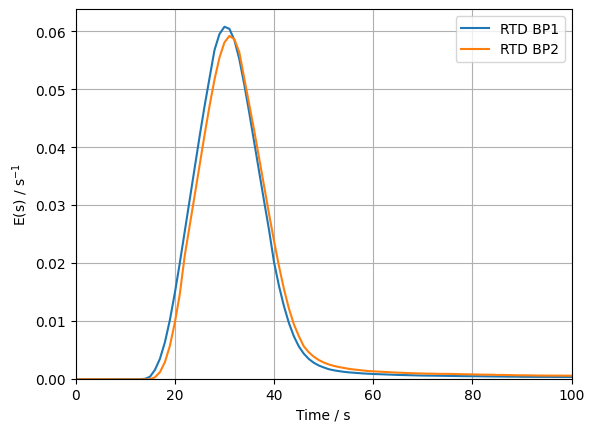

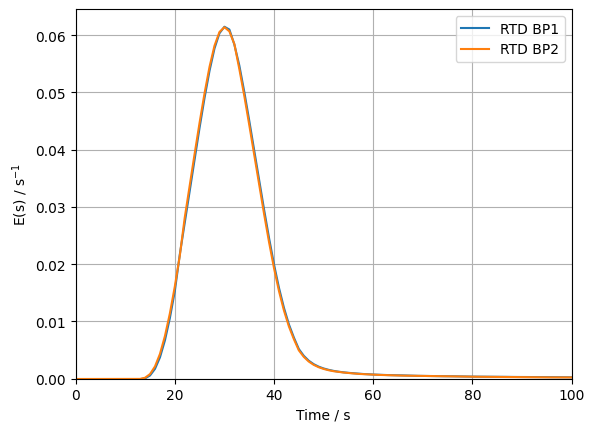

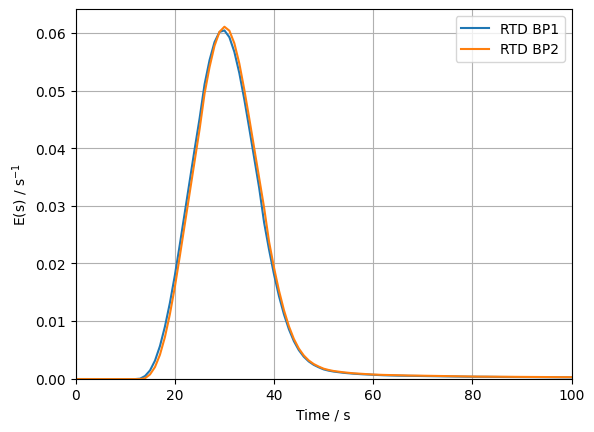

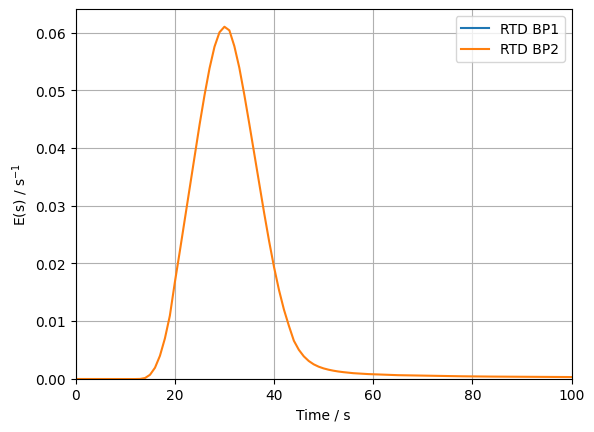

In [ ]:
#@title plot all groups seperately Vol%, both bypasses

for i in range (1, AxDisRawBP2['groups'].iat[-1] + 1):

    plt.figure(i)
    #plt.title(i)
    #plt.plot(AxDisRawBP2['Dauer (s)'][AxDisRawBP2['groups'] == i], AxDisRawBP2['MFC CO (mln/min)'][AxDisRawBP2['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRawBP2['theta'][AxDisRawBP2['groups'] == i], AxDisRawBP2['RTD'][AxDisRawBP2['groups'] == i], label = 'RTD')
    plt.plot(AxDisRawBP1['Dauer (s) norm'][AxDisRawBP1['groups'] == i], AxDisRawBP1['RTD'][AxDisRawBP1['groups'] == i], label = 'RTD BP1')
    plt.plot(AxDisRawBP2['Dauer (s) norm'][AxDisRawBP2['groups'] == i], AxDisRawBP2['RTD'][AxDisRawBP2['groups'] == i], label = 'RTD BP2')

    plt.xlim(left = AxDisRawBP2['Dauer (s) norm'][AxDisRawBP2['groups'] == i].iat[0], right = 100)#, right = AxDisRawBP2['Dauer (s) norm'][AxDisRawBP2['groups'] == i].iat[-1])
    plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time / s")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s) / s$^{-1}$')
    plt.legend(loc="best")
    plt.grid()

## Combination of Models (CoM) for bypass

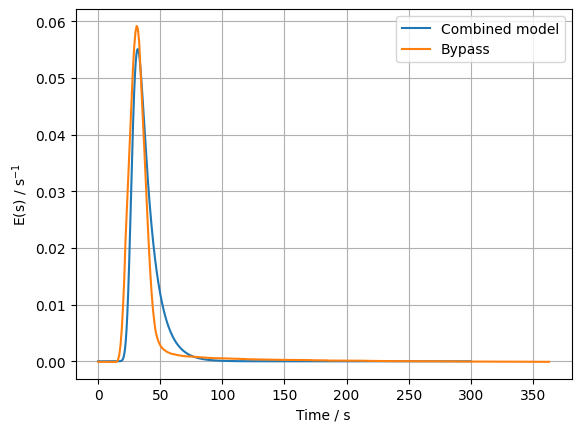

In [ ]:
#@title test for CoM proof of concept

delta_t_CoM = 0.1
time_end_CoM = 300
group_comp_CoM = 3
peclet_pipe_CoM = 50
delay_pipe_CoM = 3


a = rtdpy.AD_cc(tau=BP_delay, peclet=100, dt=delta_t_CoM, time_end=time_end_CoM)
b = rtdpy.AD_cc(tau=delay_pipe_CoM, peclet=peclet_pipe_CoM, dt=delta_t_CoM, time_end=time_end_CoM)
#c = rtdpy.AD_cc(tau=30, peclet=peclet_pipe_CoM, dt=delta_t_CoM, time_end=time_end_CoM)
d = rtdpy.Ncstr(tau=10, n=1, dt=delta_t_CoM, time_end=time_end_CoM)

#CoM = rtdpy.Elist([a, b, c, d])

CoM = rtdpy.Elist([a, b, d])

plt.figure()
plt.plot(CoM.time, (CoM.exitage), label ='Combined model')
plt.plot(AxDisRawBP2[AxDisRawBP2['groups'] == group_comp_CoM]['Dauer (s) norm'], AxDisRawBP2[AxDisRawBP2['groups'] == group_comp_CoM]['RTD'], label = 'Bypass')
plt.xlabel('Time / s')
plt.ylabel('E(s) / s$^{-1}$')
#plt.title('Combination of models')
plt.legend(loc = 'best')
plt.grid()
plt.show()

In [ ]:
#@title combined model coefficient functions

def CoM_coeff_finder (CoM_Coeff, groups_int, df, df2):

    delay_pipe_CoM_test, tau_analyser_CoM, peclet_pipe_CoM = CoM_Coeff

    rtd_delta = df[df['groups'] == groups_int]['Dauer (s) norm'].iat[1] - df[df['groups'] == groups_int]['Dauer (s) norm'].iat[0]
    rtd_max = df[df['groups'] == groups_int]['Dauer (s) norm'].max() + rtd_delta/2

    b_CoM = rtdpy.AD_cc(tau=delay_pipe_CoM_test, peclet=peclet_pipe_CoM, dt=rtd_delta, time_end=rtd_max)
    c_CoM = rtdpy.Ncstr(tau=tau_analyser_CoM, n=1, dt=rtd_delta, time_end=rtd_max)

    CoM_func = rtdpy.Elist([b_CoM, c_CoM])

    if len(CoM_func.exitage) - len(df[df['groups'] == groups_int]['RTD']) == 0:
        QS = (((CoM_func.exitage - df[df['groups'] == groups_int]['RTD'])*100)**2).sum()
    else:
        QS = 0

    return QS

def CoM_coeff (df, df2):

    values_pec = np.zeros((3, df['groups'].iat[-1]))

    for i in range (1, df['groups'].iat[-1]+1):
        # tau pipe 1, tau analyser, peclet pipe
        initial_guess_CoM = np.array([28, 10, 50])
        bnds_CoM = [(0.000005, 100), (0.000005, 100), (0.000005, 100)]

        res = minimize(CoM_coeff_finder, args=(i, df, df2), x0 = initial_guess_CoM, bounds=bnds_CoM, method='powell', options = {'maxiter': 10})

        for j in range(3):
            values_pec[j, i-1] = round(res.x[j], 3)

    return values_pec

In [ ]:
#@title CoM value finder

CoM_values_BP2 = CoM_coeff(AxDisRawBP2, RTDresBP2pretty)
CoM_values_BP2

array([[26.524, 27.294, 27.179, 26.554, 26.663, 26.522],
       [ 9.276,  7.059,  6.832,  5.907,  5.947,  6.024],
       [63.817, 58.796, 57.684, 50.252, 50.688, 50.157]])

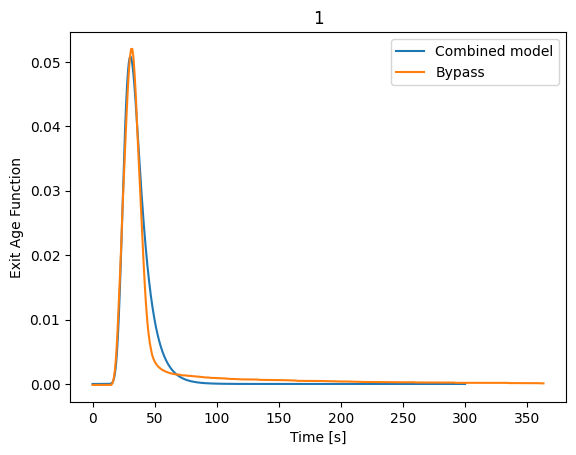

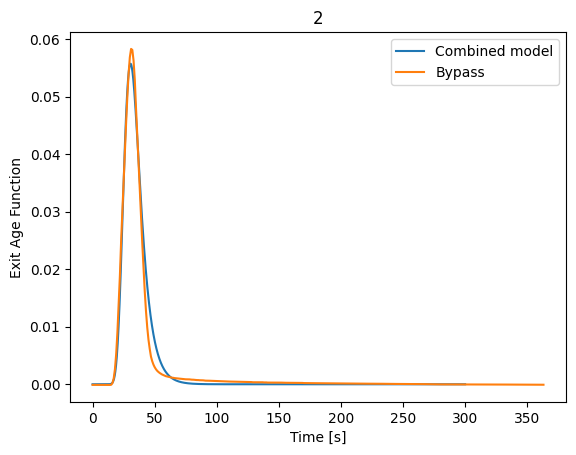

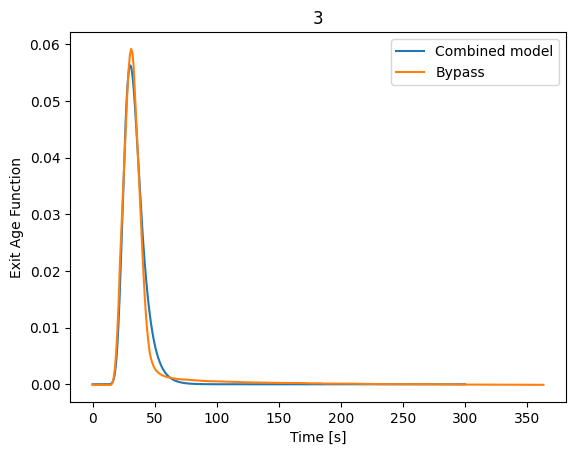

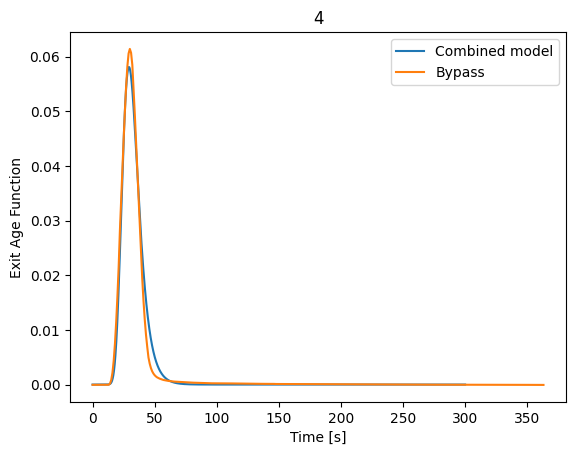

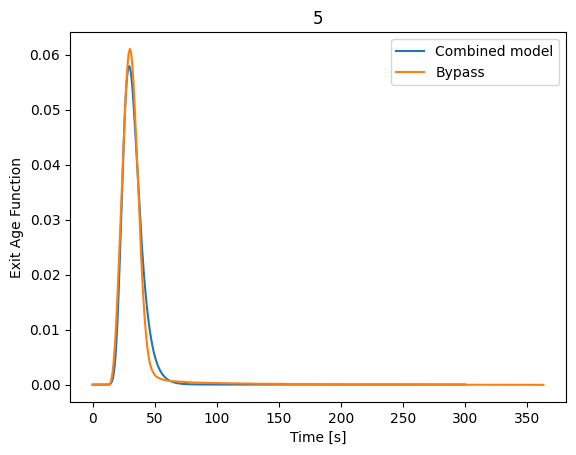

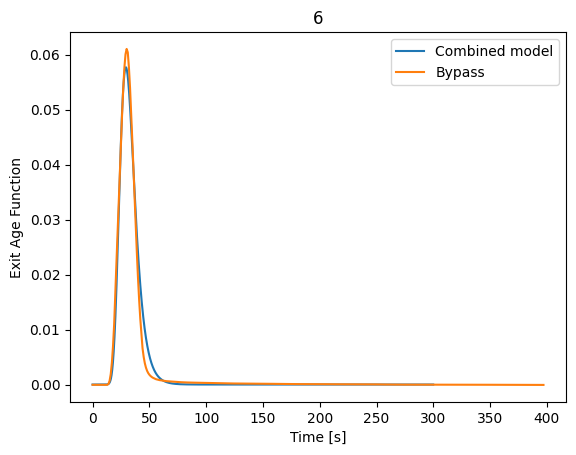

In [ ]:
#@title plotter for CoM

delta_t_CoM = 0.1
time_end_CoM = 300

for i in range (1, AxDisRawBP2['groups'].iat[-1] + 1):

    a_plot = rtdpy.AD_cc(tau=CoM_values_BP2[0, i-1], peclet=CoM_values_BP2[2, i-1], dt=delta_t_CoM, time_end=time_end_CoM)
    b_plot = rtdpy.Ncstr(tau=CoM_values_BP2[1, i-1], n=1, dt=delta_t_CoM, time_end=time_end_CoM)

    CoM_plot = rtdpy.Elist([a_plot, b_plot])

    plt.figure()
    plt.title(i)
    # , label=f"peclet = {Peclet}"
    plt.plot(CoM_plot.time, (CoM_plot.exitage),label ='Combined model')
    plt.plot(AxDisRawBP2[AxDisRawBP2['groups'] == i]['Dauer (s) norm'], AxDisRawBP2[AxDisRawBP2['groups'] == i]['RTD'], label = 'Bypass')
    plt.xlabel('Time [s]')
    plt.ylabel('Exit Age Function')
    plt.legend(loc = 'best')
    plt.show()

## Experiment 1

### data manip

In [ ]:
#@title data manip exp1

m_cat_exp1 = 5.0066 #g
L_bed_exp1 = m_cat_exp1/dens_cat/A_R/100

filepath1 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/RTD Rehman Greiner exp1.csv'
AxDisRaw1 = pd.read_csv(filepath1, encoding='unicode_escape', sep=';')

AxDisRaw1 = AxDisRaw1[AxDisRaw1['Dauer (s)'] > 5000]
AxDisRaw1['CO (ppm)'] = AxDisRaw1['CO (ppm)'].shift(-analyzer_shift)
AxDisRaw1 = AxDisRaw1[:-analyzer_shift]
CutoffRaw1 = AxDisRaw1.index[(AxDisRaw1['MFC CO (mln/min)'] < 10) & (AxDisRaw1['MFC CO (mln/min)'].shift(-1) > 20)].tolist()[0] - 1
AxDisRaw1 = AxDisRaw1[AxDisRaw1['Dauer (s)'] > CutoffRaw1]
AxDisRaw1 = AxDisRaw1[(AxDisRaw1['Dauer (s)'] > 10000) | (AxDisRaw1['Dauer (s)'] < 9000)]

AxDisRaw1['groups'] = 0
AxDisRaw1.loc[(AxDisRaw1['MFC CO (mln/min)'] < 10) & (AxDisRaw1['MFC CO (mln/min)'].shift(-1) > 20), 'groups'] = 1
AxDisRaw1['groups'] = AxDisRaw1['groups'].cumsum()

AxDisRaw1['CO (ppm) zeroed'] = AxDisRaw1['CO (ppm)'].sub(AxDisRaw1.groupby('groups')['CO (ppm)'].transform('min'))

AxDisRaw1['RTD'] = AxDisRaw1['CO (ppm) zeroed']/AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRaw1['RTD2'] = AxDisRaw1.groupby('groups')['RTD'].transform(pd.Series.cumsum)

AxDisRaw1['CO (ppm) zeroed'] = AxDisRaw1['CO (ppm)'].sub(AxDisRaw1.groupby('groups')['CO (ppm)'].transform('min'))

AxDisRaw1['RTD CO'] = AxDisRaw1['CO (ppm) zeroed']/AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRaw1['RTD2 CO'] = AxDisRaw1.groupby('groups')['RTD CO'].transform(pd.Series.cumsum)

min1 = AxDisRaw1.groupby('groups')['Dauer (s)'].transform('min')
AxDisRaw1['Dauer (s) norm'] = AxDisRaw1['Dauer (s)'].sub(min1)

max1 = AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
max11 = AxDisRaw1['Dauer (s) norm'].loc[max1].tolist()
AxDisRaw1['theta'] = AxDisRaw1['Dauer (s) norm']/max11

max1CO = AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
max11CO = AxDisRaw1['Dauer (s) norm'].loc[max1CO].tolist()
AxDisRaw1['theta CO'] = AxDisRaw1['Dauer (s) norm']/max11CO

AxDisRaw1['RTD norm'] = AxDisRaw1['CO (ppm) zeroed']/AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('sum')*max11

AxDisRaw1['RTD norm CO'] = AxDisRaw1['CO (ppm) zeroed']/AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].transform('sum')*max11CO

AxDisRaw1['Input (mlN/s)'] = AxDisRaw1['MFC CO (mln/min)'] / 60
AxDisRaw1['Input CO (mlN/s)'] = AxDisRaw1['Input (mlN/s)'] * x_CO
AxDisRaw1['Output (mlN/s)'] = AxDisRaw1['N2-A (ln/min)'] / 60 / (1 - AxDisRaw1['CO (ppm) zeroed'] / 100 * x_total)* 1000
AxDisRaw1['Output CO (mlN/s)'] = AxDisRaw1['Output (mlN/s)'] * AxDisRaw1['CO (ppm) zeroed'] / 100

InputCOsum1 = AxDisRaw1.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsum1 = AxDisRaw1.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimes1 = AxDisRaw1['Dauer (s) norm'].loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimes11 = AxDisRaw1.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDres1 = pd.DataFrame(np.column_stack([ResTimes11, ResTimes1]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDres1['theta'] = AxDisRaw1['theta'].loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres1['theta +1'] = AxDisRaw1['theta'].shift(-5).loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres1['theta -1'] = AxDisRaw1['theta'].shift(5).loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres1['CO'] = AxDisRaw1['RTD2'].loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres1['CO +1'] = AxDisRaw1['RTD2'].shift(-5).loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres1['CO -1'] = AxDisRaw1['RTD2'].shift(5).loc[AxDisRaw1.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres1['slope_top'] = (RTDres1['CO'].sub(RTDres1['CO +1'])).div(RTDres1['theta'].sub(RTDres1['theta +1']))
RTDres1['slope_bottom'] = (RTDres1['CO -1'].sub(RTDres1['CO'])).div(RTDres1['theta -1'].sub(RTDres1['theta']))

RTDres1['Bo_top'] = (2*RTDres1['slope_top'])**2*np.pi
RTDres1['Bo_bottom'] = (2*RTDres1['slope_bottom'])**2*np.pi


RTDres1['Input total (mln/min)'] = RTDres1['MFC CO (mln/min)'] + 100
RTDres1['Fluid velocity (cm/s)'] = RTDres1['Input total (mln/min)'] / 60 / A_R * 423/273
RTDres1['Fluid velocity (m/s)'] = RTDres1['Fluid velocity (cm/s)']/100
RTDres1['Calc. Residence Time (s)'] = L_bed_exp1 / (1/0.4 * RTDres1['Fluid velocity (m/s)']) + (0.7 - L_bed_exp1) / RTDres1['Fluid velocity (m/s)'] +  273/423 * dist_pipes1 / (A_F1 * RTDres1['Fluid velocity (m/s)']) + dist_pipes2 / (A_F2 * RTDres1['Fluid velocity (m/s)'])

RTDres1['D_ax_top [10^-5 m2/s]'] = d_P * RTDres1['Fluid velocity (m/s)'] / RTDres1['Bo_top'] * 10 ** 5
RTDres1['D_ax_bottom [10^-5 m2/s]'] = d_P * RTDres1['Fluid velocity (m/s)'] / RTDres1['Bo_bottom'] * 10 ** 5

RTDres1['Re'] = 0


for i in range(len(RTDres1)):

    H2 = (RTDres1['MFC CO (mln/min)'].iat[i] * x_H2) / RTDres1['Input total (mln/min)'].iat[i]
    CO = (RTDres1['MFC CO (mln/min)'].iat[i] * x_CO) / RTDres1['Input total (mln/min)'].iat[i]
    CO2 = (RTDres1['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDres1['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDres1['Re'].iat[i] = d_P*RTDres1['Fluid velocity (m/s)'].iat[i]*rhog/mug/0.6

RTDres1pretty = RTDres1[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


                         #, 'Var', 'Bo by Var']]
#RTDres1pretty = RTDres1pretty.drop(RTDres1pretty.index[[8]])

print('Input ml/min :' + str(InputCOsum1))
print('Output ml/min : ' + str(OutputCOsum1))

AxDisRaw1['E*t*dt'] = AxDisRaw1['RTD']*AxDisRaw1['Dauer (s) norm']
AxDisRaw1['E*t^2*dt'] = AxDisRaw1['RTD']*AxDisRaw1['Dauer (s) norm']**2*1

normvar_1 = np.zeros(len(RTDres1pretty['Residence Time (s)']))
mom1_1 = AxDisRaw1.groupby('groups')['E*t*dt'].sum()
mom2_1 = AxDisRaw1.groupby('groups')['E*t^2*dt'].sum()
var2_1 = mom2_1 - mom1_1**2
var1_1 = np.sqrt(var2_1)
for i in range (len(RTDres1pretty['Residence Time (s)'])):
    normvar_1[i] = var1_1[i+1]**2/(RTDres1pretty['Residence Time (s)'].iat[i]**2)
#normvar_1
RTDres1['1. Mom.'] = mom1_1
RTDres1pretty = RTDres1[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', '1. Mom.', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]

# print('1. Moment: ' + str(round(mom1_1, 1)) + ' s')
# print('2. Moment: ' + str(round(mom2_1, 1)) + ' s')

Input ml/min :[0.00825, 0.0082, 0.00649, 0.01291, 0.01255, 0.01303, 0.02412, 0.0244, 0.03892, 0.04445, 0.04226, 0.04486]
Output ml/min : [390.59773, -197.84898, -160.15834, 11.98306, -1747.83907, -2625.79271, -39.29419, 358.65546, 225.99591, -15.9609, -2849.7622, 16.44213]


In [ ]:
#@title find bodenstein for exp 1

values_1 = np.zeros(len(normvar_1))

for i in range (len(normvar_1)):
    var_1 = normvar_1 [i]
    initial_guess_1 = [var_1, 1]
    bnds1 = [(var_1, var_1), (0, 150)]

    res_min_1 = minimize(Bodenstein_finder, initial_guess_1, bounds=bnds1)

    values_1[i] = res_min_1.x[1]
#values_1

<ipython-input-5-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-5-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDres1pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)     1. Mom.  \
0              25.20                 125.20                83.0         NaN   
1              24.81                 124.81                81.0  178.481110   
2              25.18                 125.18                82.0  151.679385   
3              49.57                 149.57                79.0  146.346505   
4              49.46                 149.46                79.0  140.672038   
5              49.57                 149.57                79.0  130.100416   
6              98.68                 198.68                77.0  141.442829   
7              98.92                 198.92                77.0  121.366638   
8              99.14                 199.14                76.0  360.399330   
9             142.80                 242.80                75.0   99.487680   
10            142.23                 242.23                75.0   97.281958   
11            142.67                 242.67                75.0   97.371657   

    Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
0               0.041166                 28.213565  27.264474  29.901444   
1               0.041038                 28.301725  39.401168  43.773442   
2               0.041160                 28.218073  40.472849  44.710779   
3               0.049179                 23.616623  48.603814  49.905689   
4               0.049143                 23.634005  53.278724  55.985239   
5               0.049179                 23.616623  49.975413  51.229661   
6               0.065327                 17.779033  60.279543  62.375275   
7               0.065406                 17.757583  46.010666  49.936308   
8               0.065478                 17.737965  66.342663  67.239604   
9               0.079834                 14.548346  78.815048  77.112325   
10              0.079646                 14.582580  78.153800  77.560802   
11              0.079791                 14.556139  75.669669  76.843844   

    D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]        Re  
0                0.150988                  0.137673  1.138304  
1                0.104154                  0.093751  1.134758  
2                0.101697                  0.092058  1.138122  
3                0.101184                  0.098544  1.359873  
4                0.092238                  0.087778  1.358873  
5                0.098407                  0.095997  1.359873  
6                0.108373                  0.104732  1.806376  
7                0.142153                  0.130978  1.808558  
8                0.098697                  0.097380  1.810558  
9                0.101292                  0.103529  2.207510  
10               0.101909                  0.102689  2.202327  
11               0.105446                  0.103835  2.206328

###plots exp1

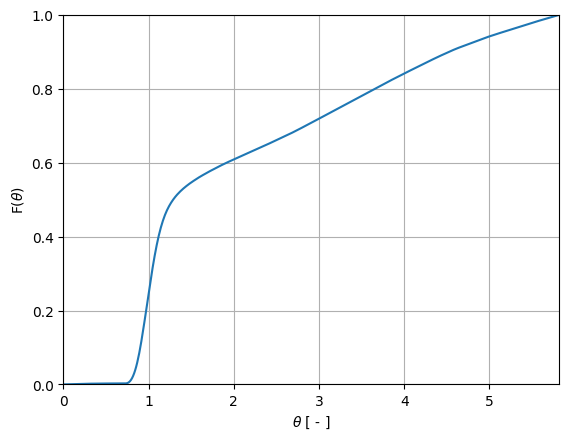

In [ ]:
#@title plot first group

# plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == 1], AxDisRaw1['MFC CO (mln/min)'][AxDisRaw1['groups'] == 1], label = 'CO (mln/min)')
# plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == 1], AxDisRaw1['CO (ppm) zeroed'][AxDisRaw1['groups'] == 1], label = 'CO (ppm)')

#plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == 1], AxDisRaw1['MFC CO (mln/min)'][AxDisRaw1['groups'] == 1], label = 'CO (mln/min)')
plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == 1], AxDisRaw1['RTD2'][AxDisRaw1['groups'] == 1], label = 'RTD')

# plt.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['MFC CO (mln/min)'], label = 'CO (mln/min)')
# plt.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['CO (ppm)'], label = 'CO (ppm)')

#plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == 1], AxDisRaw1['groups'][AxDisRaw1['groups'] == 1])
plt.xlim(left = AxDisRaw1['theta'][AxDisRaw1['groups'] == 1].iat[0], right = AxDisRaw1['theta'][AxDisRaw1['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

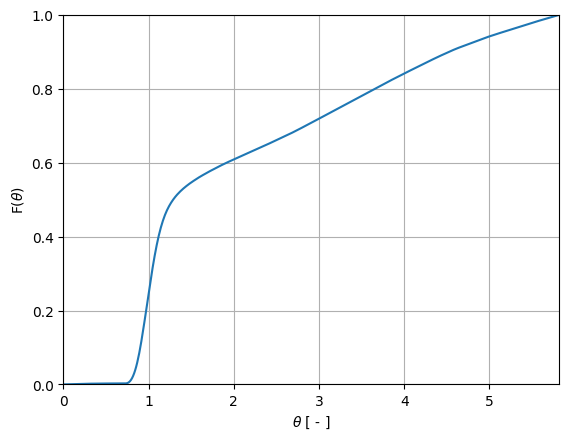

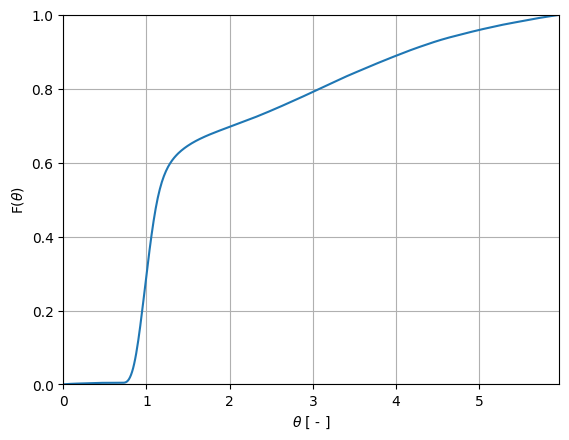

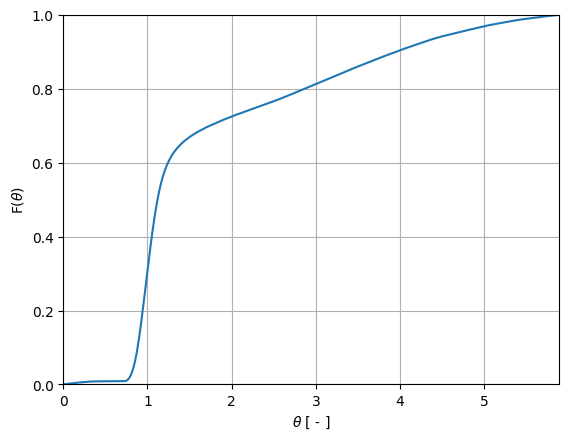

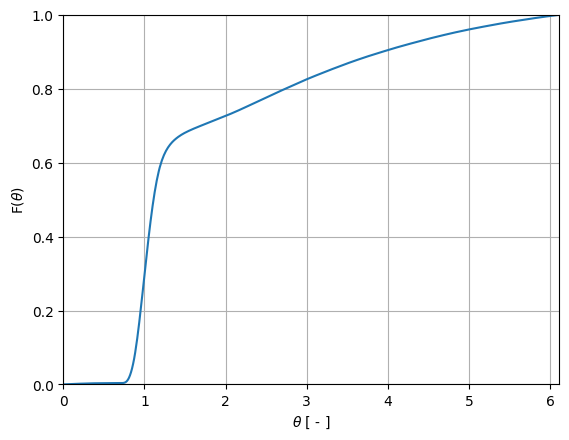

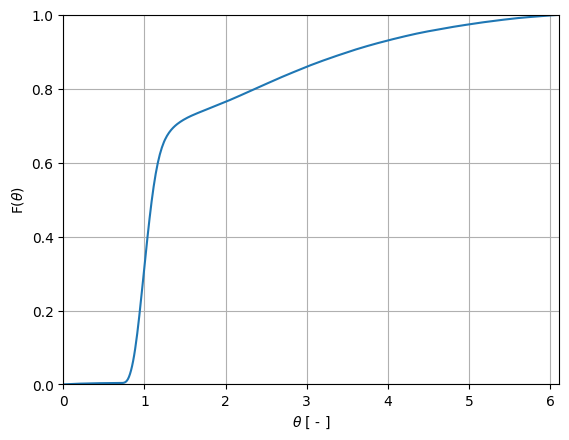

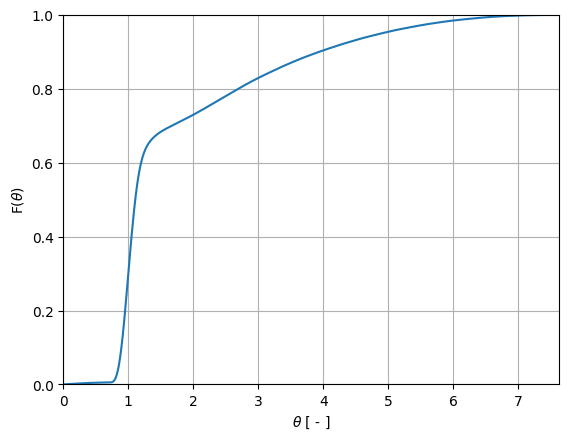

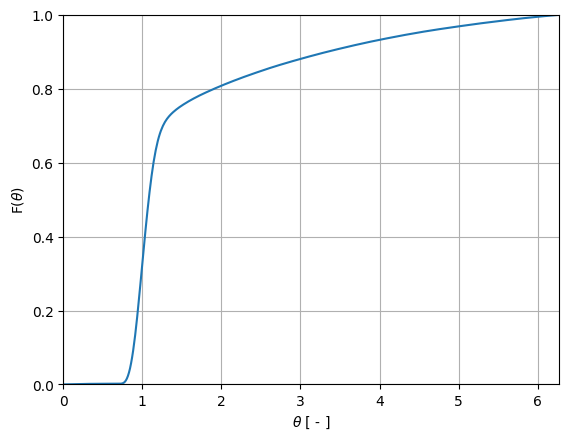

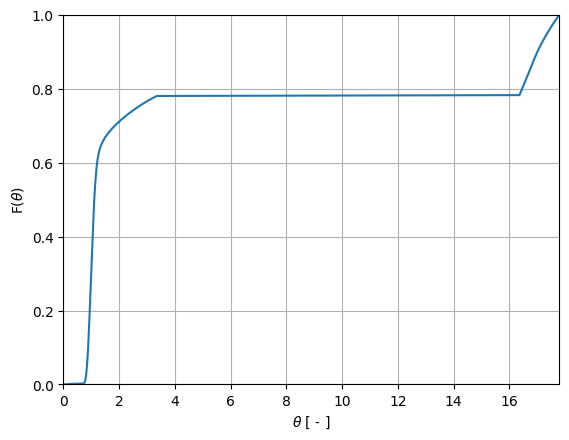

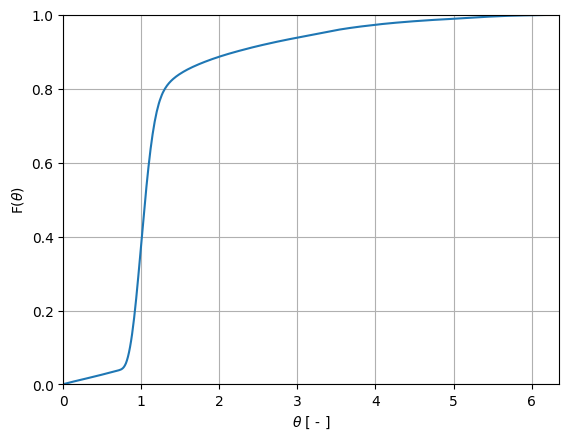

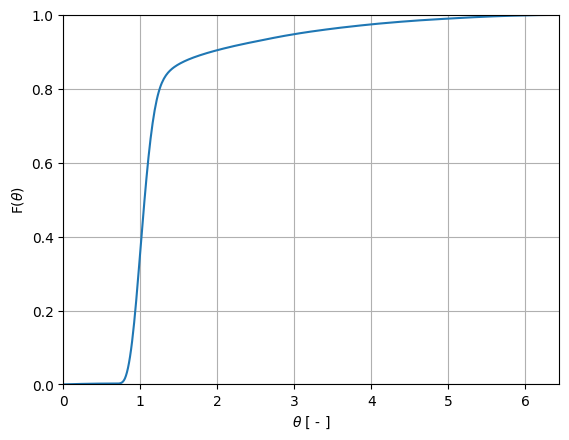

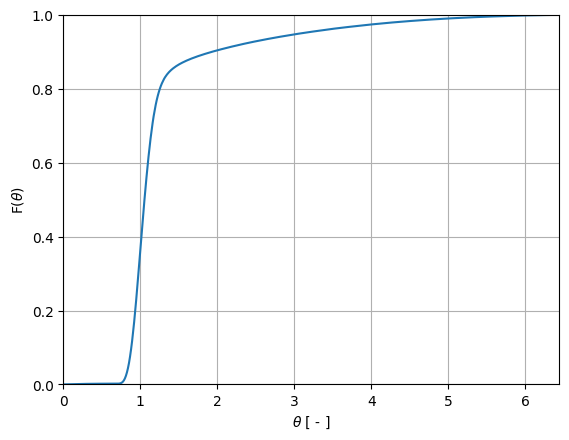

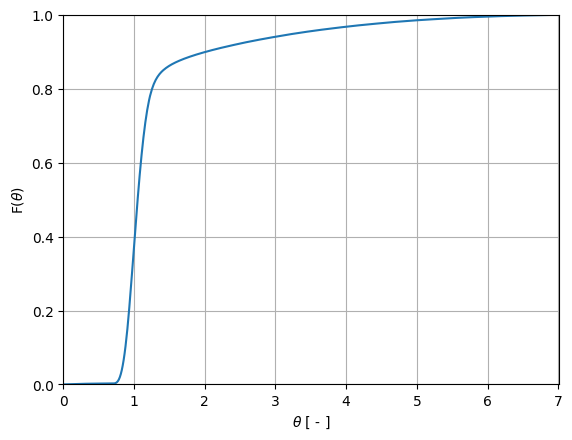

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRaw1['groups'].iat[-1] + 1):
    # if i == 8:
    #     continue
    plt.figure(i)
    #plt.title(i)
    #plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == i], AxDisRaw1['MFC CO (mln/min)'][AxDisRaw1['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD2'][AxDisRaw1['groups'] == i], label = 'RTD CO')
    #plt.plot(AxDisRaw1['theta CO'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD2 CO'][AxDisRaw1['groups'] == i], label = 'RTD CO')

    plt.xlim(left = AxDisRaw1['theta'][AxDisRaw1['groups'] == i].iat[0], right = AxDisRaw1['theta'][AxDisRaw1['groups'] == i].iat[-1])
    #plt.legend(loc='best')
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

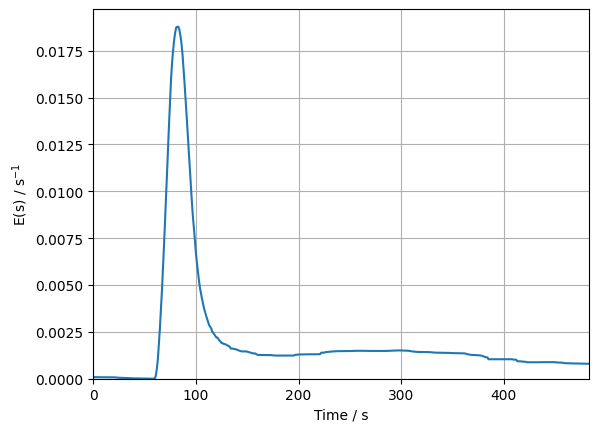

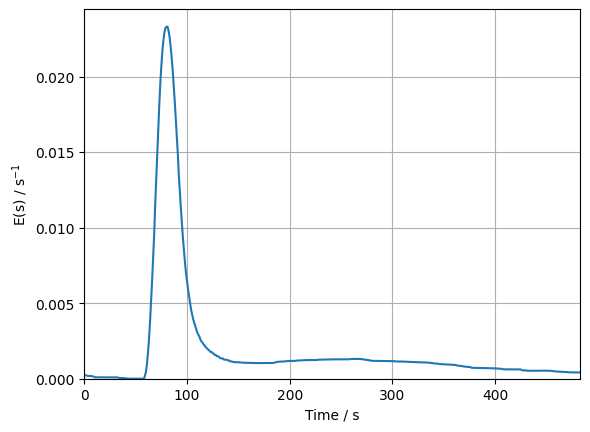

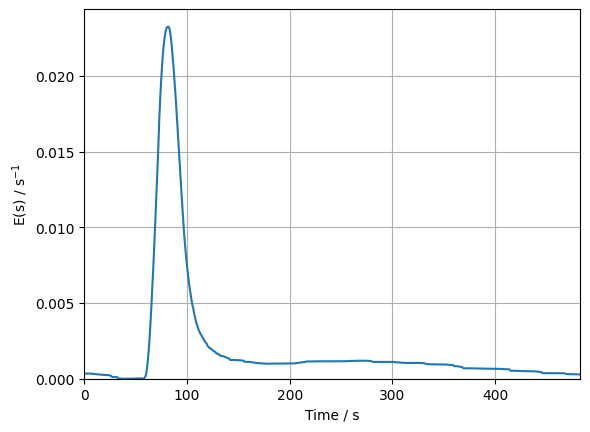

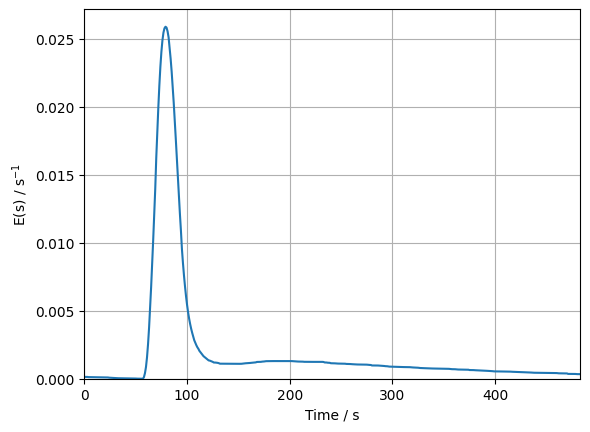

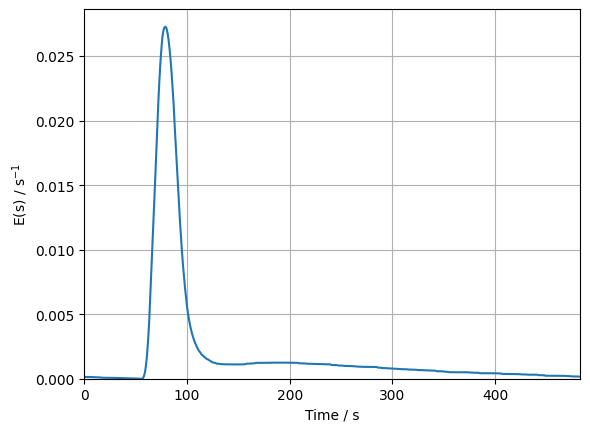

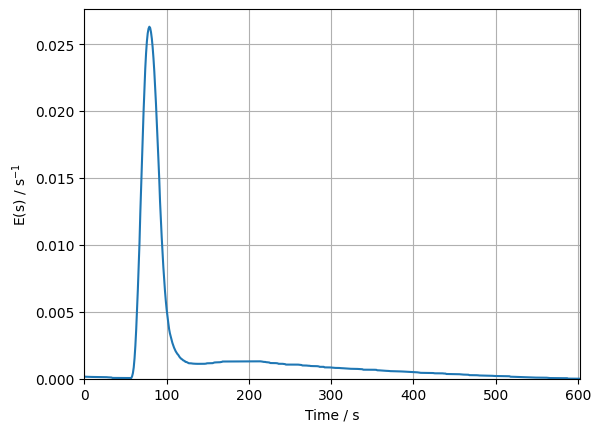

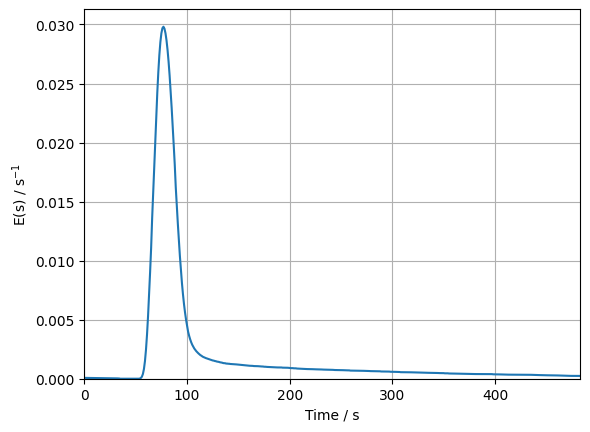

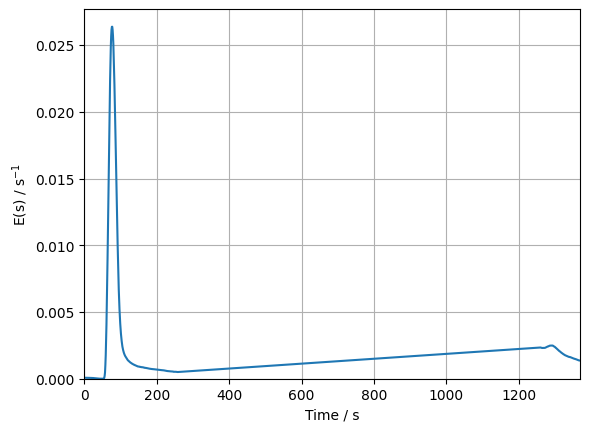

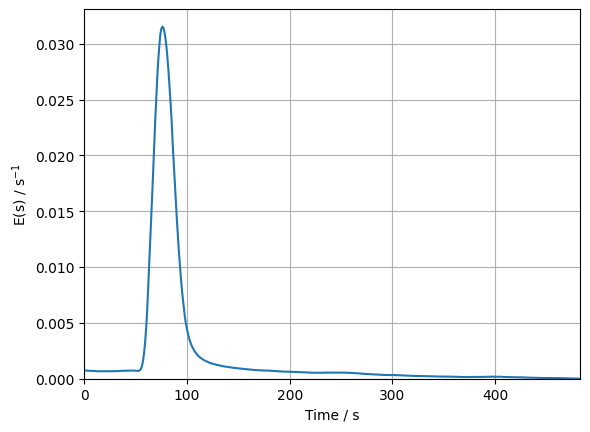

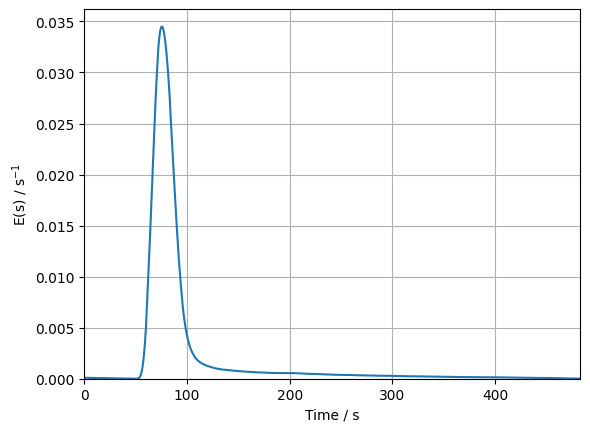

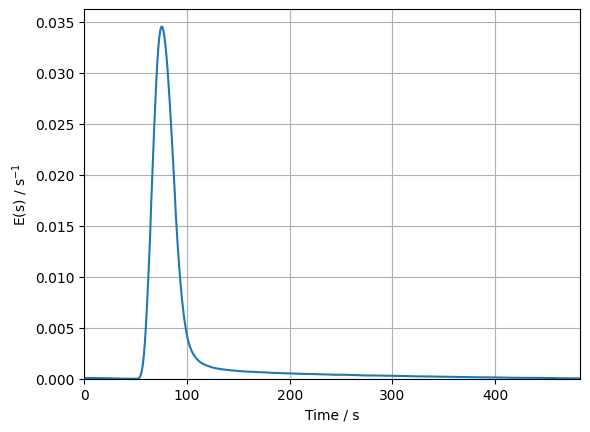

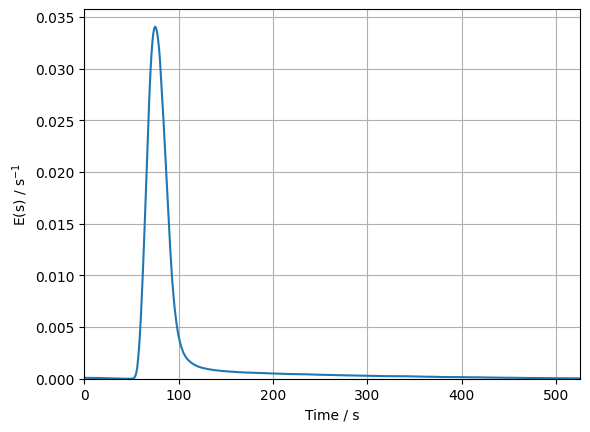

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw1['groups'].iat[-1] + 1):

    plt.figure(i)
    #plt.title(i)
    #plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == i], AxDisRaw1['MFC CO (mln/min)'][AxDisRaw1['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD'][AxDisRaw1['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw1['Dauer (s) norm'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD'][AxDisRaw1['groups'] == i], label = 'RTD CO')
    #plt.plot(AxDisRaw1['Dauer (s) norm'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD CO'][AxDisRaw1['groups'] == i], label = 'RTD CO')

    plt.xlim(left = AxDisRaw1['Dauer (s) norm'][AxDisRaw1['groups'] == i].iat[0], right = AxDisRaw1['Dauer (s) norm'][AxDisRaw1['groups'] == i].iat[-1])
    plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    #plt.legend(loc='best')
    plt.xlabel("Time / s")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s) / s$^{-1}$')
    plt.grid()

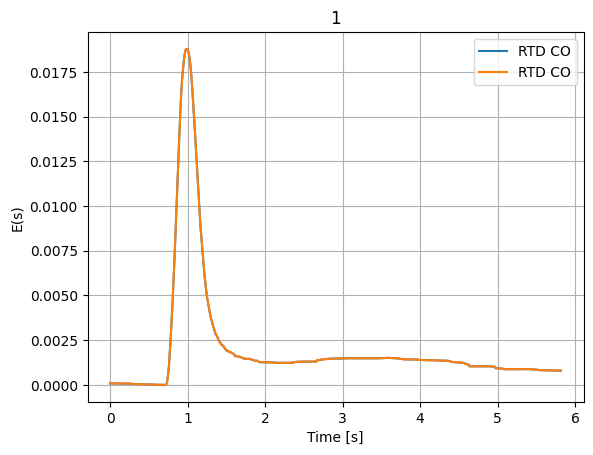

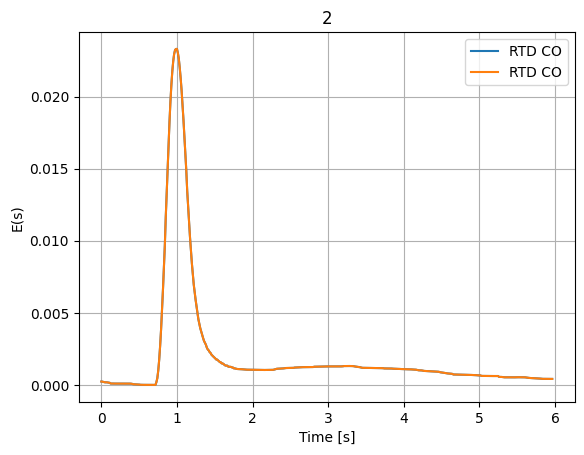

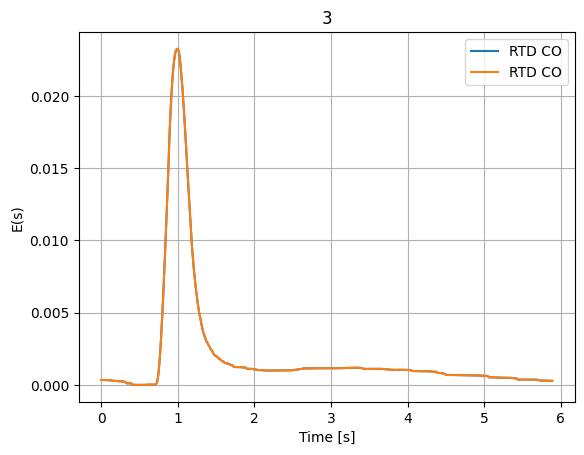

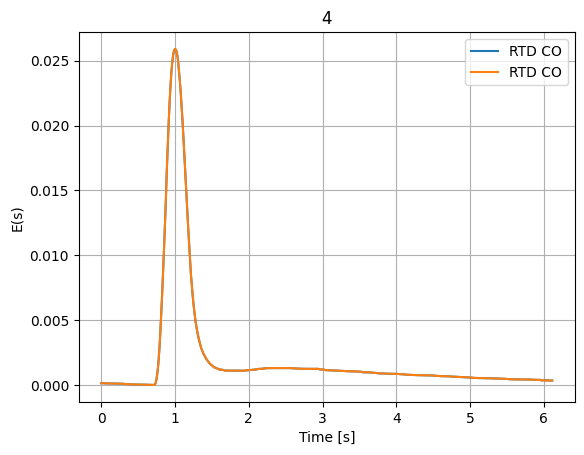

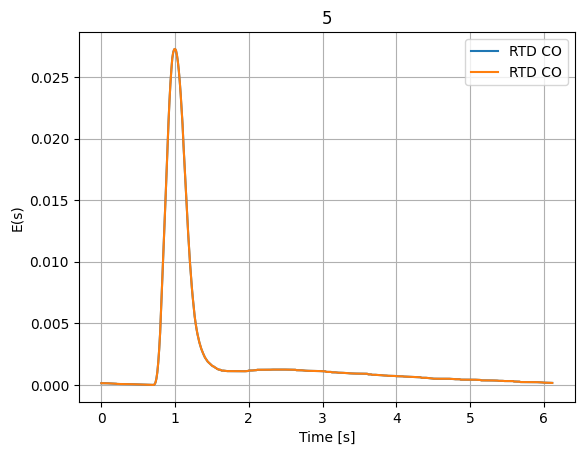

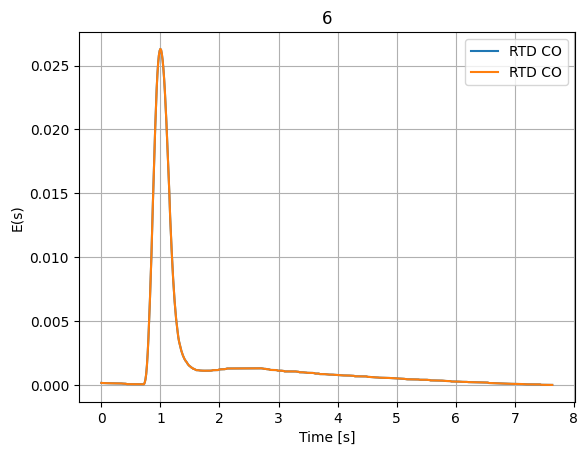

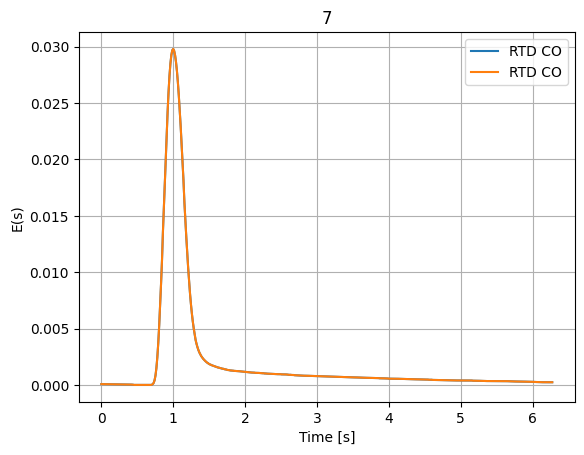

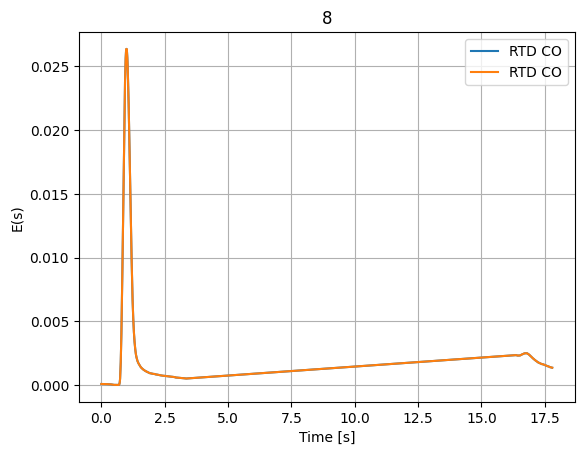

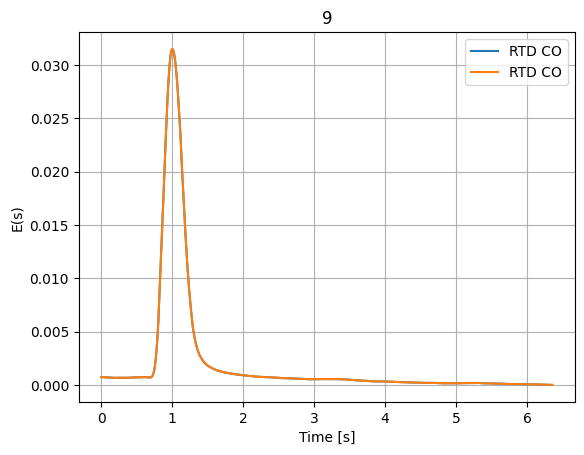

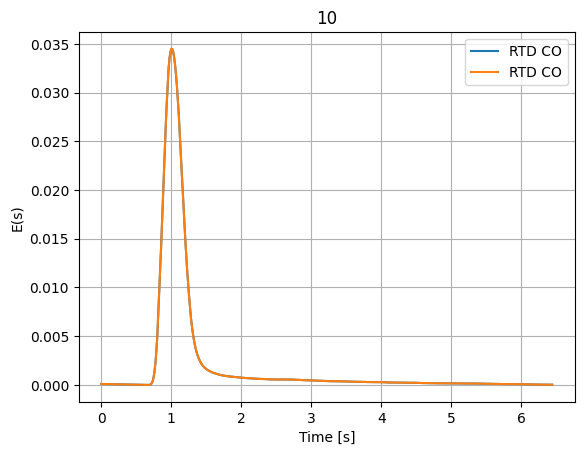

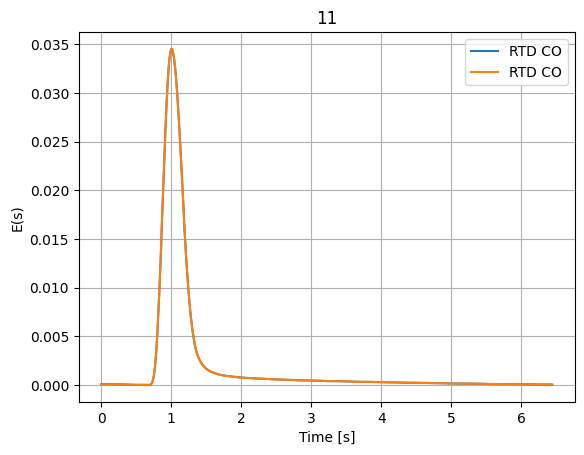

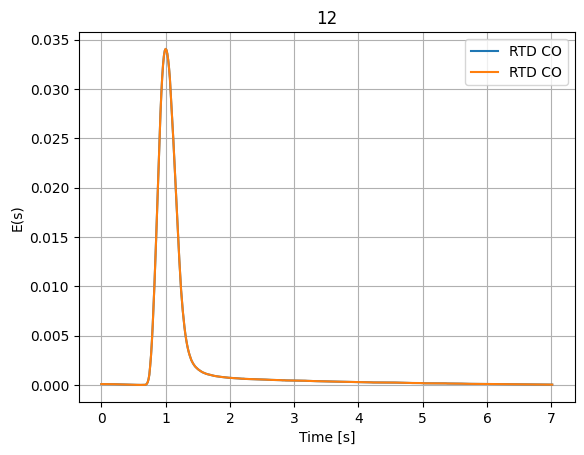

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw1['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw1['Dauer (s)'][AxDisRaw1['groups'] == i], AxDisRaw1['MFC CO (mln/min)'][AxDisRaw1['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD'][AxDisRaw1['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw1['theta'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD'][AxDisRaw1['groups'] == i], label = 'RTD CO')
    plt.plot(AxDisRaw1['theta CO'][AxDisRaw1['groups'] == i], AxDisRaw1['RTD CO'][AxDisRaw1['groups'] == i], label = 'RTD CO')

    #plt.xlim(left = AxDisRaw1['theta'][AxDisRaw1['groups'] == i].iat[0], right = AxDisRaw1['theta'][AxDisRaw1['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.legend(loc='best')
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

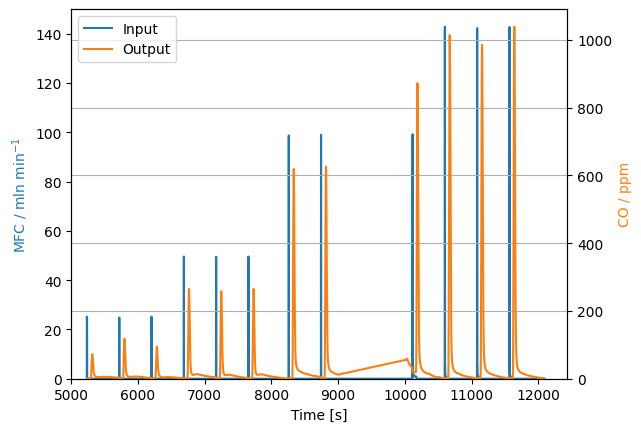

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
ax2.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['CO (ppm) zeroed'], 'tab:orange', label = 'Output')
#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 5000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MFC / mln min$^{-1}$', color = 'tab:blue')
ax2.set_ylabel('CO / ppm', color ='tab:orange')

plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

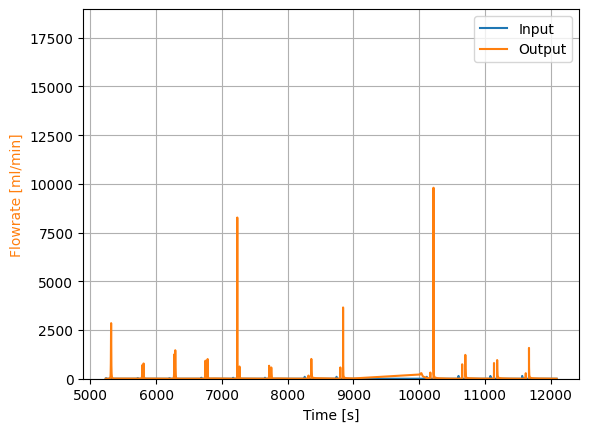

In [ ]:
#@title full hydrogen plot

plt.figure()

plt.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
plt.plot(AxDisRaw1['Dauer (s)'], AxDisRaw1['Output CO (mlN/s)']*60, 'tab:orange', label = 'Output')

plt.ylabel('Flowrate [ml/min]', color ='tab:orange')
plt.xlabel('Time [s]')

plt.ylim(bottom = 0)
plt.legend(loc = 'best')
plt.grid()

## Experiment 2

### data manip

In [ ]:
#@title data manip exp2

m_cat_exp2 = 12.0011 #g
L_bed_exp2 = m_cat_exp2/dens_cat/A_R/100

filepath2 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/RTD Rehman Greiner exp2.csv'
AxDisRaw2 = pd.read_csv(filepath2, encoding='unicode_escape', sep=';')

CutoffRaw2 = AxDisRaw2.index[(AxDisRaw2['MFC CO (mln/min)'] < 5) & (AxDisRaw2['MFC CO (mln/min)'].shift(-1) > 9)].tolist()[0] - 1
AxDisRaw2 = AxDisRaw2[(AxDisRaw2['Dauer (s)'] > CutoffRaw2)]

AxDisRaw2['CO (ppm)'] = AxDisRaw2['CO (ppm)'].shift(-analyzer_shift)
AxDisRaw2 = AxDisRaw2[:-analyzer_shift]

AxDisRaw2['groups'] = 0
AxDisRaw2.loc[(AxDisRaw2['MFC CO (mln/min)'] < 5) & (AxDisRaw2['MFC CO (mln/min)'].shift(-1) > 9), 'groups'] = 1
AxDisRaw2['groups'] = AxDisRaw2['groups'].cumsum()
AxDisRaw2['groups'] = AxDisRaw2['groups'] - 1

AxDisRaw2['CO (ppm) zeroed'] = AxDisRaw2['CO (ppm)'].sub(AxDisRaw2.groupby('groups')['CO (ppm)'].transform('min'))


AxDisRaw2['RTD'] = AxDisRaw2['CO (ppm) zeroed']/AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRaw2['RTD2'] = AxDisRaw2.groupby('groups')['RTD'].transform(pd.Series.cumsum)

min2 = AxDisRaw2.groupby('groups')['Dauer (s)'].transform('min')
AxDisRaw2['Dauer (s) norm'] = AxDisRaw2['Dauer (s)'].sub(min2)

max2 = AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
max22 = AxDisRaw2['Dauer (s) norm'].loc[max2].tolist()
AxDisRaw2['theta'] = AxDisRaw2['Dauer (s) norm']/max22

AxDisRaw2['RTD norm'] = AxDisRaw2['CO (ppm) zeroed']/AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].transform('sum')*max22

CutoffRaw22 = AxDisRaw2.groupby('groups')['Dauer (s)'].transform('min').iat[-1] + 60 * 10
AxDisRaw2 = AxDisRaw2[AxDisRaw2['Dauer (s)'] < CutoffRaw22]

AxDisRaw2['Input (mlN/s)'] = AxDisRaw2['MFC CO (mln/min)'].divide(60)
AxDisRaw2['Input CO (mlN/s)'] = AxDisRaw2['Input (mlN/s)'].multiply(x_CO)
AxDisRaw2['Output (mlN/s)'] = AxDisRaw2['N2-A (ln/min)'].divide(60).divide(1 - AxDisRaw2['CO (ppm) zeroed'] / 100 * x_total).multiply(1000)
AxDisRaw2['Output CO (mlN/s)'] = AxDisRaw2['Output (mlN/s)'] * AxDisRaw2['CO (ppm) zeroed'].divide(100)

InputCOsum2 = AxDisRaw2.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsum2 = AxDisRaw2.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimes2 = AxDisRaw2['Dauer (s) norm'].loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimes22 = AxDisRaw2.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDres2 = pd.DataFrame(np.column_stack([ResTimes22, ResTimes2]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDres2['theta'] = AxDisRaw2['theta'].loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres2['theta +1'] = AxDisRaw2['theta'].shift(-5).loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres2['theta -1'] = AxDisRaw2['theta'].shift(5).loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres2['CO'] = AxDisRaw2['RTD2'].loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres2['CO +1'] = AxDisRaw2['RTD2'].shift(-5).loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres2['CO -1'] = AxDisRaw2['RTD2'].shift(5).loc[AxDisRaw2.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres2['slope_top'] = (RTDres2['CO'].sub(RTDres2['CO +1'])).div(RTDres2['theta'].sub(RTDres2['theta +1']))
RTDres2['slope_bottom'] = (RTDres2['CO -1'].sub(RTDres2['CO'])).div(RTDres2['theta -1'].sub(RTDres2['theta']))

RTDres2['Bo_top'] = (2*RTDres2['slope_top'])**2*np.pi
RTDres2['Bo_bottom'] = (2*RTDres2['slope_bottom'])**2*np.pi


RTDres2['Input total (mln/min)'] = RTDres2['MFC CO (mln/min)'] + 100
RTDres2['Fluid velocity (m/s)'] = RTDres2['Input total (mln/min)'] / 60 / A_R / 100 * 423/273
RTDres2['Calc. Residence Time (s)'] = L_bed_exp2 / (1/0.4 * RTDres2['Fluid velocity (m/s)']) + (0.7 - L_bed_exp1) / RTDres2['Fluid velocity (m/s)'] +  273/423 * dist_pipes1 / (A_F1 * RTDres2['Fluid velocity (m/s)'])
+ dist_pipes2 / (A_F2 * RTDres2['Fluid velocity (m/s)'])

RTDres2['D_ax_top [10^-5 m2/s]'] = d_P * RTDres2['Fluid velocity (m/s)'] / RTDres2['Bo_top'] * 10 ** 5
RTDres2['D_ax_bottom [10^-5 m2/s]'] = d_P * RTDres2['Fluid velocity (m/s)'] / RTDres2['Bo_bottom'] * 10 ** 5

RTDres2['Re'] = 0

RTDres2 = RTDres2[1:]

for i in range(len(RTDres2)):

    H2 = (RTDres2['MFC CO (mln/min)'].iat[i] * x_H2) / RTDres2['Input total (mln/min)'].iat[i]
    CO = (RTDres2['MFC CO (mln/min)'].iat[i] * x_CO) / RTDres2['Input total (mln/min)'].iat[i]
    CO2 = (RTDres2['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDres2['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDres2['Re'].iat[i] = d_P*RTDres2['Fluid velocity (m/s)'].iat[i]*rhog/mug/0.6

RTDres2pretty = RTDres2[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


print('Input ml/min :' + str(InputCOsum2))
print('Output ml/min : ' + str(OutputCOsum2))


AxDisRaw2['E*t'] = AxDisRaw2['RTD']*AxDisRaw2['Dauer (s) norm']
AxDisRaw2['E*t^2*dt'] = AxDisRaw2['RTD']*AxDisRaw2['Dauer (s) norm']**2*1
normvar_2 = np.zeros(len(RTDres2pretty['Residence Time (s)']))
mom1_2 = AxDisRaw2.groupby('groups')['E*t'].sum()
mom2_2 = AxDisRaw2.groupby('groups')['E*t^2*dt'].sum()
var2_2 = mom2_2 - mom1_2**2
var1_2 = np.sqrt(var2_2)
for i in range (len(RTDres2pretty['Residence Time (s)'])):
    normvar_2[i] = var1_2[i+1]**2/(RTDres2pretty['Residence Time (s)'].iat[i]**2)

RTDres2['1. Mom.'] = mom1_2
RTDres2pretty = RTDres2[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', '1. Mom.', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


Input ml/min :[0.00348, 0.00373, 0.0035, 0.00647, 0.00644, 0.00644, 0.01292, 0.01262, 0.01282, 0.02596, 0.0257, 0.03635, 0.04341, 0.04436, 0.04375]
Output ml/min : [11.67207, 18.17828, 14.68604, 107.89004, 145.83728, 116.40276, -45.12195, -75.412, -3227.83189, 0.23305, -30.35828, -38.04458, -49.471, 28.07977, 291.18035]


In [ ]:
#@title find bodenstein for exp 2

values_2 = np.zeros(len(normvar_2))

for i in range (len(normvar_2)):
    if (normvar_2 [i] > 0) & (normvar_2 [i] < 1):
        var_2 = normvar_2 [i]
        initial_guess_2 = [var_2, 1]
        bnds2 = [(var_2, var_2), (0, 150)]

        res_min_2 = minimize(Bodenstein_finder, initial_guess_2, bounds=bnds2)

        values_2[i] = res_min_2.x[1]
    else:
        values_2[i] = 0

In [ ]:
values_2

array([1.64467319, 1.62651496, 0.74093261, 0.55024071, 1.02552515,
       1.13635012, 3.1958778 , 3.87704892, 1.43510227, 3.22051125,
       2.98249748, 3.26186707, 3.58918416, 0.        ])

In [ ]:
#@title Residence time results

RTDres2pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)     1. Mom.  \
1              10.65                 110.65               131.0  180.231838   
2              10.35                 110.35               125.0  209.202299   
3              24.76                 124.76               111.0  172.998866   
4              25.07                 125.07               110.0  174.134641   
5              24.74                 124.74               111.0  168.951317   
6              49.59                 149.59               105.0  145.767993   
7              49.46                 149.46               106.0  132.021356   
8              49.57                 149.57               106.0  128.809866   
9              98.90                 198.90               102.0  137.062895   
10             98.92                 198.92               102.0  126.461831   
11             99.12                 199.12               102.0  127.589257   
12            142.73                 242.73               100.0  124.806167   
13            142.60                 242.60               101.0  124.799884   
14            142.17                 242.17               100.0   64.450460   

    Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
1               0.036382                 22.557076   9.400423   9.465721   
2               0.036283                 22.618400  11.979308  11.902234   
3               0.041022                 20.005935  38.528981  40.249257   
4               0.041123                 19.956348  37.637850  38.880920   
5               0.041015                 20.009143  37.949021  41.323549   
6               0.049186                 16.685209  61.235057  63.010815   
7               0.049143                 16.699722  70.364568  73.208249   
8               0.049179                 16.687441  74.168967  77.041013   
9               0.065399                 12.548720  68.158862  69.691550   
10              0.065406                 12.547459  75.913295  77.521871   
11              0.065471                 12.534856  74.202412  76.761733   
12              0.079811                 10.282785  74.026932  75.408769   
13              0.079768                 10.288295  76.598349  78.863750   
14              0.079626                 10.306564   5.855476   5.920277   

    D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]        Re  
1                0.387026                  0.384357  1.006017  
2                0.302885                  0.304846  1.003290  
3                0.106469                  0.101919  1.134304  
4                0.109261                  0.105768  1.137122  
5                0.108079                  0.099253  1.134122  
6                0.080323                  0.078059  1.360055  
7                0.069841                  0.067128  1.358873  
8                0.066307                  0.063835  1.359873  
9                0.095951                  0.093841  1.808376  
10               0.086158                  0.084371  1.808558  
11               0.088233                  0.085292  1.810376  
12               0.107813                  0.105837  2.206873  
13               0.104138                  0.101146  2.205691  
14               1.359862                  1.344977  2.201782

In [ ]:
L_bed_exp2

0.1886453716089032

###plots exp2

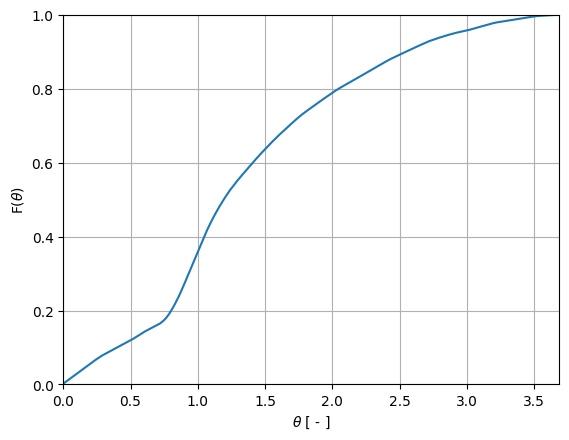

In [ ]:
#@title plot first group

# plt.plot(AxDisRaw2['Dauer (s)'][AxDisRaw2['groups'] == 1], AxDisRaw2['MFC CO (mln/min)'][AxDisRaw2['groups'] == 1], label = 'CO (mln/min)')
# plt.plot(AxDisRaw2['Dauer (s)'][AxDisRaw2['groups'] == 1], AxDisRaw2['CO (ppm) zeroed'][AxDisRaw2['groups'] == 1], label = 'CO (ppm)')

#plt.plot(AxDisRaw2['theta'][AxDisRaw2['groups'] == 1], AxDisRaw2['MFC CO (mln/min)'][AxDisRaw2['groups'] == 1], label = 'CO (mln/min)')
plt.plot(AxDisRaw2['theta'][AxDisRaw2['groups'] == 1], AxDisRaw2['RTD2'][AxDisRaw2['groups'] == 1], label = 'RTD')

# plt.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['MFC CO (mln/min)'], label = 'CO (mln/min)')
# plt.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['CO (ppm)'], label = 'CO (ppm)')

#plt.plot(AxDisRaw2['Dauer (s)'][AxDisRaw2['groups'] == 1], AxDisRaw2['groups'][AxDisRaw2['groups'] == 1])
plt.xlim(left = AxDisRaw2['theta'][AxDisRaw2['groups'] == 1].iat[0], right = AxDisRaw2['theta'][AxDisRaw2['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

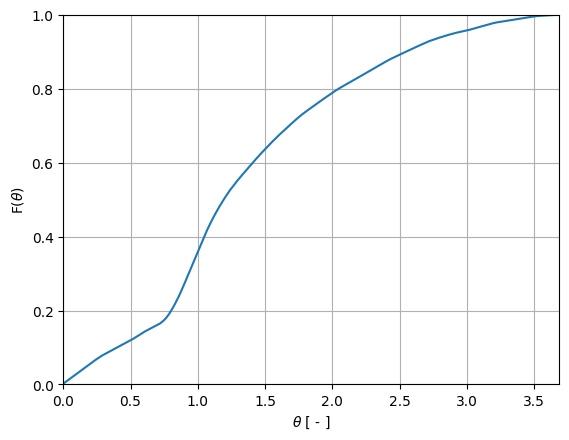

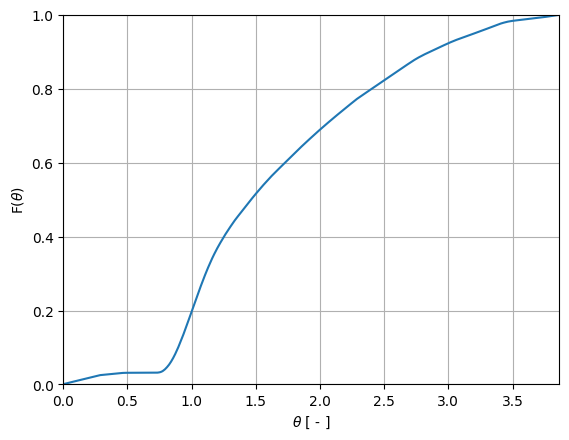

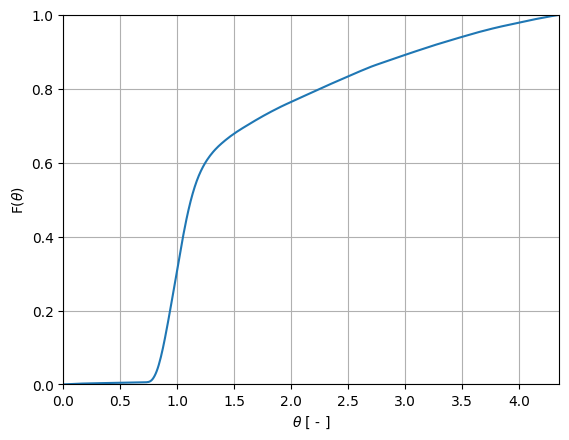

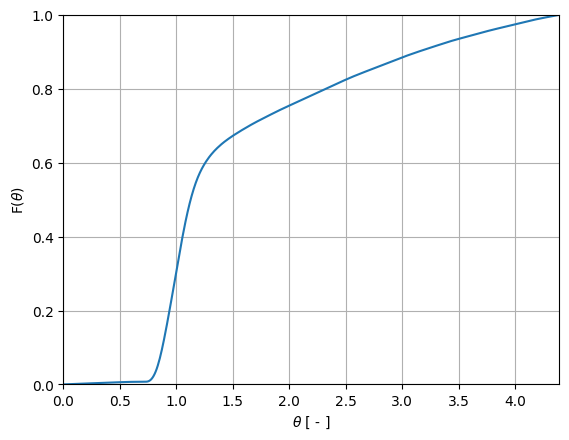

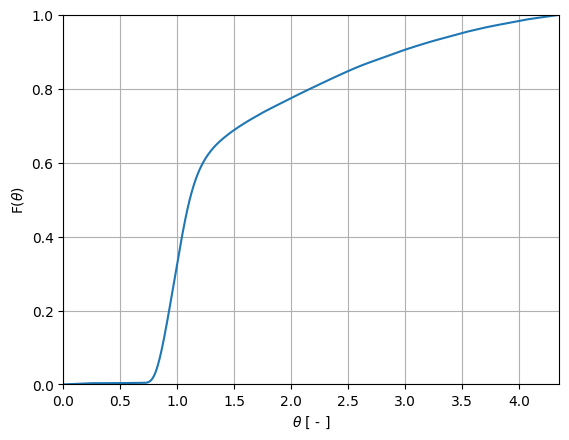

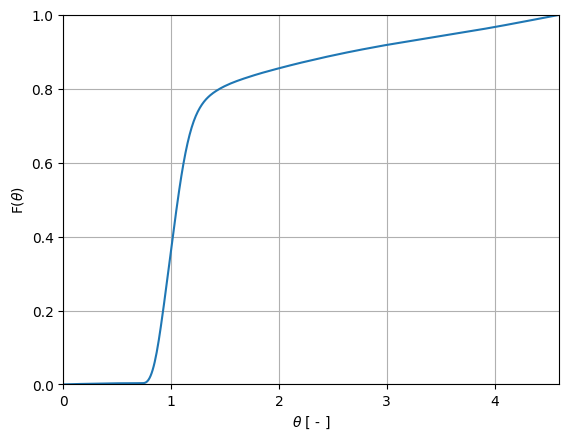

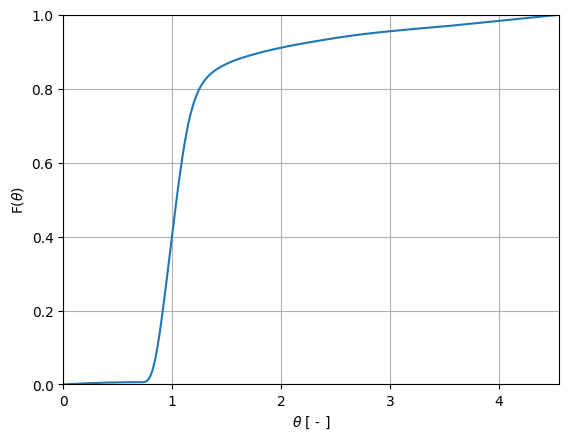

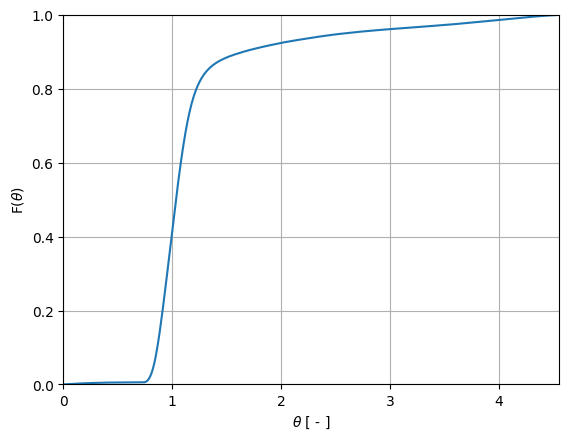

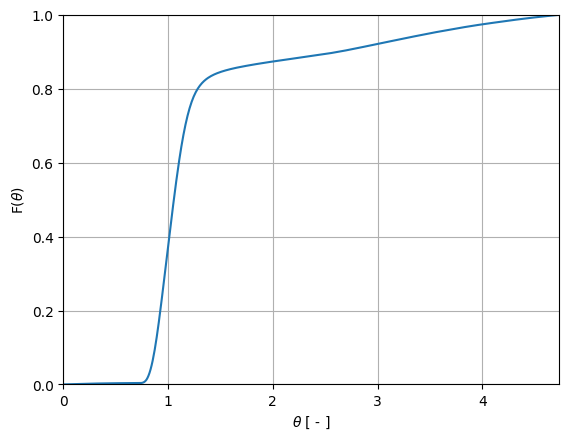

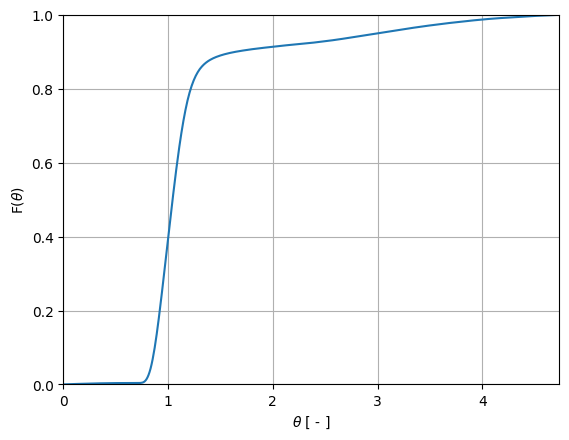

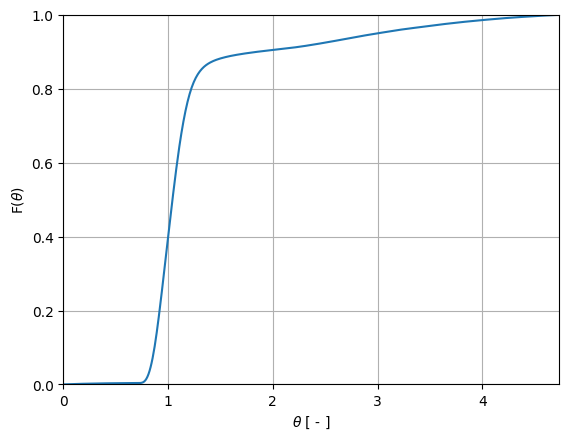

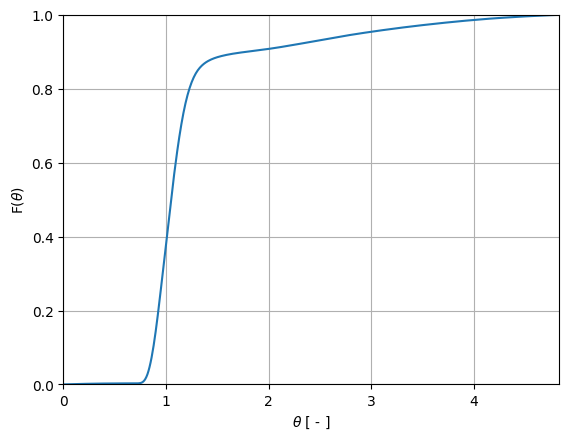

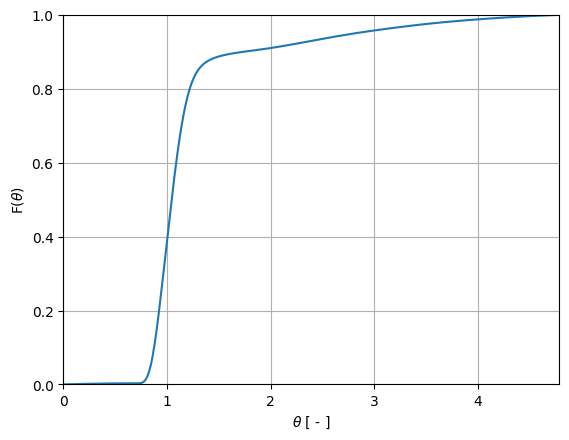

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRaw2['groups'].iat[-1]):

    plt.figure(i)
    #plt.title(i)
    #plt.plot(AxDisRaw2['Dauer (s)'][AxDisRaw2['groups'] == i], AxDisRaw2['MFC CO (mln/min)'][AxDisRaw2['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRaw2['theta'][AxDisRaw2['groups'] == i], AxDisRaw2['RTD2'][AxDisRaw2['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw2['theta'][AxDisRaw2['groups'] == i].iat[0], right = AxDisRaw2['theta'][AxDisRaw2['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

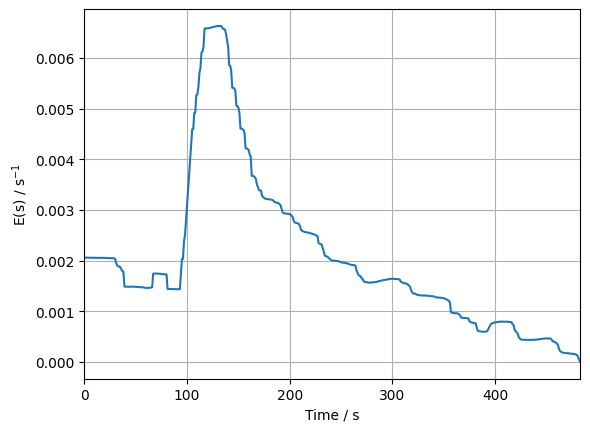

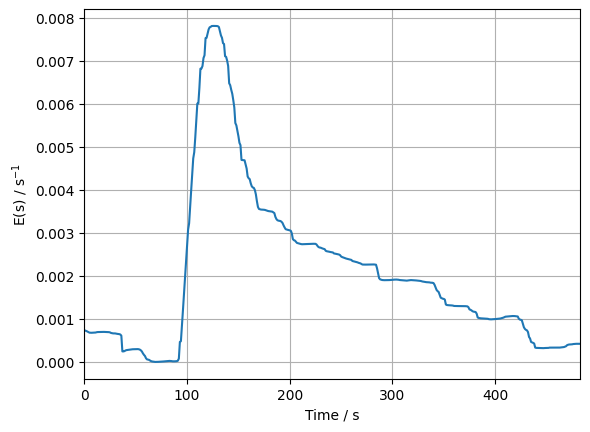

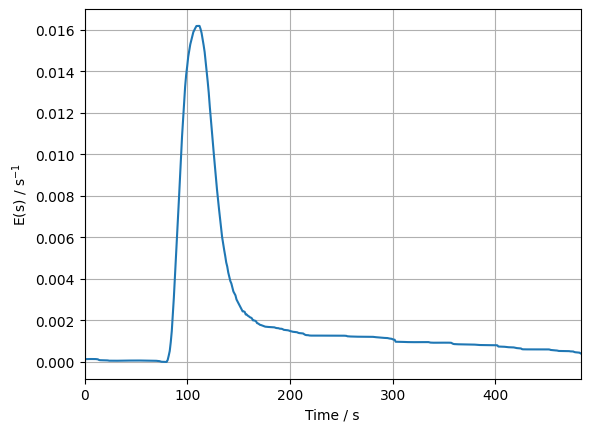

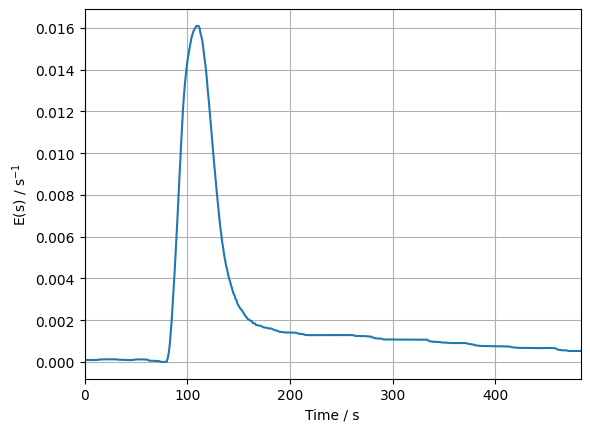

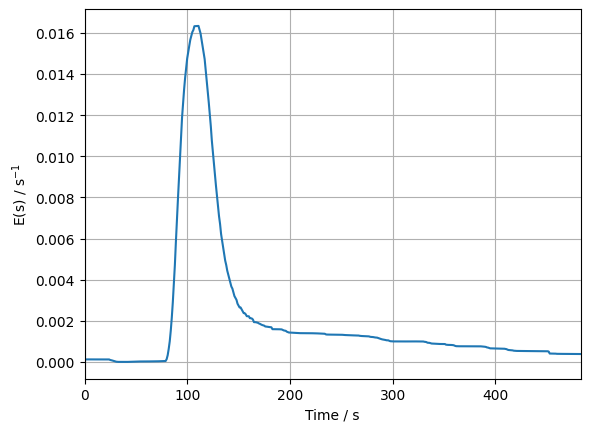

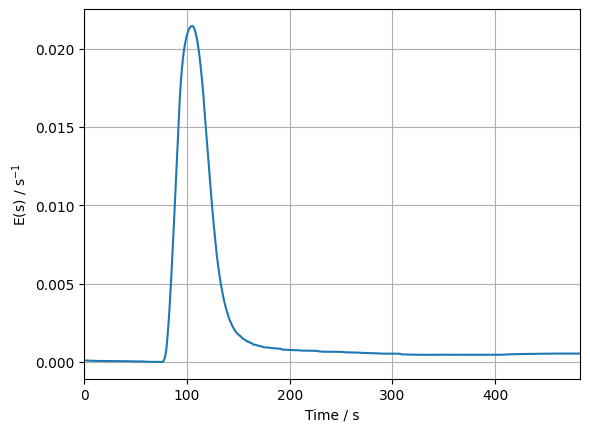

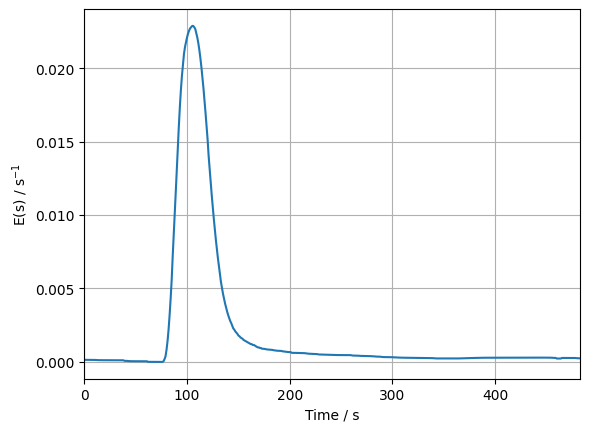

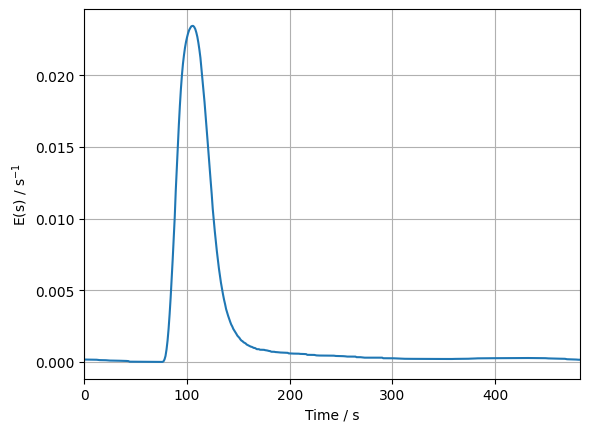

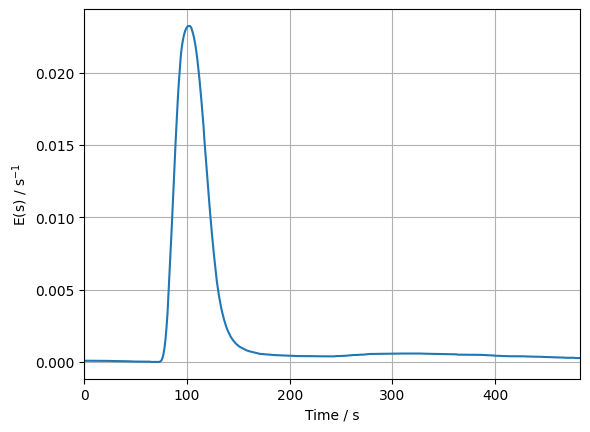

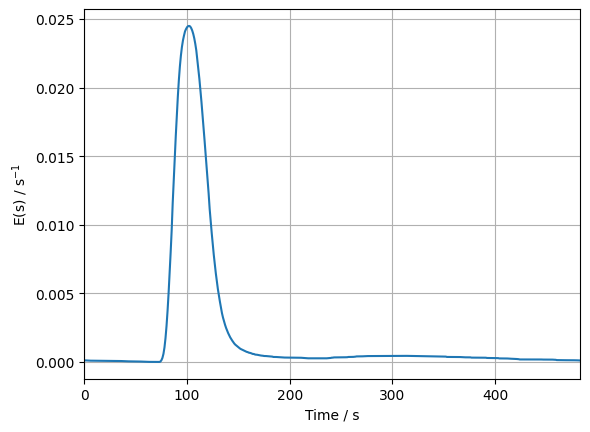

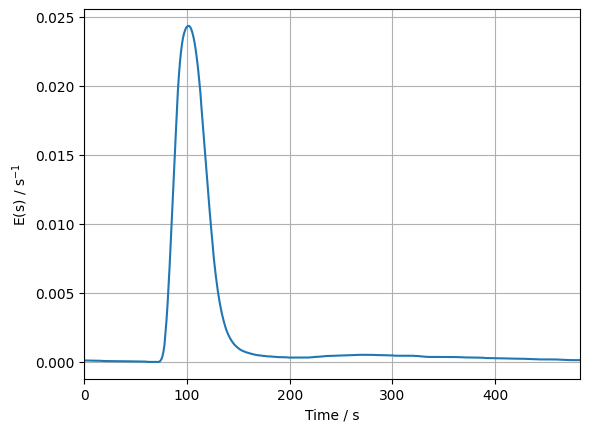

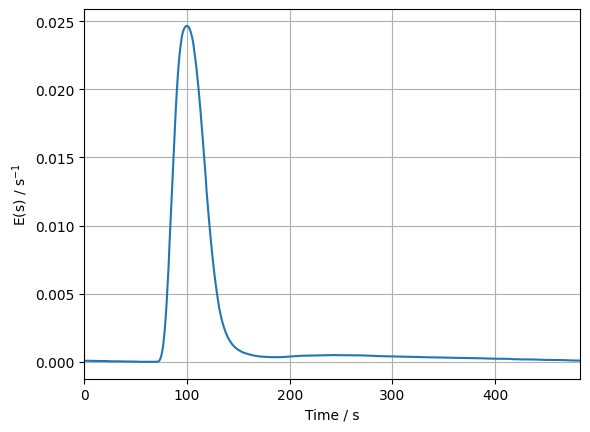

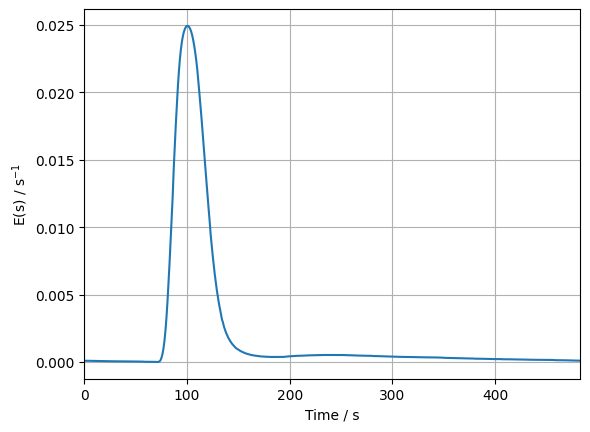

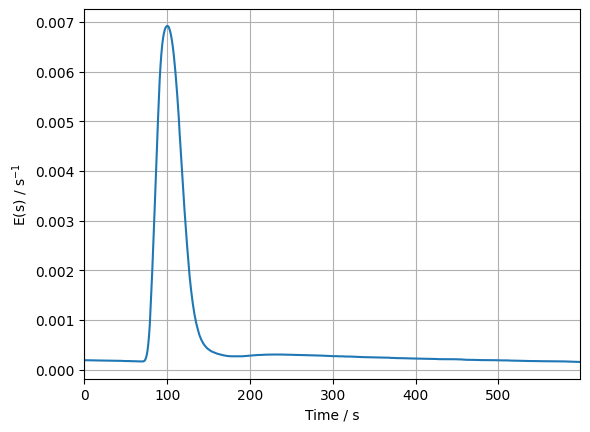

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw2['groups'].iat[-1] + 1):

    plt.figure(i)
    #plt.title(i)
    #plt.plot(AxDisRaw2['Dauer (s)'][AxDisRaw2['groups'] == i], AxDisRaw2['MFC CO (mln/min)'][AxDisRaw2['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRaw2['Dauer (s) norm'][AxDisRaw2['groups'] == i], AxDisRaw2['H2 (Vol%)'][AxDisRaw2['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw2['Dauer (s) norm'][AxDisRaw2['groups'] == i], AxDisRaw2['RTD'][AxDisRaw2['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw2['Dauer (s) norm'][AxDisRaw2['groups'] == i].iat[0], right = AxDisRaw2['Dauer (s) norm'][AxDisRaw2['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time / s")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s) / s$^{-1}$')
    plt.grid()

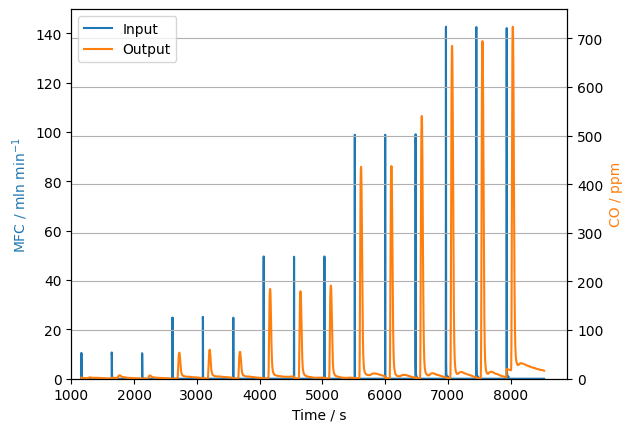

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
ax2.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['CO (ppm) zeroed'], 'tab:orange', label = 'Output')

#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 1000)
ax1.set_xlabel('Time / s')
ax1.set_ylabel('MFC / mln min$^{-1}$', color = 'tab:blue')
ax2.set_ylabel('CO / ppm', color ='tab:orange')
plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()


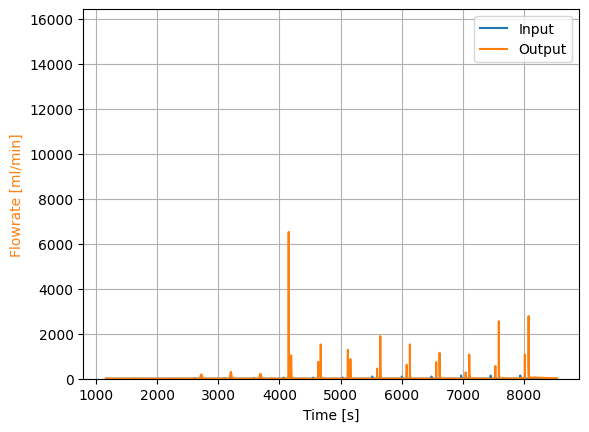

In [ ]:
#@title full hydrogen plot

plt.figure()

plt.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
plt.plot(AxDisRaw2['Dauer (s)'], AxDisRaw2['Output CO (mlN/s)']*60, 'tab:orange', label = 'Output')

plt.ylabel('Flowrate [ml/min]', color ='tab:orange')
plt.xlabel('Time [s]')

plt.ylim(bottom = 0)
plt.legend(loc = 'best')
plt.grid()

## Experiment 3

### data manip

In [ ]:
#@title data manip exp3

m_cat_exp3 = 24.0041 #g
L_bed_exp3 = m_cat_exp3/dens_cat/A_R/100

filepath3 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/RTD Rehman Greiner exp3.csv'

AxDisRaw3 = pd.read_csv(filepath3, encoding='unicode_escape', sep=';')

CutoffRaw3 = AxDisRaw3.index[(AxDisRaw3['MFC CO (mln/min)'] < 5) & (AxDisRaw3['MFC CO (mln/min)'].shift(-1) > 20)].tolist()[0] - 1
AxDisRaw3 = AxDisRaw3[AxDisRaw3['Dauer (s)'] > CutoffRaw3]

# AxDisRaw3['CO (ppm)'] = AxDisRaw3['CO (ppm)'].shift(-analyzer_shift)
# AxDisRaw3 = AxDisRaw3[:-analyzer_shift]

AxDisRaw3['groups'] = 0
AxDisRaw3.loc[(AxDisRaw3['MFC CO (mln/min)'] < 5) & (AxDisRaw3['MFC CO (mln/min)'].shift(-1) > 9) & (AxDisRaw3['Dauer (s)'] < 3000), 'groups'] = 1
AxDisRaw3.loc[(AxDisRaw3['MFC CO (mln/min)'] < 10) & (AxDisRaw3['MFC CO (mln/min)'].shift(-1) > 20) & (AxDisRaw3['Dauer (s)'] >= 3000), 'groups'] = 1
AxDisRaw3['groups'] = AxDisRaw3['groups'].cumsum()

AxDisRaw3['CO (ppm) zeroed'] = AxDisRaw3['CO (ppm)'].sub(AxDisRaw3.groupby('groups')['CO (ppm)'].transform('min'))


AxDisRaw3['RTD'] = AxDisRaw3['CO (ppm) zeroed']/AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRaw3['RTD2'] = AxDisRaw3.groupby('groups')['RTD'].transform(pd.Series.cumsum)

min3 = AxDisRaw3.groupby('groups')['Dauer (s)'].transform('min')
AxDisRaw3['Dauer (s) norm'] = AxDisRaw3['Dauer (s)'].sub(min3)

max3 = AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
max33 = AxDisRaw3['Dauer (s) norm'].loc[max3].tolist()
AxDisRaw3['theta'] = AxDisRaw3['Dauer (s) norm']/max33

AxDisRaw3['RTD norm'] = AxDisRaw3['CO (ppm) zeroed']/AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].transform('sum')*max33

AxDisRaw3['Input (mlN/s)'] = AxDisRaw3['MFC CO (mln/min)'] / 60
AxDisRaw3['Input CO (mlN/s)'] = AxDisRaw3['Input (mlN/s)'] * x_CO
AxDisRaw3['Output (mlN/s)'] = AxDisRaw3['N2-A (ln/min)'] / 60 / (1 - AxDisRaw3['CO (ppm) zeroed'] / 100 * x_total)* 1000
AxDisRaw3['Output CO (mlN/s)'] = AxDisRaw3['Output (mlN/s)'] * AxDisRaw3['CO (ppm) zeroed'] / 100

# residence times in seconds

ResTimes3 = AxDisRaw3['Dauer (s) norm'].loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimes33 = AxDisRaw3.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDres3 = pd.DataFrame(np.column_stack([ResTimes33, ResTimes3]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDres3['theta'] = AxDisRaw3['theta'].loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres3['theta +1'] = AxDisRaw3['theta'].shift(-5).loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres3['theta -1'] = AxDisRaw3['theta'].shift(5).loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres3['CO'] = AxDisRaw3['RTD2'].loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres3['CO +1'] = AxDisRaw3['RTD2'].shift(-5).loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres3['CO -1'] = AxDisRaw3['RTD2'].shift(5).loc[AxDisRaw3.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres3['slope_top'] = (RTDres3['CO'].sub(RTDres3['CO +1'])).div(RTDres3['theta'].sub(RTDres3['theta +1']))
RTDres3['slope_bottom'] = (RTDres3['CO -1'].sub(RTDres3['CO'])).div(RTDres3['theta -1'].sub(RTDres3['theta']))

RTDres3['Bo_top'] = (2*RTDres3['slope_top'])**2*np.pi
RTDres3['Bo_bottom'] = (2*RTDres3['slope_bottom'])**2*np.pi


RTDres3['Input total (mln/min)'] = RTDres3['MFC CO (mln/min)'] + 100
RTDres3['Fluid velocity (m/s)'] = RTDres3['Input total (mln/min)'] / 60 / A_R / 100 * 423/273
RTDres3['Calc. Residence Time (s)'] = L_bed_exp3 / (1/0.4 * RTDres3['Fluid velocity (m/s)']) + (0.7 - L_bed_exp1) / RTDres3['Fluid velocity (m/s)'] +  273/423 * dist_pipes1 / (A_F1 * RTDres3['Fluid velocity (m/s)'])
+ dist_pipes2 / (A_F2 * RTDres3['Fluid velocity (m/s)'])

RTDres3['D_ax_top [10^-5 m2/s]'] = L_bed_exp3 * RTDres3['Fluid velocity (m/s)'] / RTDres3['Bo_top'] * 10 ** 5
RTDres3['D_ax_bottom [10^-5 m2/s]'] = L_bed_exp3 * RTDres3['Fluid velocity (m/s)'] / RTDres3['Bo_bottom'] * 10 ** 5

RTDres3['Re'] = 0

for i in range(len(RTDres3)):

    H2 = (RTDres3['MFC CO (mln/min)'].iat[i] * x_H2) / RTDres3['Input total (mln/min)'].iat[i]
    CO = (RTDres3['MFC CO (mln/min)'].iat[i] * x_CO) / RTDres3['Input total (mln/min)'].iat[i]
    CO2 = (RTDres3['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDres3['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDres3['Re'].iat[i] = d_P*RTDres3['Fluid velocity (m/s)'].iat[i]*rhog/mug/0.6

RTDres3pretty = RTDres3[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


InputCOsum3 = AxDisRaw3.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsum3 = AxDisRaw3.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

print('Input ml/min :' + str(InputCOsum3))
print('Output ml/min : ' + str(OutputCOsum3))


AxDisRaw3['E*t'] = AxDisRaw3['RTD']*AxDisRaw3['Dauer (s) norm']
AxDisRaw3['E*t^2*dt'] = AxDisRaw3['RTD']*AxDisRaw3['Dauer (s) norm']**2*1
normvar_3 = np.zeros(len(RTDres3pretty['Residence Time (s)']))
mom1_3 = AxDisRaw3.groupby('groups')['E*t'].sum()
mom2_3 = AxDisRaw3.groupby('groups')['E*t^2*dt'].sum()
var2_3 = mom2_3 - mom1_3**2
var1_3 = np.sqrt(var2_3)
for i in range (len(RTDres3pretty['Residence Time (s)'])):
    normvar_3[i] = var1_3[i+1]**2/(RTDres3pretty['Residence Time (s)'].iat[i]**2)

RTDres3['1. Mom.'] = mom1_3
RTDres3pretty = RTDres3[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', '1. Mom.', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


Input ml/min :[0.0064, 0.0064, 0.00642, 0.0127, 0.01256, 0.01612, 0.03726, 0.02392, 0.03374, 0.04037, 0.03959, 0.05028]
Output ml/min : [47.1199, 44.1287, 83.03992, 724.05723, -113.61619, 60.46981, 39.55113, 777.89645, 33.11442, nan, -1846.34745, 34.08307]


In [ ]:
#@title find bodenstein for exp 3

values_3 = np.zeros(len(normvar_3))

for i in range (len(normvar_3)):
    var_3 = normvar_3 [i]
    initial_guess_3 = [var_3, 1]
    bnds3 = [(var_3, var_3), (0, 150)]

    res_min_3 = minimize(Bodenstein_finder, initial_guess_3, bounds=bnds3)

    values_3[i] = res_min_3.x[1]


<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDres3pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)     1. Mom.  \
0              24.74                 124.74               142.0         NaN   
1              24.74                 124.74               137.0  236.150670   
2              24.72                 124.72               133.0  230.023654   
3              49.46                 149.46               127.0  202.262475   
4              49.46                 149.46               128.0  170.836130   
5              49.59                 149.59               129.0  171.980788   
6              98.90                 198.90               125.0  200.488410   
7              98.94                 198.94               124.0  157.276120   
8              98.63                 198.63               124.0  167.006339   
9             141.99                 241.99               122.0  155.179800   
10            141.77                 241.77               123.0  151.977705   
11            142.43                 242.43               123.0  141.276712   

    Fluid velocity (m/s)  Calc. Residence Time (s)      Bo_top   Bo_bottom  \
0               0.041015                 21.849205    7.690584    8.239609   
1               0.041015                 21.849205   14.431972   14.970730   
2               0.041008                 21.852709   39.411803   42.771787   
3               0.049143                 18.235447   82.159517   82.600997   
4               0.049143                 18.235447   81.860247   84.864174   
5               0.049186                 18.219599   64.834281   67.196333   
6               0.065399                 13.702714  106.381993  110.895635   
7               0.065412                 13.699959   98.015122   99.702967   
8               0.065310                 13.721341  106.527272  107.673546   
9               0.079567                 11.262738  115.115501  115.956096   
10              0.079495                 11.272986  121.243532  125.408467   
11              0.079712                 11.242296  124.854021  129.348271   

    D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]        Re  
0              201.230366                187.821912  1.134122  
1              107.232684                103.373659  1.134122  
2               39.260599                 36.176439  1.133940  
3               22.569099                 22.448473  1.358873  
4               22.651608                 21.849812  1.358873  
5               28.624966                 27.618755  1.360055  
6               23.196036                 22.251918  1.808376  
7               25.181184                 24.754898  1.808740  
8               23.132957                 22.886688  1.805921  
9               26.080189                 25.891127  2.200145  
10              24.739502                 23.917879  2.198145  
11              24.089675                 23.252671  2.204146

###plots exp3

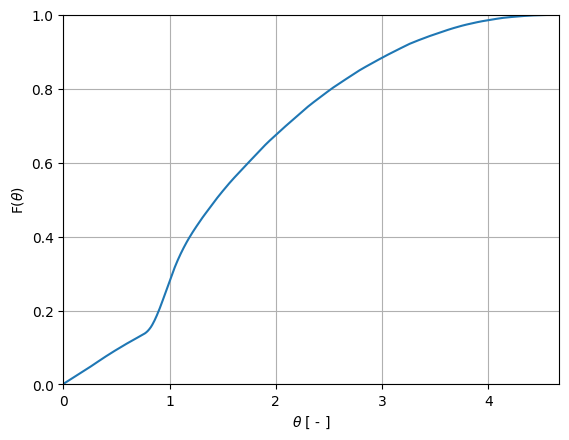

In [ ]:
#@title plot first group

# plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == 1], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == 1], label = 'CO (mln/min)')
# plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == 1], AxDisRaw3['CO (ppm) zeroed'][AxDisRaw3['groups'] == 1], label = 'CO (ppm)')

#plt.plot(AxDisRaw3['theta'][AxDisRaw3['groups'] == 1], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == 1], label = 'CO (mln/min)')
plt.plot(AxDisRaw3['theta'][AxDisRaw3['groups'] == 1], AxDisRaw3['RTD2'][AxDisRaw3['groups'] == 1], label = 'RTD')

# plt.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['MFC CO (mln/min)'], label = 'CO (mln/min)')
# plt.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['CO (ppm)'], label = 'CO (ppm)')

#plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == 1], AxDisRaw3['groups'][AxDisRaw3['groups'] == 1])
plt.xlim(left = AxDisRaw3['theta'][AxDisRaw3['groups'] == 1].iat[0], right = AxDisRaw3['theta'][AxDisRaw3['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

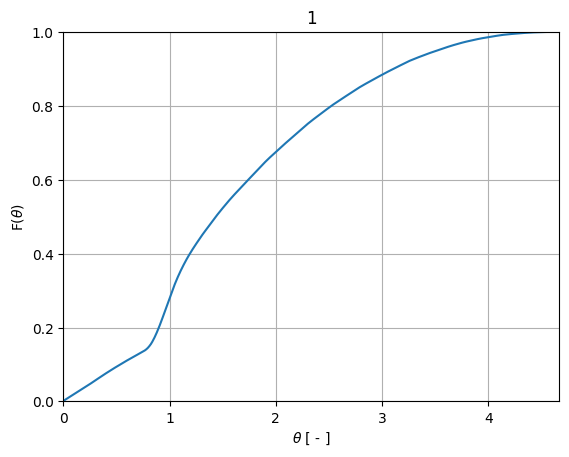

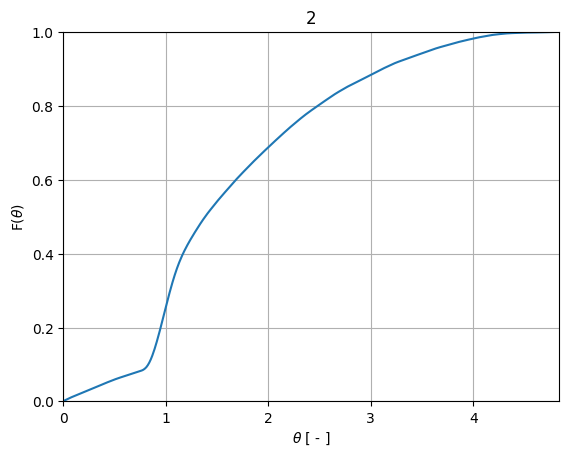

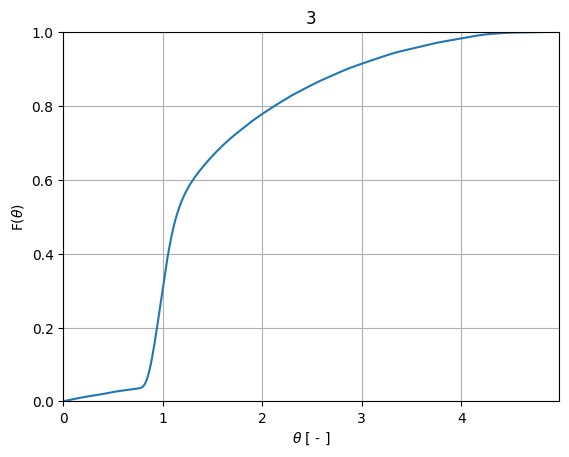

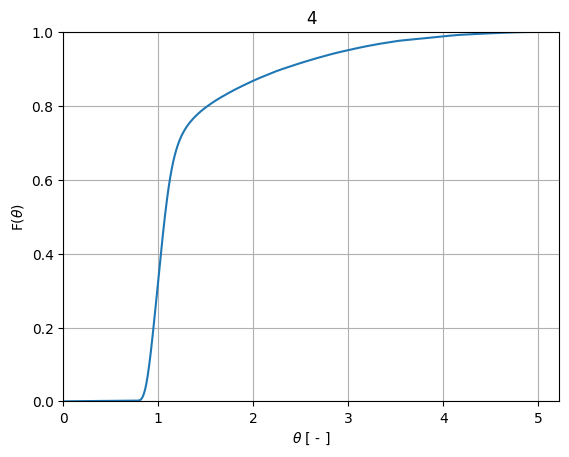

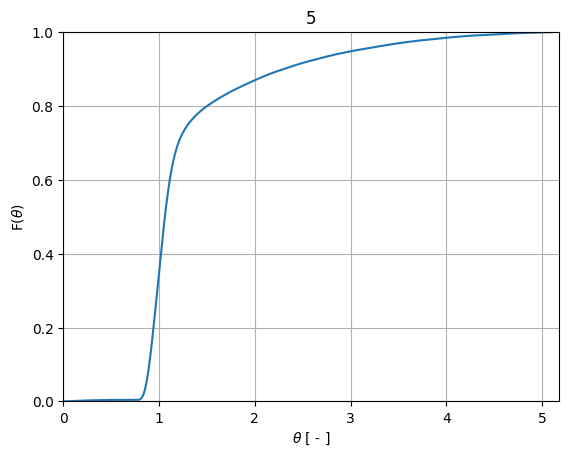

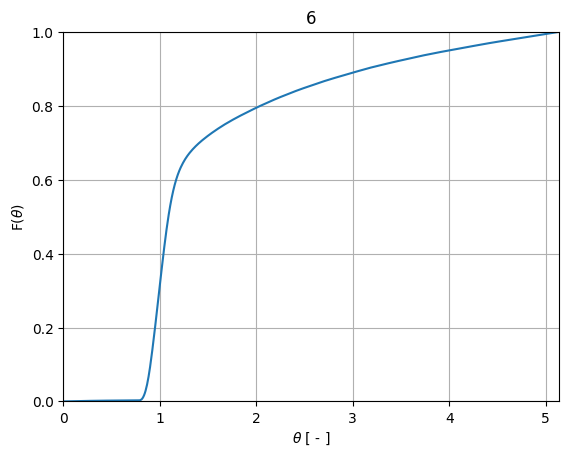

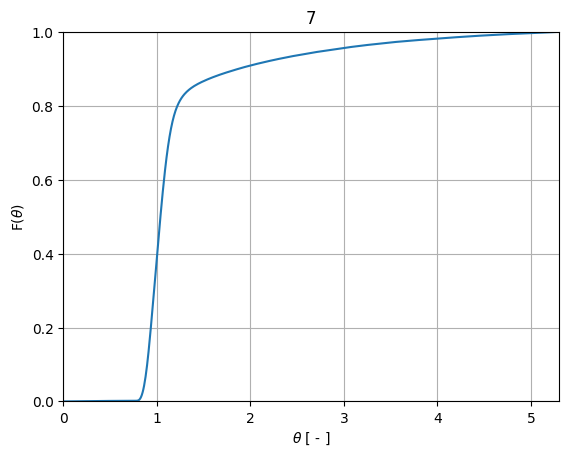

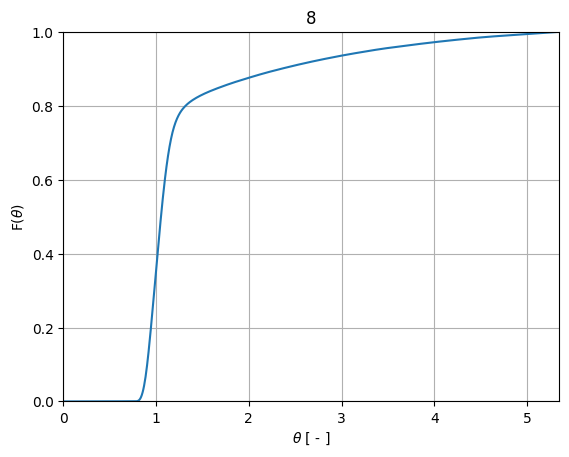

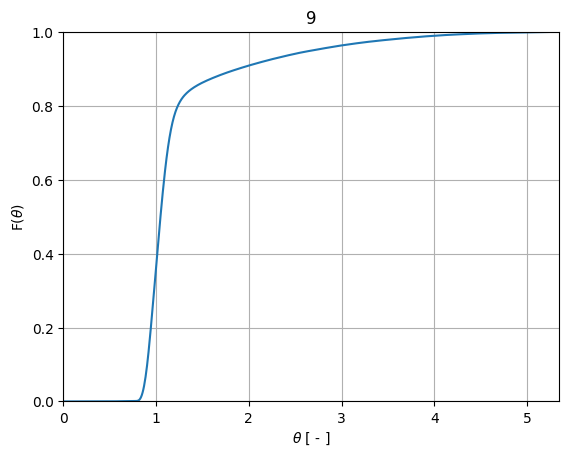

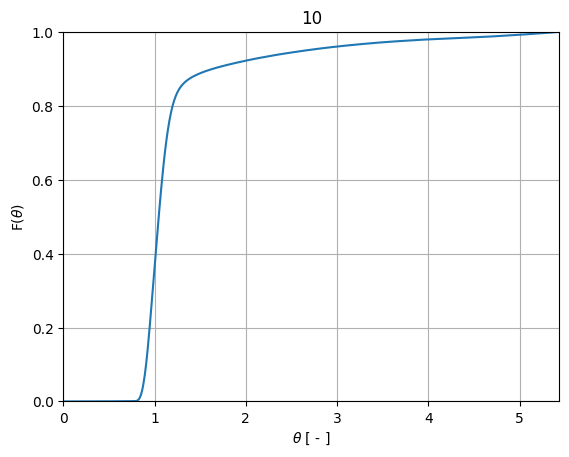

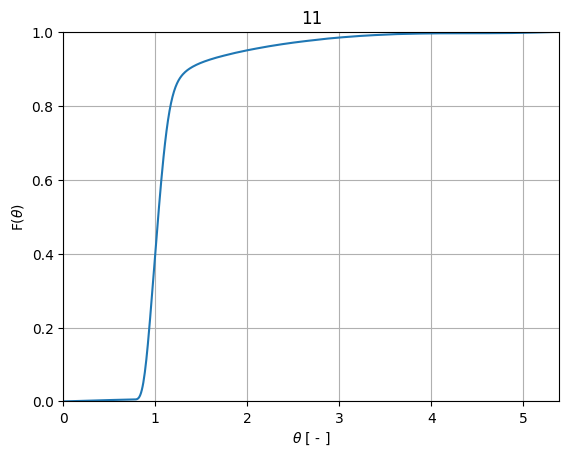

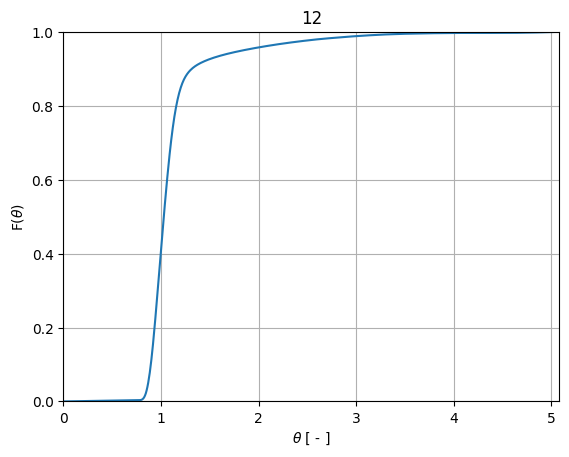

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRaw3['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == i], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRaw3['theta'][AxDisRaw3['groups'] == i], AxDisRaw3['RTD2'][AxDisRaw3['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw3['theta'][AxDisRaw3['groups'] == i].iat[0], right = AxDisRaw3['theta'][AxDisRaw3['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

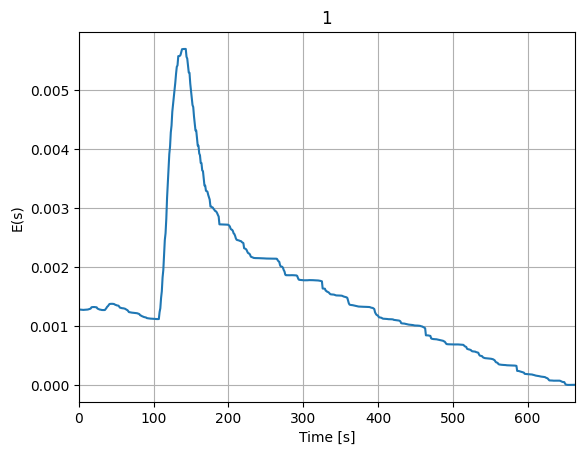

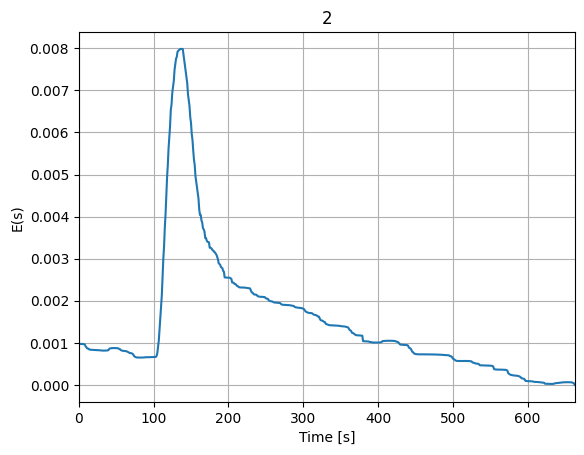

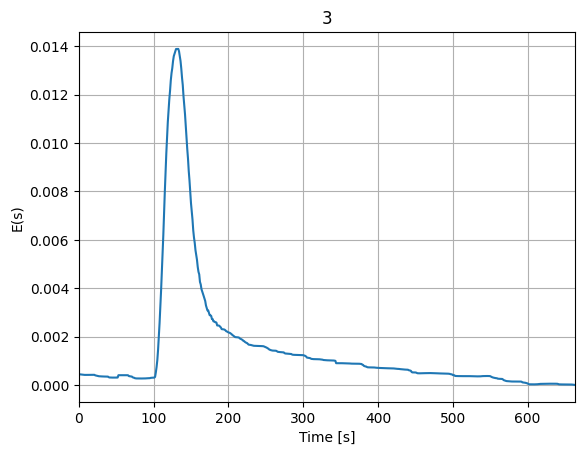

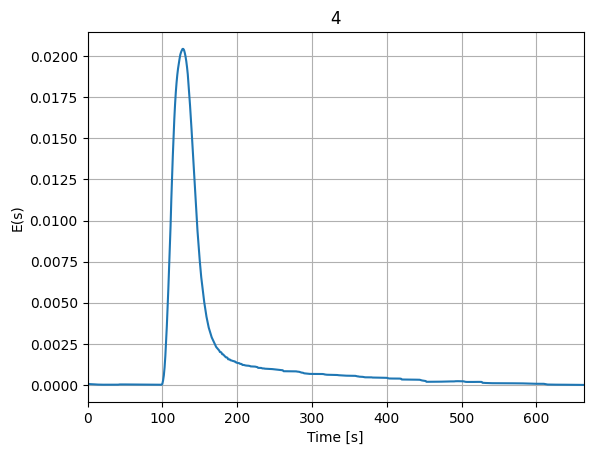

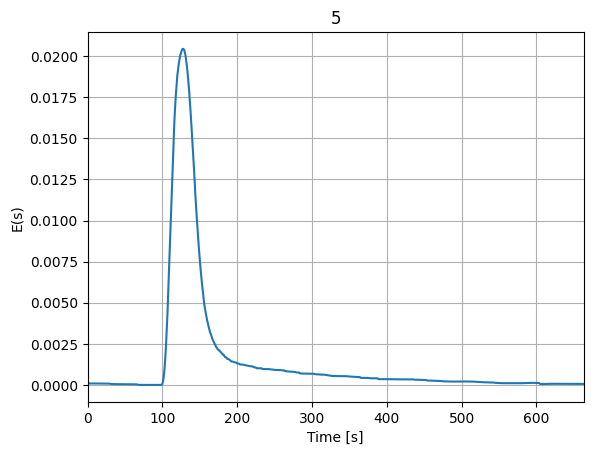

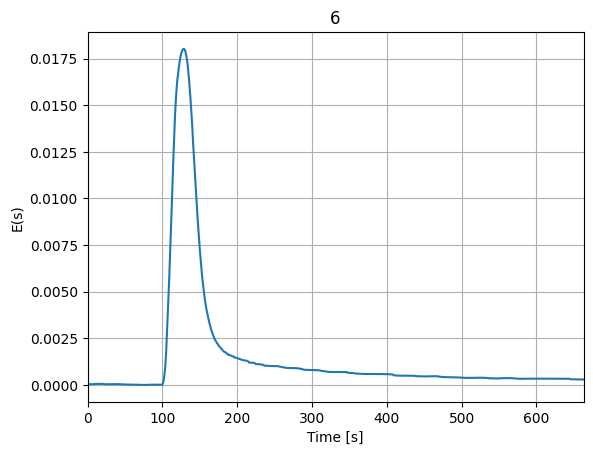

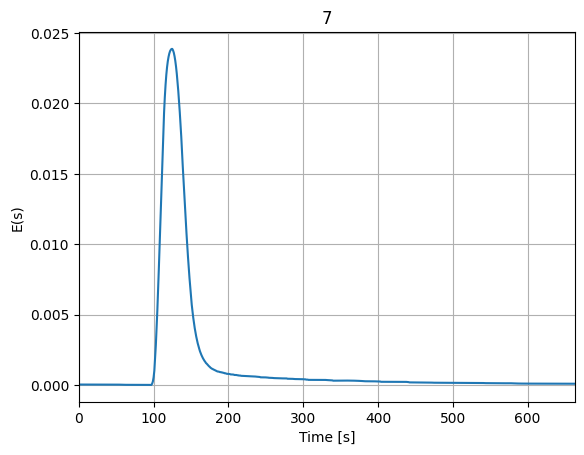

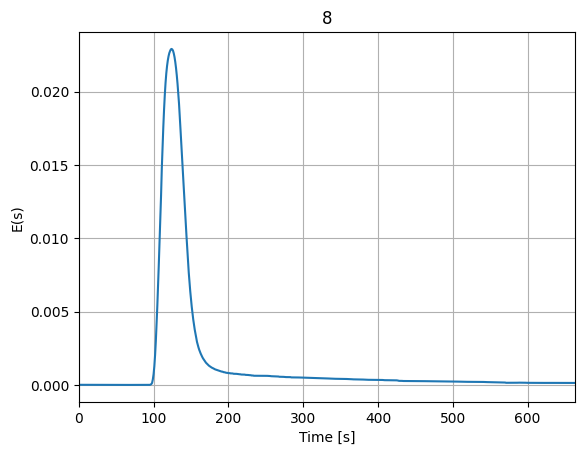

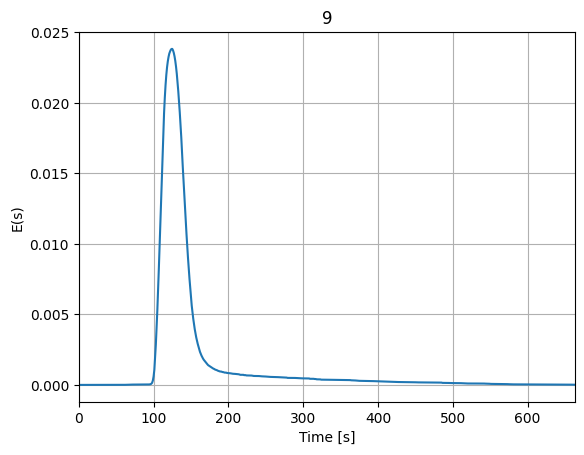

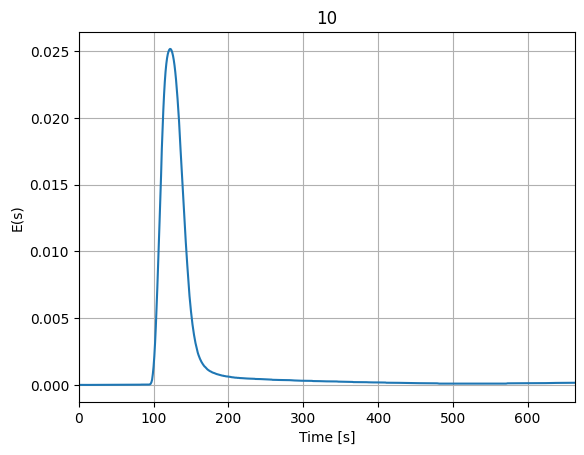

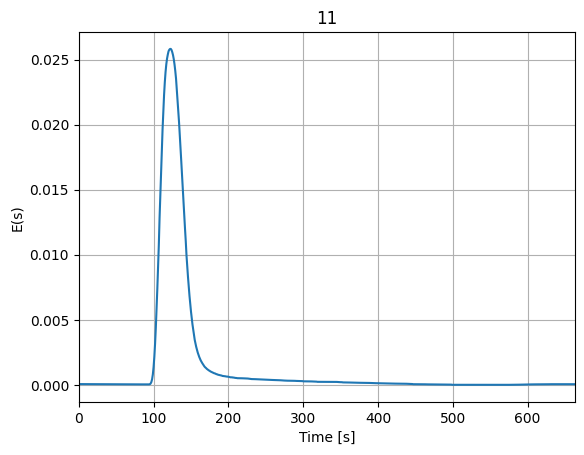

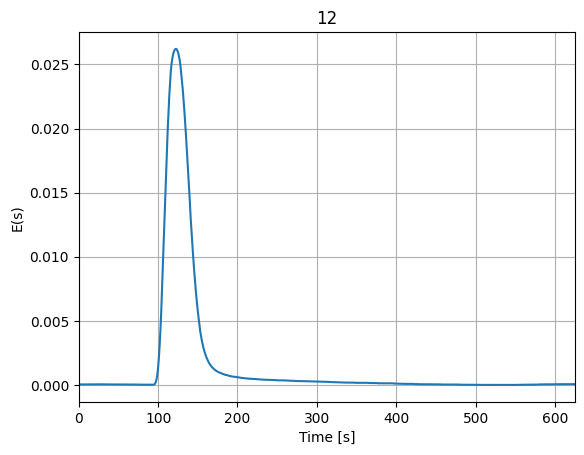

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw3['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == i], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRaw3['Dauer (s) norm'][AxDisRaw3['groups'] == i], AxDisRaw3['CO (ppm)'][AxDisRaw3['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw3['Dauer (s) norm'][AxDisRaw3['groups'] == i], AxDisRaw3['RTD'][AxDisRaw3['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw3['Dauer (s) norm'][AxDisRaw3['groups'] == i].iat[0], right = AxDisRaw3['Dauer (s) norm'][AxDisRaw3['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

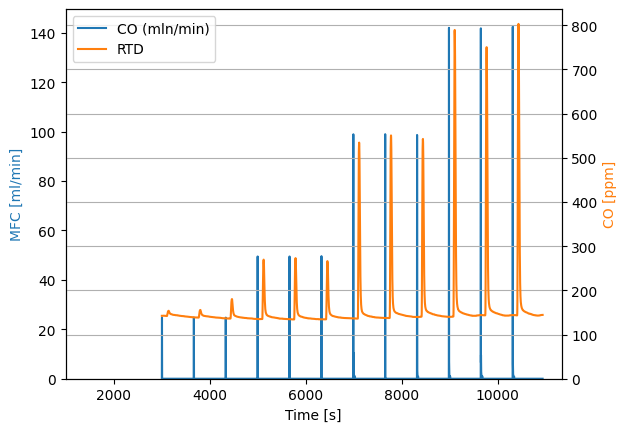

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['MFC CO (mln/min)'], 'tab:blue', label = 'CO (mln/min)')
ax2.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['CO (ppm)'], 'tab:orange', label = 'RTD')

#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 1000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MFC [ml/min]', color = 'tab:blue')
ax2.set_ylabel('CO [ppm]', color ='tab:orange')
plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

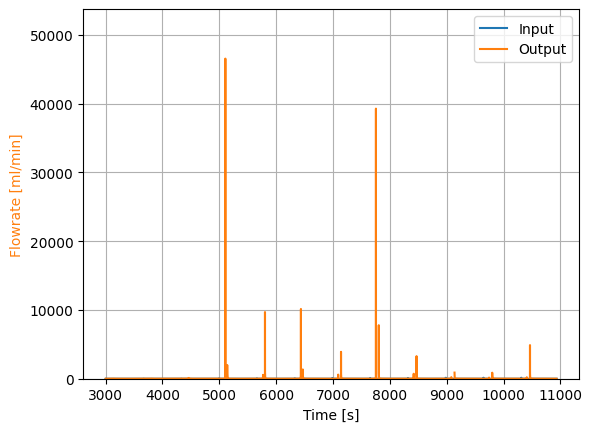

In [ ]:
#@title full hydrogen plot

plt.figure()

plt.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['MFC CO (mln/min)'], 'tab:blue', label = 'Input')
plt.plot(AxDisRaw3['Dauer (s)'], AxDisRaw3['Output CO (mlN/s)']*60, 'tab:orange', label = 'Output')

plt.ylabel('Flowrate [ml/min]', color ='tab:orange')
plt.xlabel('Time [s]')

plt.ylim(bottom = 0)
plt.legend(loc = 'best')
plt.grid()

## Experiment 4

### data manip

In [ ]:
#@title data manip exp4

m_cat_exp4 = 50 #g
L_bed_exp4 = m_cat_exp4/dens_cat/A_R/100

filepath4 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/Rehman Greiner RTD 50g.csv'
AxDisRaw4 = pd.read_csv(filepath4, encoding='unicode_escape', sep=';')

CutoffRaw4 = 3000 #AxDisRaw4.index[(AxDisRaw4['MFC CO (mln/min)'] < 5) & (AxDisRaw4['MFC CO (mln/min)'].shift(-1) > 9)].tolist()[0] - 1
AxDisRaw4 = AxDisRaw4[(AxDisRaw4['Dauer (s)'] < CutoffRaw4)]

# AxDisRaw4['CO (ppm)'] = AxDisRaw4['CO (ppm)'].shift(-analyzer_shift)
# AxDisRaw4 = AxDisRaw4[:-analyzer_shift]

AxDisRaw4['groups'] = 0
AxDisRaw4.loc[(AxDisRaw4['MFC CO (mln/min)'] < 5) & (AxDisRaw4['MFC CO (mln/min)'].shift(-1) > 9), 'groups'] = 1
AxDisRaw4['groups'] = AxDisRaw4['groups'].cumsum()
AxDisRaw4 = AxDisRaw4[AxDisRaw4['groups'] > 0]

AxDisRaw4['CO (ppm) zeroed'] = AxDisRaw4['CO (ppm)'].sub(AxDisRaw4.groupby('groups')['CO (ppm)'].transform('min'))


AxDisRaw4['RTD'] = AxDisRaw4['CO (ppm) zeroed']/AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].transform('sum')
AxDisRaw4['RTD2'] = AxDisRaw4.groupby('groups')['RTD'].transform(pd.Series.cumsum)

min4 = AxDisRaw4.groupby('groups')['Dauer (s)'].transform('min')
AxDisRaw4['Dauer (s) norm'] = AxDisRaw4['Dauer (s)'].sub(min4)

max4 = AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].transform('idxmax')
max42 = AxDisRaw4['Dauer (s) norm'].loc[max4].tolist()
AxDisRaw4['theta'] = AxDisRaw4['Dauer (s) norm']/max42

AxDisRaw4['RTD norm'] = AxDisRaw4['CO (ppm) zeroed']/AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].transform('sum')*max42

CutoffRaw42 = AxDisRaw4.groupby('groups')['Dauer (s)'].transform('min').iat[-1] + 60 * 10
AxDisRaw4 = AxDisRaw4[AxDisRaw4['Dauer (s)'] < CutoffRaw42]

AxDisRaw4['Input (mlN/s)'] = AxDisRaw4['MFC CO (mln/min)'].divide(60)
AxDisRaw4['Input CO (mlN/s)'] = AxDisRaw4['Input (mlN/s)'].multiply(x_CO)
AxDisRaw4['Output (mlN/s)'] = AxDisRaw4['N2-A (ln/min)'].divide(60).divide(1 - AxDisRaw4['CO (ppm) zeroed'] / 100 * x_total).multiply(1000)
AxDisRaw4['Output CO (mlN/s)'] = AxDisRaw4['Output (mlN/s)'] * AxDisRaw4['CO (ppm) zeroed'].divide(100)

InputCOsum4 = AxDisRaw4.groupby('groups')['Input CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsum4 = AxDisRaw4.groupby('groups')['Output CO (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimes4 = AxDisRaw4['Dauer (s) norm'].loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
ResTimes42 = AxDisRaw4.groupby('groups')['MFC CO (mln/min)'].max().tolist()
RTDres4 = pd.DataFrame(np.column_stack([ResTimes42, ResTimes4]), columns = ['MFC CO (mln/min)', 'Residence Time (s)'])

RTDres4['theta'] = AxDisRaw4['theta'].loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres4['theta +1'] = AxDisRaw4['theta'].shift(-5).loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres4['theta -1'] = AxDisRaw4['theta'].shift(5).loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres4['CO'] = AxDisRaw4['RTD2'].loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres4['CO +1'] = AxDisRaw4['RTD2'].shift(-5).loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()
RTDres4['CO -1'] = AxDisRaw4['RTD2'].shift(5).loc[AxDisRaw4.groupby('groups')['CO (ppm) zeroed'].idxmax()].tolist()

RTDres4['slope_top'] = (RTDres4['CO'].sub(RTDres4['CO +1'])).div(RTDres4['theta'].sub(RTDres4['theta +1']))
RTDres4['slope_bottom'] = (RTDres4['CO -1'].sub(RTDres4['CO'])).div(RTDres4['theta -1'].sub(RTDres4['theta']))

RTDres4['Bo_top'] = (2*RTDres4['slope_top'])**2*np.pi
RTDres4['Bo_bottom'] = (2*RTDres4['slope_bottom'])**2*np.pi


RTDres4['Input total (mln/min)'] = RTDres4['MFC CO (mln/min)'] + 1000
RTDres4['Fluid velocity (m/s)'] = RTDres4['Input total (mln/min)'] / 60 / A_R / 100 * 423/273
RTDres4['Calc. Residence Time (s)'] = L_bed_exp4 / (1/0.4 * RTDres4['Fluid velocity (m/s)']) + (0.7 - L_bed_exp1) / RTDres4['Fluid velocity (m/s)'] +  273/423 * dist_pipes1 / (A_F1 * RTDres4['Fluid velocity (m/s)'])
+ dist_pipes2 / (A_F2 * RTDres4['Fluid velocity (m/s)'])

RTDres4['D_ax_top [10^-5 m2/s]'] = L_bed_exp4 * RTDres4['Fluid velocity (m/s)'] / RTDres4['Bo_top'] * 10 ** 5
RTDres4['D_ax_bottom [10^-5 m2/s]'] = L_bed_exp4 * RTDres4['Fluid velocity (m/s)'] / RTDres4['Bo_bottom'] * 10 ** 5

RTDres4['Re'] = 0

for i in range(len(RTDres4)):

    H2 = (RTDres4['MFC CO (mln/min)'].iat[i] * x_H2) / RTDres4['Input total (mln/min)'].iat[i]
    CO = (RTDres4['MFC CO (mln/min)'].iat[i] * x_CO) / RTDres4['Input total (mln/min)'].iat[i]
    CO2 = (RTDres4['MFC CO (mln/min)'].iat[i] * x_CO2) / RTDres4['Input total (mln/min)'].iat[i]

    IZ = np.array([H2, CO, CO2])
    gas_prop = thermo.Mixture(gas_mix_names, zs=IZ, T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDres4['Re'].iat[i] = d_P*RTDres4['Fluid velocity (m/s)'].iat[i]*rhog/mug/0.6

RTDres4pretty = RTDres4[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]

print('Input ml/min :' + str(InputCOsum4))
print('Output ml/min : ' + str(OutputCOsum4))


AxDisRaw4['E*t'] = AxDisRaw4['RTD']*AxDisRaw4['Dauer (s) norm']
AxDisRaw4['E*t^2*dt'] = AxDisRaw4['RTD']*AxDisRaw4['Dauer (s) norm']**2*1
normvar_4 = np.zeros(len(RTDres4pretty['Residence Time (s)']))
mom1_4 = AxDisRaw4.groupby('groups')['E*t'].sum()
mom2_4 = AxDisRaw4.groupby('groups')['E*t^2*dt'].sum()
var2_4 = mom2_4 - mom1_4**2
var1_4 = np.sqrt(var2_4)
for i in range (len(RTDres4pretty['Residence Time (s)'])):
    normvar_4[i] = var1_4[i+1]**2/(RTDres4pretty['Residence Time (s)'].iat[i]**2)

RTDres4['1. Mom.'] = mom1_4
RTDres4pretty = RTDres4[['MFC CO (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


Input ml/min :[0.0405, 0.04406, 0.04578]
Output ml/min : [-555.02454, -2267.9385, 589.13943]


In [ ]:
#@title find bodenstein for exp 3

values_4 = np.zeros(len(normvar_4))

for i in range (len(normvar_4)):
    var_4 = normvar_4 [i]
    initial_guess_4 = [var_4, 1]
    bnds4 = [(var_4, var_4), (0, 150)]

    res_min_4 = minimize(Bodenstein_finder, initial_guess_4, bounds=bnds4)

    values_4[i] = res_min_4.x[1]


<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDres4pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)  \
0            146.96                1146.96                22.0   
1            146.39                1146.39                22.0   
2            146.80                1146.80                22.0   

   Fluid velocity (m/s)  Calc. Residence Time (s)    Bo_top  Bo_bottom  \
0              0.377125                  2.809672  6.662756  25.470602   
1              0.376937                  2.811069  7.151767  19.074395   
2              0.377072                  2.810064  7.347490  22.080235   

   D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]         Re  
0            4448.627894               1163.699264  10.428028  
1            4142.387544               1553.149636  10.422846  
2            4033.484484               1342.195195  10.426574

###plots exp4

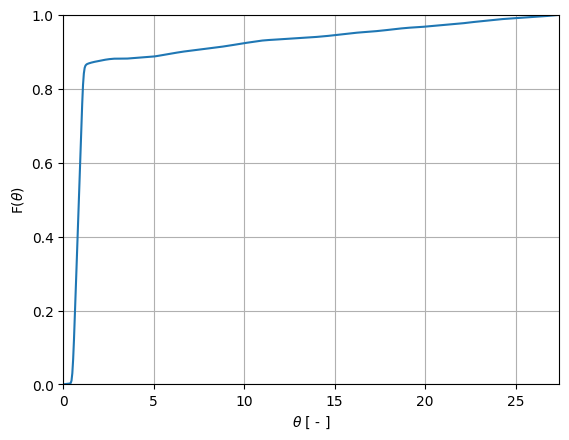

In [ ]:
#@title plot first group


plt.plot(AxDisRaw4['theta'][AxDisRaw4['groups'] == 1], AxDisRaw4['RTD2'][AxDisRaw4['groups'] == 1], label = 'RTD')

plt.xlim(left = AxDisRaw4['theta'][AxDisRaw4['groups'] == 1].iat[0], right = AxDisRaw4['theta'][AxDisRaw4['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

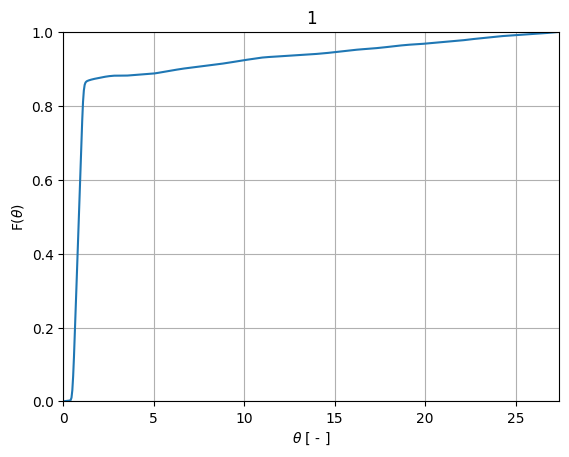

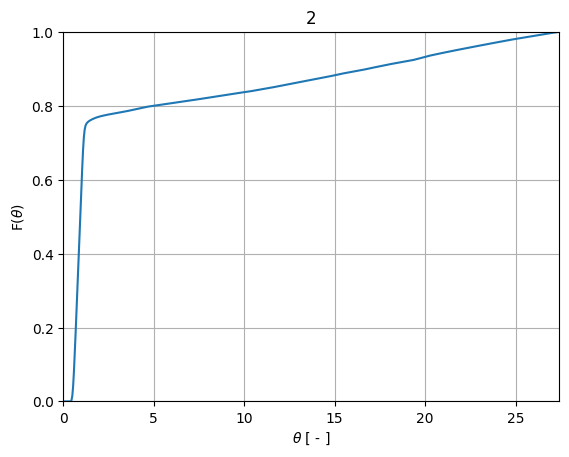

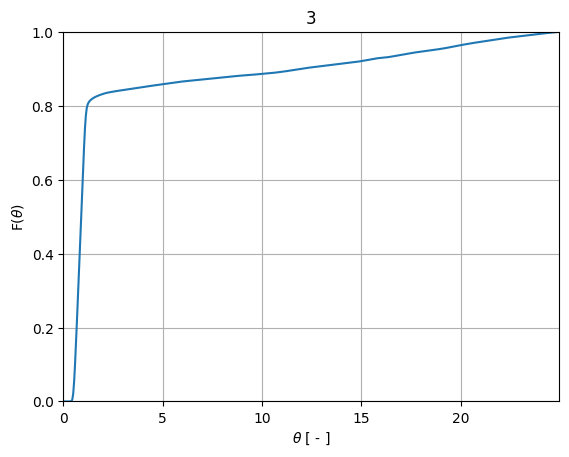

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRaw4['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == i], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRaw4['theta'][AxDisRaw4['groups'] == i], AxDisRaw4['RTD2'][AxDisRaw4['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw4['theta'][AxDisRaw4['groups'] == i].iat[0], right = AxDisRaw4['theta'][AxDisRaw4['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

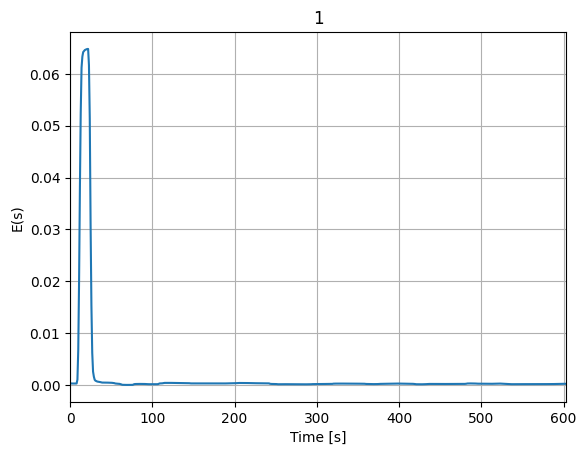

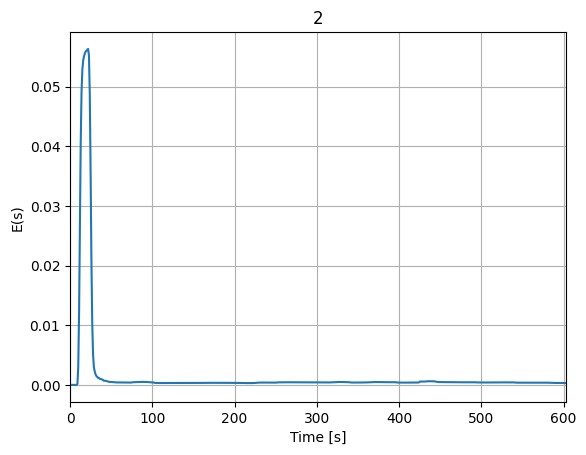

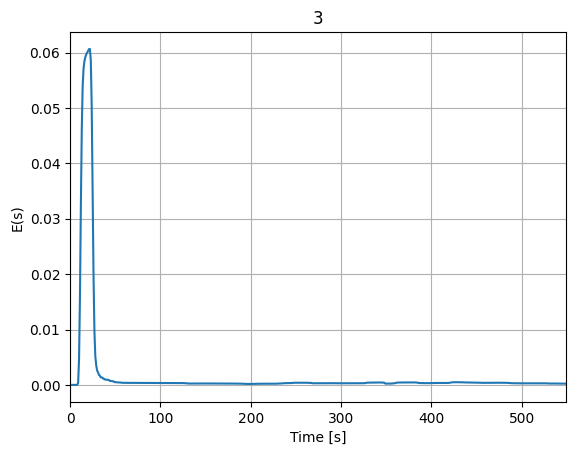

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw4['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == i], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == i], label = 'CO (mln/min)')
    #plt.plot(AxDisRaw4['Dauer (s) norm'][AxDisRaw4['groups'] == i], AxDisRaw4['CO (ppm)'][AxDisRaw4['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw4['Dauer (s) norm'][AxDisRaw4['groups'] == i], AxDisRaw4['RTD'][AxDisRaw4['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw4['Dauer (s) norm'][AxDisRaw4['groups'] == i].iat[0], right = AxDisRaw4['Dauer (s) norm'][AxDisRaw4['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

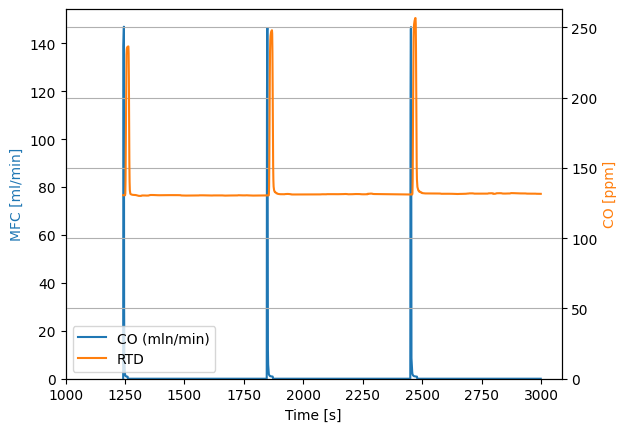

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRaw4['Dauer (s)'], AxDisRaw4['MFC CO (mln/min)'], 'tab:blue', label = 'CO (mln/min)')
ax2.plot(AxDisRaw4['Dauer (s)'], AxDisRaw4['CO (ppm)'], 'tab:orange', label = 'RTD')

#plt.xlim()
ax1.set_ylim(bottom = 0)
ax2.set_ylim(bottom = 0)
ax1.set_xlim(left = 1000)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MFC [ml/min]', color = 'tab:blue')
ax2.set_ylabel('CO [ppm]', color ='tab:orange')
plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

## Experiment 5

### data manip

In [ ]:
#@title data manip exp5

m_cat_exp5 = 5 #g
L_bed_exp5 = m_cat_exp5/dens_cat/A_R/100

filepath5 = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/240513_res_dist_DG.csv'
AxDisRaw5 = pd.read_csv(filepath5, encoding='unicode_escape', sep=';')
AxDisRaw5 = AxDisRaw5[AxDisRaw5['Dauer (s)']<7000]

AxDisRaw5['H2 (Vol%)'] = AxDisRaw5['H2 (Vol%)'].shift(-analyzer_shift)
AxDisRaw5 = AxDisRaw5[:-analyzer_shift]

AxDisRaw5['groups'] = 0
AxDisRaw5.loc[(AxDisRaw5['MFC-4 (mln/min)'] < 5) & (AxDisRaw5['MFC-4 (mln/min)'].shift(-1) > 9), 'groups'] = 1
AxDisRaw5['groups'] = AxDisRaw5['groups'].cumsum()
AxDisRaw5 = AxDisRaw5[AxDisRaw5['groups'] > 0]

AxDisRaw5['H2 (Vol%) zeroed'] = AxDisRaw5['H2 (Vol%)'].sub(AxDisRaw5.groupby('groups')['H2 (Vol%)'].transform('min'))


AxDisRaw5['RTD'] = AxDisRaw5['H2 (Vol%) zeroed']/AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].transform('sum')
AxDisRaw5['RTD2'] = AxDisRaw5.groupby('groups')['RTD'].transform(pd.Series.cumsum)

min5 = AxDisRaw5.groupby('groups')['Dauer (s)'].transform('min')
AxDisRaw5['Dauer (s) norm'] = AxDisRaw5['Dauer (s)'].sub(min5)

max5 = AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].transform('idxmax')
max52 = AxDisRaw5['Dauer (s) norm'].loc[max5].tolist()
AxDisRaw5['theta'] = AxDisRaw5['Dauer (s) norm']/max52

AxDisRaw5['RTD norm'] = AxDisRaw5['H2 (Vol%) zeroed']/AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].transform('sum')*max52

CutoffRaw52 = AxDisRaw5.groupby('groups')['Dauer (s)'].transform('min').iat[-1] + 60 * 10
AxDisRaw5 = AxDisRaw5[AxDisRaw5['Dauer (s)'] < CutoffRaw52]

AxDisRaw5['Input (mlN/s)'] = AxDisRaw5['MFC-4 (mln/min)'].divide(60)
AxDisRaw5['Input H2 (mlN/s)'] = AxDisRaw5['Input (mlN/s)'].multiply(x_H2)
AxDisRaw5['Output (mlN/s)'] = AxDisRaw5['MFC-3 (mln/min)'].divide(60).divide(1 - AxDisRaw5['H2 (Vol%) zeroed'] / 100 * x_total)
AxDisRaw5['Output H2 (mlN/s)'] = AxDisRaw5['Output (mlN/s)'] * AxDisRaw5['H2 (Vol%) zeroed'].divide(100)

InputCOsum5 = AxDisRaw5.groupby('groups')['Input H2 (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()
OutputCOsum5 = AxDisRaw5.groupby('groups')['Output H2 (mlN/s)'].sum().apply(lambda x: round(x, 5)).tolist()

# residence times in seconds

ResTimes5 = AxDisRaw5['Dauer (s) norm'].loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()
ResTimes52 = AxDisRaw5.groupby('groups')['MFC-4 (mln/min)'].max().tolist()
RTDres5 = pd.DataFrame(np.column_stack([ResTimes52, ResTimes5]), columns = ['MFC-4 (mln/min)', 'Residence Time (s)'])

RTDres5['theta'] = AxDisRaw5['theta'].loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()
RTDres5['theta +1'] = AxDisRaw5['theta'].shift(-5).loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()
RTDres5['theta -1'] = AxDisRaw5['theta'].shift(5).loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()

RTDres5['H2'] = AxDisRaw5['RTD2'].loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()
RTDres5['H2 +1'] = AxDisRaw5['RTD2'].shift(-5).loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()
RTDres5['H2 -1'] = AxDisRaw5['RTD2'].shift(5).loc[AxDisRaw5.groupby('groups')['H2 (Vol%) zeroed'].idxmax()].tolist()

RTDres5['slope_top'] = (RTDres5['H2'].sub(RTDres5['H2 +1'])).div(RTDres5['theta'].sub(RTDres5['theta +1']))
RTDres5['slope_bottom'] = (RTDres5['H2 -1'].sub(RTDres5['H2'])).div(RTDres5['theta -1'].sub(RTDres5['theta']))

RTDres5['Bo_top'] = (2*RTDres5['slope_top'])**2*np.pi
RTDres5['Bo_bottom'] = (2*RTDres5['slope_bottom'])**2*np.pi


RTDres5['Input total (mln/min)'] = RTDres5['MFC-4 (mln/min)'] + 1000
RTDres5['Fluid velocity (m/s)'] = RTDres5['Input total (mln/min)'] / 60 / A_R / 100 * 423/273
RTDres5['Calc. Residence Time (s)'] = L_bed_exp5 / (1/0.4 * RTDres5['Fluid velocity (m/s)']) + (0.7 - L_bed_exp1) / RTDres5['Fluid velocity (m/s)'] +  273/423 * dist_pipes1 / (A_F1 * RTDres5['Fluid velocity (m/s)'])
+ dist_pipes2 / (A_F2 * RTDres5['Fluid velocity (m/s)'])

RTDres5['D_ax_top [10^-5 m2/s]'] = L_bed_exp5 * RTDres5['Fluid velocity (m/s)'] / RTDres5['Bo_top'] * 10 ** 5
RTDres5['D_ax_bottom [10^-5 m2/s]'] = L_bed_exp5 * RTDres5['Fluid velocity (m/s)'] / RTDres5['Bo_bottom'] * 10 ** 5

RTDres5['Re'] = 0

for i in range(len(RTDres5)):

    H2 = (RTDres5['MFC-4 (mln/min)'].iat[i] * x_H2) / RTDres5['Input total (mln/min)'].iat[i]
    # CO = (RTDres5['MFC-5 (mln/min)'].iat[i] * x_CO) / RTDres5['Input total (mln/min)'].iat[i]
    # CO2 = (RTDres5['MFC-5 (mln/min)'].iat[i] * x_CO2) / RTDres5['Input total (mln/min)'].iat[i]

    gas_prop = thermo.Mixture('hydrogen', T=423, P=1E5)
    mug = gas_prop.mug
    rhog = gas_prop.rhog

    RTDres5['Re'].iat[i] = d_P*RTDres5['Fluid velocity (m/s)'].iat[i]*rhog/mug/0.6

RTDres5pretty = RTDres5[['MFC-4 (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]

print('Input ml/min :' + str(InputCOsum5))
print('Output ml/min : ' + str(OutputCOsum5))


AxDisRaw5['E*t'] = AxDisRaw5['RTD']*AxDisRaw5['Dauer (s) norm']
AxDisRaw5['E*t^2*dt'] = AxDisRaw5['RTD']*AxDisRaw5['Dauer (s) norm']**2*1
normvar_5 = np.zeros(len(RTDres5pretty['Residence Time (s)']))
mom1_5 = AxDisRaw5.groupby('groups')['E*t'].sum()
mom2_5 = AxDisRaw5.groupby('groups')['E*t^2*dt'].sum()
var2_5 = mom2_5 - mom1_5**2
var1_5 = np.sqrt(var2_5)
for i in range (len(RTDres5pretty['Residence Time (s)'])):
    normvar_5[i] = var1_5[i+1]**2/(RTDres5pretty['Residence Time (s)'].iat[i]**2)

RTDres5['1. Mom.'] = mom1_5
RTDres5pretty = RTDres5[['MFC-4 (mln/min)', 'Input total (mln/min)', 'Residence Time (s)', '1. Mom.', 'Fluid velocity (m/s)', 'Calc. Residence Time (s)', 'Bo_top', 'Bo_bottom', 'D_ax_top [10^-5 m2/s]', 'D_ax_bottom [10^-5 m2/s]', 'Re']]


Input ml/min :[0.55949, 0.56247, 0.42999, 3.2189, 3.19742]
Output ml/min : [0.96698, 0.77053, 0.88918, 4.84857, 6.27662]


In [ ]:
#@title find bodenstein for exp 5

values_5 = np.zeros(len(normvar_5))

for i in range (len(normvar_5)):
    var_5 = normvar_5 [i]
    initial_guess_5 = [var_5, 1]
    bnds5 = [(var_5, var_5), (0, 150)]

    res_min_5 = minimize(Bodenstein_finder, initial_guess_5, bounds=bnds5)

    values_5[i] = res_min_5.x[1]


<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: divide by zero encountered in scalar divide
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2
<ipython-input-6-0e6d1abfb6c7>:6: RuntimeWarning: invalid value encountered in scalar multiply
  res = (var - (2/Bo - 2/(Bo**2)*(1-np.exp(-Bo))))**2


In [ ]:
#@title Residence time results

RTDres5pretty

MFC-4 (mln/min)  Input total (mln/min)  Residence Time (s)     1. Mom.  \
0            12.45                1012.45                63.0         NaN   
1            11.59                1011.59                70.0  166.651273   
2            11.66                1011.66               106.0  157.719027   
3            80.33                1080.33                62.0  213.616348   
4            78.56                1078.56                61.0  113.438434   

   Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
0              0.332897                  2.333015   1.574334   1.578823   
1              0.332614                  2.334998   2.064941   2.070028   
2              0.332637                  2.334837   3.471496   3.477309   
3              0.355216                  2.186425  17.962566  18.213436   
4              0.354634                  2.190013  23.012585  22.709396   

   D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]        Re  
0            1661.913429               1657.187808  2.804347  
1            1265.984815               1262.873938  2.801965  
2             753.094819                751.835687  2.802159  
3             155.424601                153.283796  2.992366  
4             121.118534                122.735561  2.987463

###plots exp5

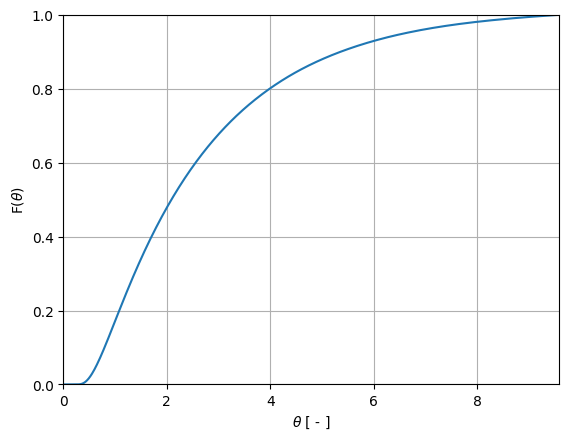

In [ ]:
#@title plot first group


plt.plot(AxDisRaw5['theta'][AxDisRaw5['groups'] == 1], AxDisRaw5['RTD2'][AxDisRaw5['groups'] == 1], label = 'RTD')

plt.xlim(left = AxDisRaw5['theta'][AxDisRaw5['groups'] == 1].iat[0], right = AxDisRaw5['theta'][AxDisRaw5['groups'] == 1].iat[-1])
plt.ylim(bottom = 0, top = 1)
plt.xlabel(r"$\theta$ [ - ]")
plt.ylabel('F(' + r'$\theta$)')
plt.grid()

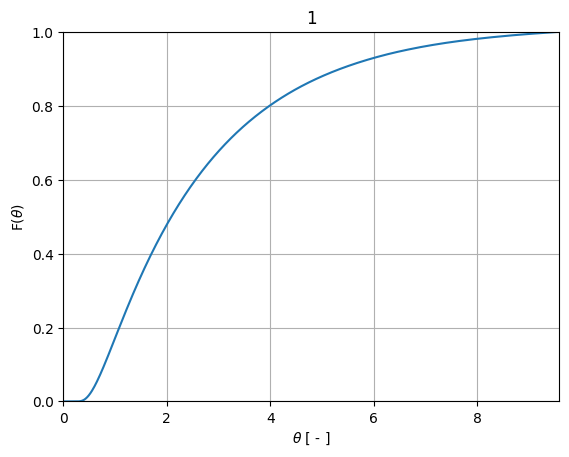

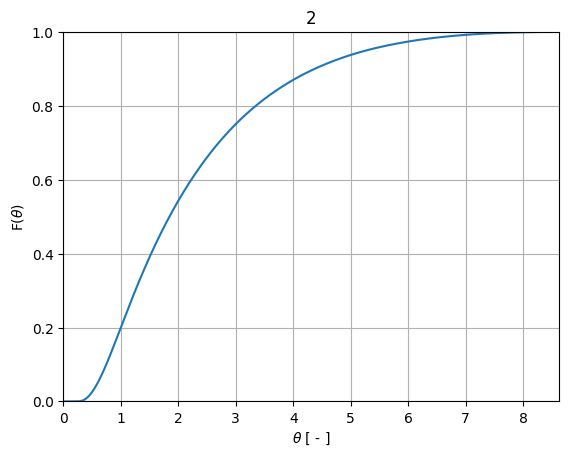

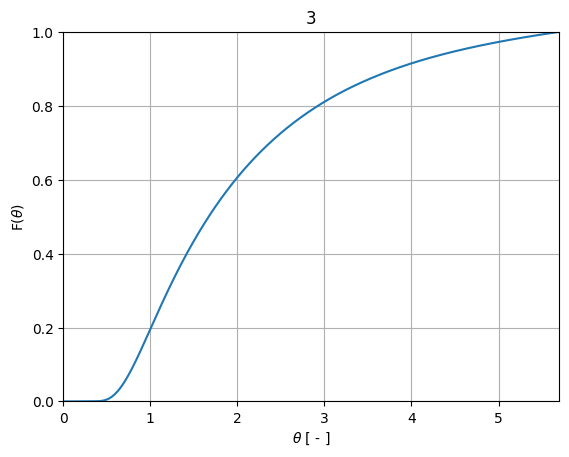

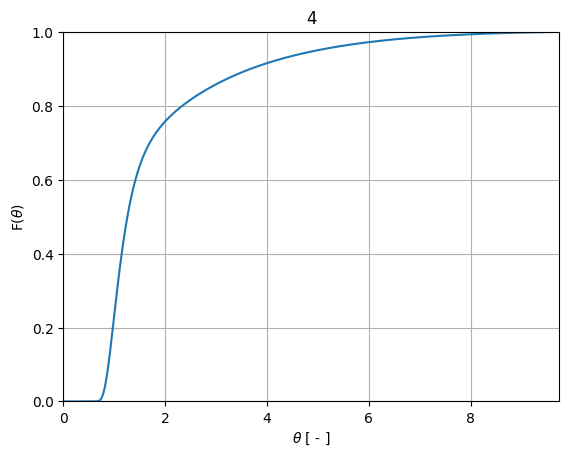

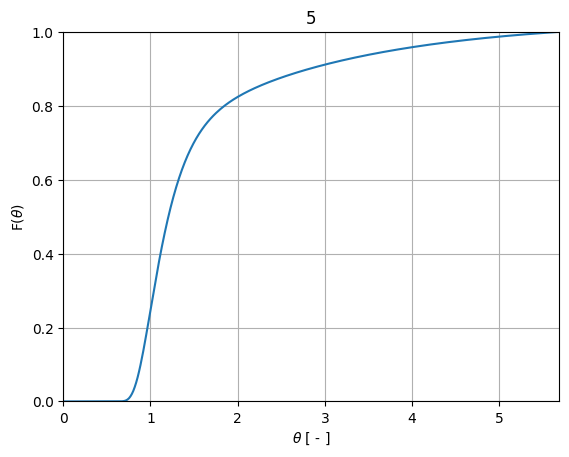

In [ ]:
#@title plot all groups seperately

for i in range (1, AxDisRaw5['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)
    #plt.plot(AxDisRaw3['Dauer (s)'][AxDisRaw3['groups'] == i], AxDisRaw3['MFC CO (mln/min)'][AxDisRaw3['groups'] == i], label = 'CO (mln/min)')
    plt.plot(AxDisRaw5['theta'][AxDisRaw5['groups'] == i], AxDisRaw5['RTD2'][AxDisRaw5['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw5['theta'][AxDisRaw5['groups'] == i].iat[0], right = AxDisRaw5['theta'][AxDisRaw5['groups'] == i].iat[-1])
    plt.ylim(bottom = 0, top = 1)
    plt.xlabel(r"$\theta$ [ - ]")
    plt.ylabel('F(' + r'$\theta$)')
    plt.grid()

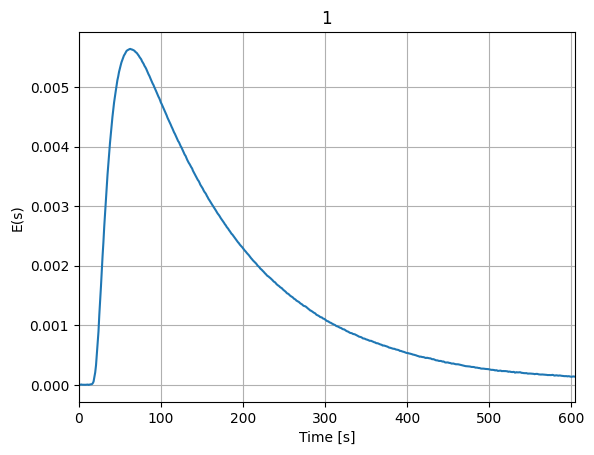

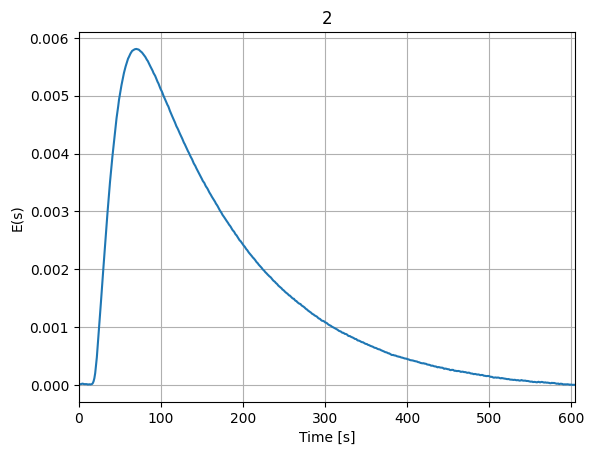

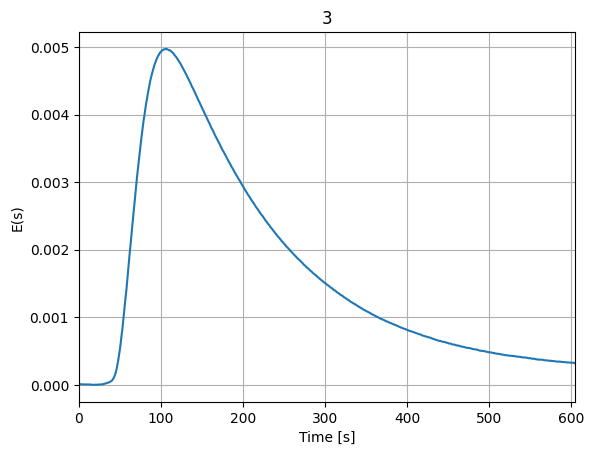

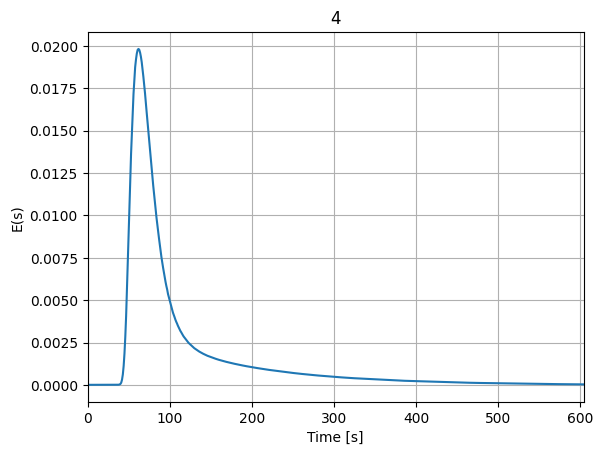

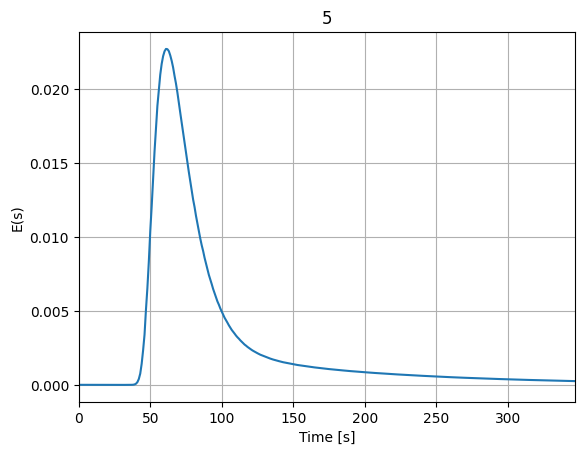

In [ ]:
#@title plot all groups seperately Vol%

for i in range (1, AxDisRaw5['groups'].iat[-1] + 1):

    plt.figure(i)
    plt.title(i)

    #plt.plot(AxDisRaw5['Dauer (s) norm'][AxDisRaw5['groups'] == i], AxDisRaw5['CO (ppm)'][AxDisRaw5['groups'] == i], label = 'RTD')
    plt.plot(AxDisRaw5['Dauer (s) norm'][AxDisRaw5['groups'] == i], AxDisRaw5['RTD'][AxDisRaw5['groups'] == i], label = 'RTD')

    plt.xlim(left = AxDisRaw5['Dauer (s) norm'][AxDisRaw5['groups'] == i].iat[0], right = AxDisRaw5['Dauer (s) norm'][AxDisRaw5['groups'] == i].iat[-1])
    #plt.ylim(bottom = 0)
    #plt.xlabel(r"$\theta$ [ - ]")
    plt.xlabel("Time [s]")
    #plt.ylabel('E(' + r'$\theta$)')
    plt.ylabel('E(s)')
    plt.grid()

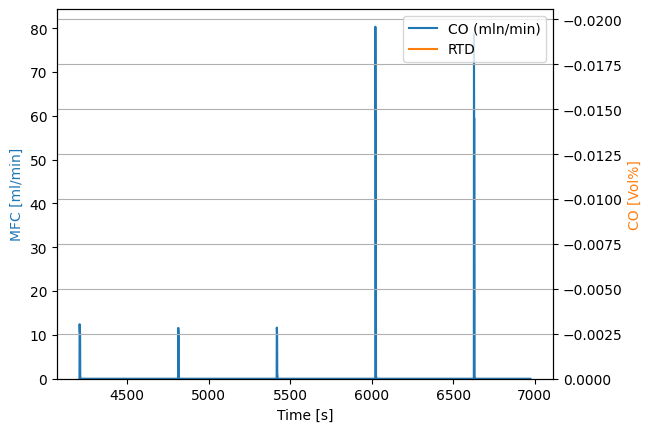

In [ ]:
#@title full

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(AxDisRaw5['Dauer (s)'], AxDisRaw5['MFC-4 (mln/min)'], 'tab:blue', label = 'CO (mln/min)')
ax2.plot(AxDisRaw5['Dauer (s)'], AxDisRaw5['CO (Vol%)'], 'tab:orange', label = 'RTD')

#plt.xlim()
ax1.set_ylim(0,)
ax2.set_ylim(0,)
ax1.set_xlim()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('MFC [ml/min]', color = 'tab:blue')
ax2.set_ylabel('CO [Vol%]', color ='tab:orange')
plt.grid()

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='best')

#plt.show()

# Peclet finder


## functions

In [ ]:
N_Casc = 3

In [ ]:
def Peclet_finder (Peclet, groups_int, df):

    rtd_delta = df[df['groups'] == groups_int]['theta'].iat[1] - df[df['groups'] == groups_int]['theta'].iat[0]
    rtd_max = df[df['groups'] == groups_int]['theta'].max() + rtd_delta/2
    a = rtdpy.AD_cc(tau=1, peclet=Peclet, dt=rtd_delta, time_end=rtd_max)

    if len(a.exitage) - len(df[df['groups'] == groups_int]['RTD norm']) == 0:
        QS = ((a.exitage - df[df['groups'] == groups_int]['RTD norm'])**2).sum()
    else:
        QS = 0

    return QS

In [ ]:
def Peclet_finder_oo (Peclet, groups_int, df):

    rtd_delta = df[df['groups'] == groups_int]['theta'].iat[1] - df[df['groups'] == groups_int]['theta'].iat[0]
    rtd_max = df[df['groups'] == groups_int]['theta'].max() + rtd_delta/2
    a = rtdpy.AD_oo(tau=1, peclet=Peclet, dt=rtd_delta, time_end=rtd_max)

    if len(a.exitage) - len(df[df['groups'] == groups_int]['RTD norm']) == 0:
        QS = ((a.exitage - df[df['groups'] == groups_int]['RTD norm'])**2).sum()
    else:
        QS = 0

    return QS

In [ ]:
def Peclet_finder_casc (Peclet, groups_int, df):

    rtd_delta = df[df['groups'] == groups_int]['theta'].iat[1] - df[df['groups'] == groups_int]['theta'].iat[0]
    rtd_max = df[df['groups'] == groups_int]['theta'].max() + rtd_delta/2
    #a = rtdpy.AD_cc(tau=1, peclet=Peclet, dt=rtd_delta, time_end=rtd_max)
    a = rtdpy.Ncstr(tau=1, n=N_Casc, dt=rtd_delta, time_end=rtd_max)

    if len(a.exitage) - len(df[df['groups'] == groups_int]['RTD norm']) == 0:
        QS = ((a.exitage - df[df['groups'] == groups_int]['RTD norm'])**2).sum()
    else:
        QS = 0

    return QS

In [ ]:
def Peclet (df):

    values_pec = np.zeros(df['groups'].iat[-1])

    for i in range (1, df['groups'].iat[-1]+1):

        initial_guess = [5]
        bnds = [(0.000005, 100)]

        res = minimize(Peclet_finder, args=(i, df), x0 = initial_guess, bounds=bnds)

        values_pec[i-1] = round(res.x[0],2)
    return values_pec

In [ ]:
def Peclet_oo (df):

    values_pec = np.zeros(df['groups'].iat[-1])

    for i in range (1, df['groups'].iat[-1]+1):

        initial_guess = [5]
        bnds = [(0.000005, 100)]

        res = minimize(Peclet_finder_oo, args=(i, df), x0 = initial_guess, bounds=bnds)

        values_pec[i-1] = round(res.x[0],2)
    return values_pec

In [ ]:
def Peclet_casc (df):

    values_pec = np.zeros(df['groups'].iat[-1])

    for i in range (1, df['groups'].iat[-1]+1):

        initial_guess = [5]
        bnds = [(0, 100)]

        res = minimize(Peclet_finder_casc, args=(i, df), x0 = initial_guess, bounds=bnds)

        values_pec[i-1] = round(res.x[0],2)
    return values_pec

In [ ]:
def Peclet_Plotter(df, results):
    for i in range(1, df['groups'].iat[-1] + 1):
        Peclet = results[i-1]
        rtd_delta = df[df['groups'] == i]['theta'].iat[1] - df[df['groups'] == i]['theta'].iat[0]
        rtd_max = df[df['groups'] == i]['theta'].max() + rtd_delta/2
        a = rtdpy.AD_cc(tau=1, peclet=Peclet, dt=rtd_delta, time_end=rtd_max)

        plt.figure(i)
        plt.plot(a.time, a.exitage, label=f"peclet = {Peclet}")
        plt.plot(df[df['groups'] == i]['theta'], df[df['groups'] == i]['RTD norm'], label = 'experimental data')
        plt.xlim(0,)
        plt.ylim(0,)
        plt.xlabel(r"$\theta$ [ - ]")
        plt.ylabel('E(' + r'$\theta$)')
        plt.legend(loc='best')
        plt.show
    return

In [ ]:
def Peclet_Plotter_casc(df, results):
    for i in range(1, df['groups'].iat[-1] + 1):

        rtd_delta = df[df['groups'] == i]['theta'].iat[1] - df[df['groups'] == i]['theta'].iat[0]
        rtd_max = df[df['groups'] == i]['theta'].max() + rtd_delta/2
        a = rtdpy.Ncstr(tau=1, n=N_Casc, dt=rtd_delta, time_end=rtd_max)

        plt.figure(i)
        plt.plot(a.time, a.exitage, label=f"N in Cascade = {N_Casc}")
        plt.plot(df[df['groups'] == i]['theta'], df[df['groups'] == i]['RTD norm'], label = 'experimental data')
        plt.legend(loc='best')
        plt.xlabel(r"$\theta$ [ - ]")
        plt.ylabel('E(' + r'$\theta$)')
        plt.xlim(0,)
        plt.ylim(0,)
        plt.show
    return

## determine peclet numbers for experiments

In [ ]:
Peclet_Results1 = Peclet(AxDisRaw1)

In [ ]:
Peclet_Results2 = Peclet(AxDisRaw2)

In [ ]:
Peclet_Results3 = Peclet(AxDisRaw3)

In [ ]:
Peclet_Results4 = Peclet(AxDisRaw4)

In [ ]:
Peclet_Results5 = Peclet(AxDisRaw5)

## determine peclet numbers for experiments bypass

In [ ]:
Peclet_ResultsBP1 = Peclet(AxDisRawBP1)

In [ ]:
Peclet_ResultsBP2 = Peclet(AxDisRawBP2)

In [ ]:
Peclet_ResultsBP1_oo = Peclet_oo(AxDisRawBP1)

In [ ]:
Peclet_ResultsBP2_oo = Peclet_oo(AxDisRawBP2)

## determine peclet numbers for experiments (cascade)

In [ ]:
Peclet_Results1_casc = Peclet_casc(AxDisRaw1)

In [ ]:
Peclet_Results2_casc = Peclet_casc(AxDisRaw2)

In [ ]:
Peclet_Results3_casc = Peclet_casc(AxDisRaw3)

In [ ]:
Peclet_Results4_casc = Peclet_casc(AxDisRaw4)

In [ ]:
Peclet_Results5_casc = Peclet_casc(AxDisRaw5)

## Bodenstein numbers

In [ ]:
#@title calculate Bodenstein numbers

Bo1 = Peclet_Results1 * d_P / L_bed_exp1
Dax1 = RTDres1pretty['Fluid velocity (m/s)'] * d_P / Peclet_Results1 * 10**5
Bo2 = Peclet_Results2 * d_P / L_bed_exp2
Dax2 = RTDres2pretty['Fluid velocity (m/s)'] * d_P / Peclet_Results2 * 10**5
#Bo3 = Peclet_Results3 * d_P / L_bed_exp3
#Dax3 = RTDres3pretty['Fluid velocity (m/s)'] * d_P / Peclet_Results3 * 10**5
Bo4 = Peclet_Results4 * d_P / L_bed_exp4
Dax4 = RTDres4pretty['Fluid velocity (m/s)'] * d_P / Peclet_Results4 * 10**5

In [ ]:
Peclet_Results2

array([ 6.24, 10.06, 51.75, 50.45, 51.87, 82.04, 90.93, 94.44, 90.32,
       97.54, 96.  , 95.1 , 98.55,  2.96])

In [ ]:
RTDres2pretty

MFC CO (mln/min)  Input total (mln/min)  Residence Time (s)     1. Mom.  \
1              10.65                 110.65               131.0  180.231838   
2              10.35                 110.35               125.0  209.202299   
3              24.76                 124.76               111.0  172.998866   
4              25.07                 125.07               110.0  174.134641   
5              24.74                 124.74               111.0  168.951317   
6              49.59                 149.59               105.0  145.767993   
7              49.46                 149.46               106.0  132.021356   
8              49.57                 149.57               106.0  128.809866   
9              98.90                 198.90               102.0  137.062895   
10             98.92                 198.92               102.0  126.461831   
11             99.12                 199.12               102.0  127.589257   
12            142.73                 242.73               100.0  124.806167   
13            142.60                 242.60               101.0  124.799884   
14            142.17                 242.17               100.0   64.450460   

    Fluid velocity (m/s)  Calc. Residence Time (s)     Bo_top  Bo_bottom  \
1               0.036382                 22.557076   9.400423   9.465721   
2               0.036283                 22.618400  11.979308  11.902234   
3               0.041022                 20.005935  38.528981  40.249257   
4               0.041123                 19.956348  37.637850  38.880920   
5               0.041015                 20.009143  37.949021  41.323549   
6               0.049186                 16.685209  61.235057  63.010815   
7               0.049143                 16.699722  70.364568  73.208249   
8               0.049179                 16.687441  74.168967  77.041013   
9               0.065399                 12.548720  68.158862  69.691550   
10              0.065406                 12.547459  75.913295  77.521871   
11              0.065471                 12.534856  74.202412  76.761733   
12              0.079811                 10.282785  74.026932  75.408769   
13              0.079768                 10.288295  76.598349  78.863750   
14              0.079626                 10.306564   5.855476   5.920277   

    D_ax_top [10^-5 m2/s]  D_ax_bottom [10^-5 m2/s]        Re  
1               73.010745                 72.507086  1.006017  
2               57.137776                 57.507780  1.003290  
3               20.084942                 19.226501  1.134304  
4               20.611570                 19.952594  1.137122  
5               20.388624                 18.723666  1.134122  
6               15.152531                 14.725505  1.360055  
7               13.175093                 12.663324  1.358873  
8               12.508493                 12.042184  1.359873  
9               18.100693                 17.702614  1.808376  
10              16.253367                 15.916111  1.808558  
11              16.644839                 16.089882  1.810376  
12              20.338384                 19.965691  2.206873  
13              19.645095                 19.080780  2.205691  
14             256.531590                253.723734  2.201782

In [ ]:
#@title create dataframes

data_bodenstein1 = {'Flow rate mlN/min': RTDres1pretty['MFC CO (mln/min)'], 'Peclet': Peclet_Results1/10, 'Dax m2/s * 10^5': Dax1, 'Bodenstein': Bo1, 'Original Bo': RTDres1pretty['Bo_top']}
Bodenstein_numbers1 = pd.DataFrame(data=data_bodenstein1)

data_bodenstein2 = {'Flow rate mlN/min': RTDres2pretty['MFC CO (mln/min)'], 'Peclet': Peclet_Results2, 'Dax m2/s * 10^5': Dax2, 'Bodenstein': Bo2, 'Original Bo': RTDres2pretty['Bo_top']}
Bodenstein_numbers2 = pd.DataFrame(data=data_bodenstein2)

# data_bodenstein3 = {'Flow rate mlN/min': RTDres3pretty['MFC CO (mln/min)'], 'Peclet': Peclet_Results3, 'Dax m2/s * 10^5': Dax3, 'Bodenstein': [Bo3], 'Original Bo': RTDres3pretty['Bo_top']}
# Bodenstein_numbers3 = pd.DataFrame(data=data_bodenstein3)

data_bodenstein4 = {'Flow rate mlN/min': RTDres4pretty['MFC CO (mln/min)'], 'Peclet': Peclet_Results4, 'Dax m2/s * 10^5': Dax4, 'Bodenstein': Bo4, 'Original Bo': RTDres4pretty['Bo_top']}
Bodenstein_numbers4 = pd.DataFrame(data=data_bodenstein4)

In [ ]:
Bodenstein_numbers1

Flow rate mlN/min  Peclet  Dax m2/s * 10^5  Bodenstein  Original Bo
0               25.20   3.466         0.118772    0.440413    27.264474
1               24.81   5.514         0.074425    0.700646    39.401168
2               25.18   5.627         0.073147    0.715005    40.472849
3               49.57   6.677         0.073655    0.848425    48.603814
4               49.46   7.343         0.066925    0.933051    53.278724
5               49.57   6.875         0.071533    0.873584    49.975413
6               98.68   8.152         0.080136    1.035848    60.279543
7               98.92   0.500         1.308112    0.063533    46.010666
8               99.14   8.485         0.077169    1.078162    66.342663
9              142.80   9.791         0.081538    1.244111    78.815048
10             142.23   9.815         0.081147    1.247160    78.153800
11             142.67   9.568         0.083393    1.215775    75.669669

# plots

### bypass


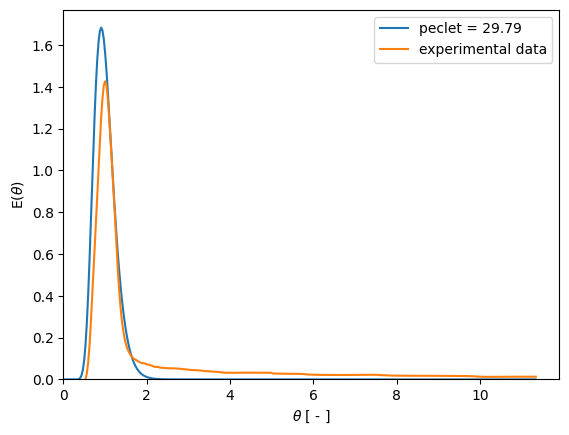

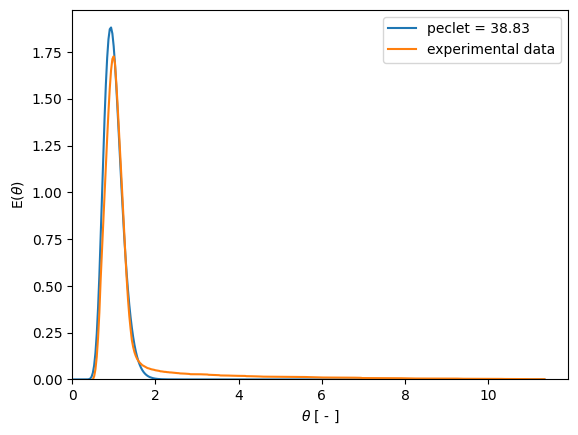

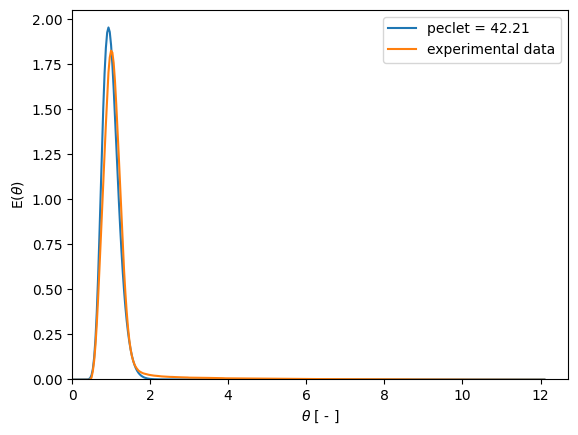

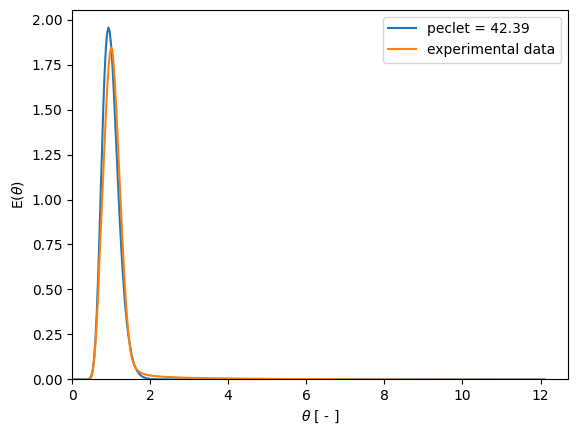

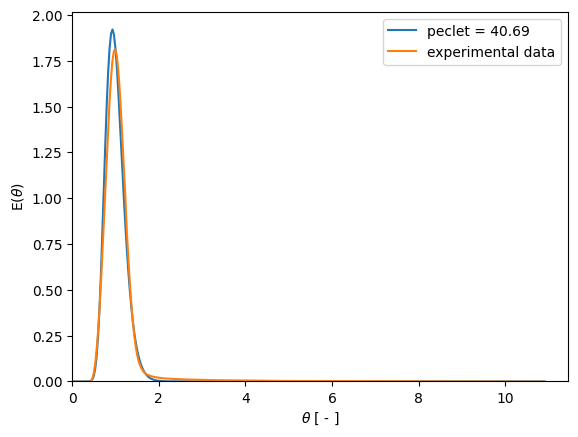

In [ ]:
#@title plotting 1

Peclet_Plotter(AxDisRawBP1, Peclet_ResultsBP1)

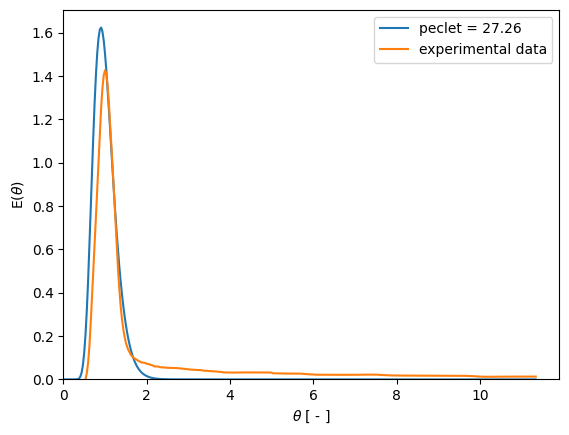

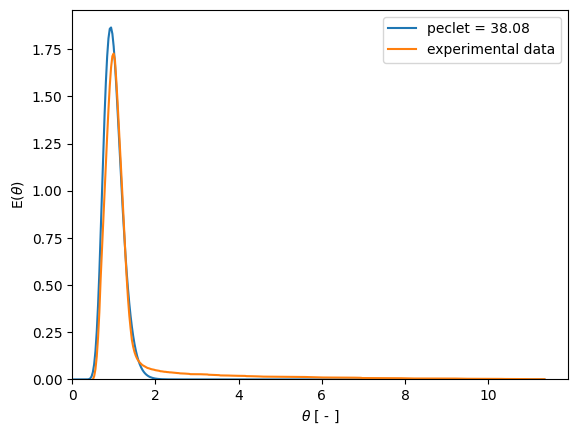

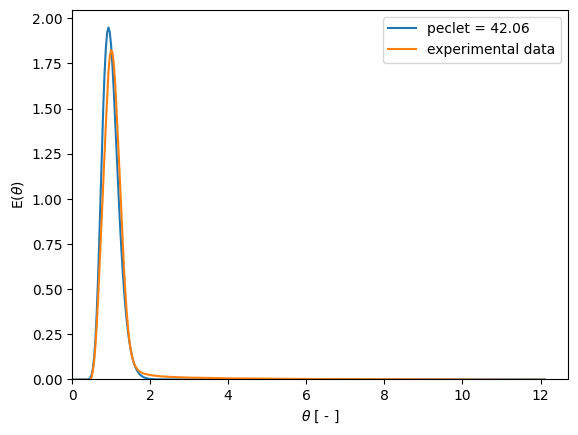

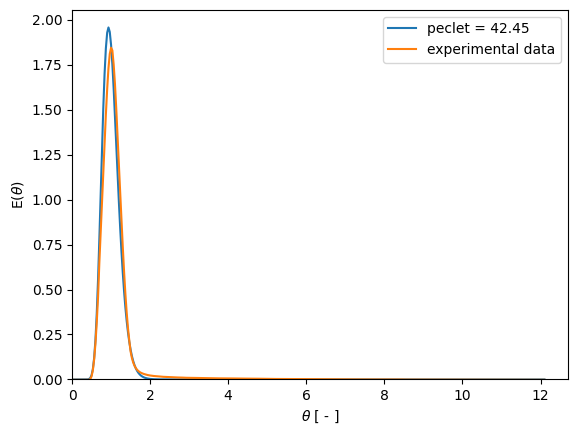

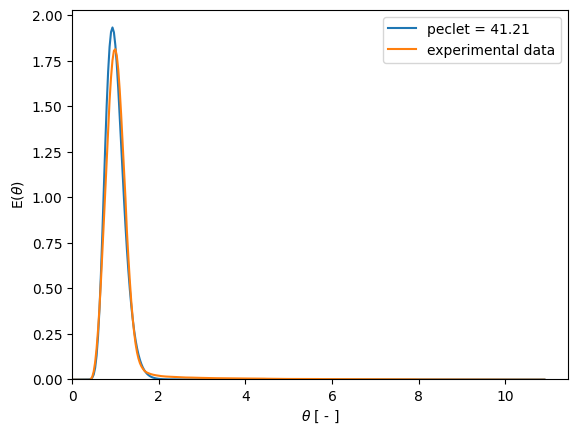

In [ ]:
#@title plotting 1 oo

Peclet_Plotter(AxDisRawBP1, Peclet_ResultsBP1_oo)

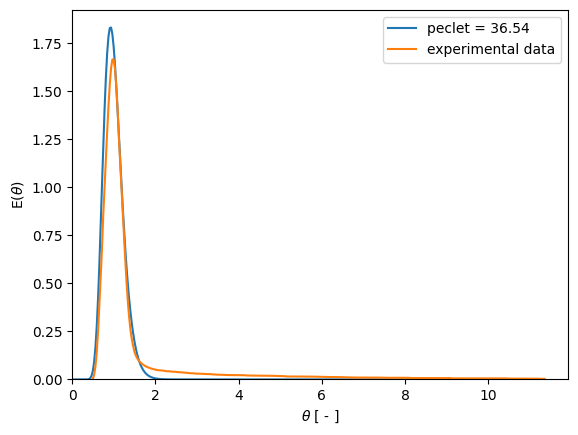

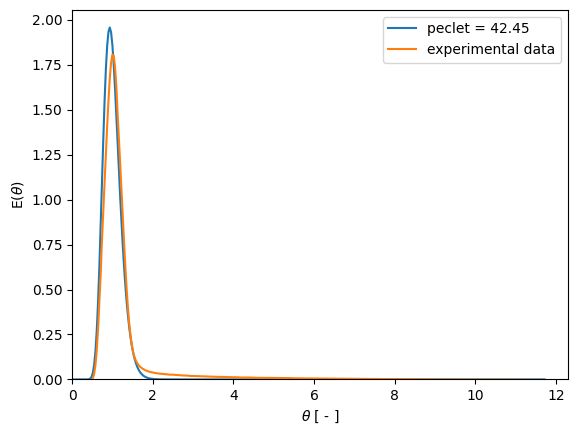

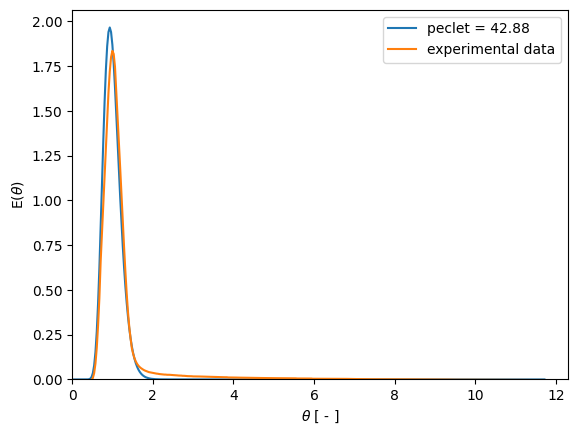

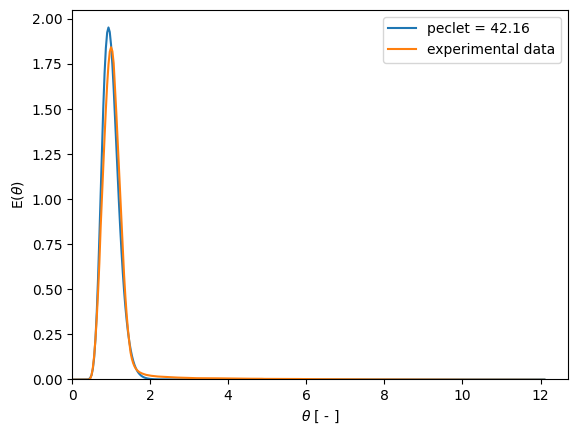

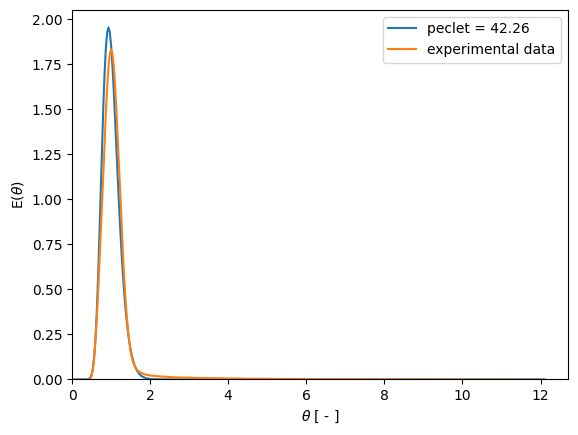

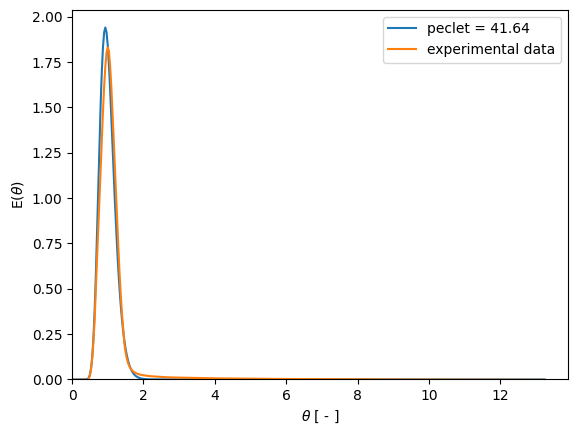

In [ ]:
#@title plotting 2

Peclet_Plotter(AxDisRawBP2, Peclet_ResultsBP2)

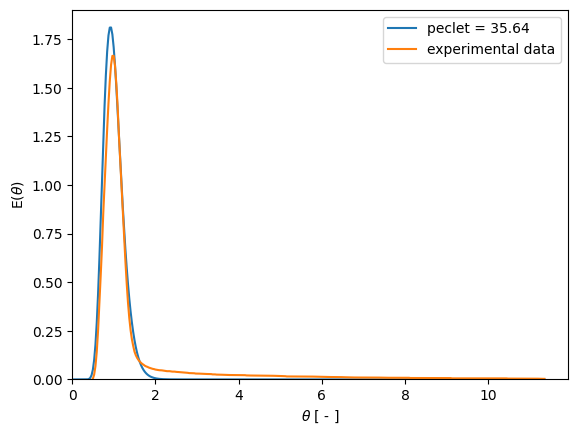

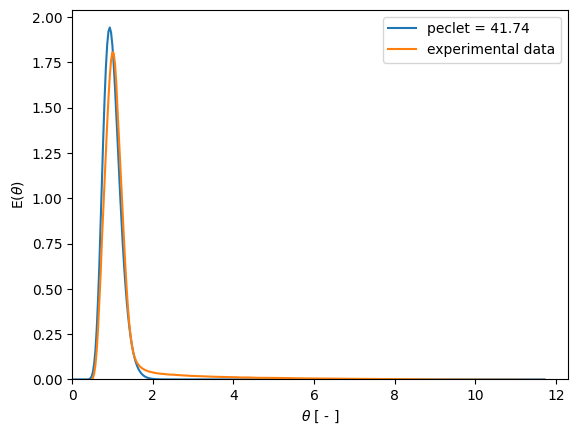

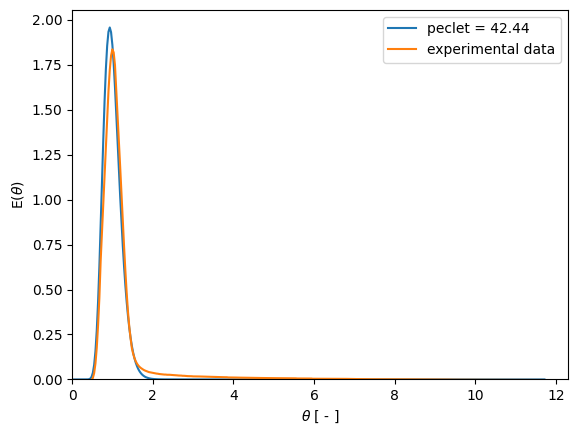

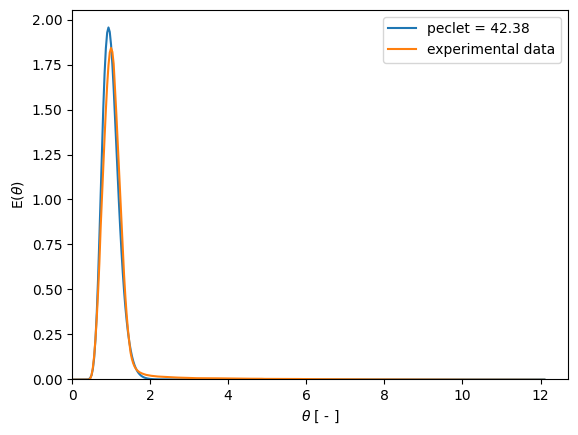

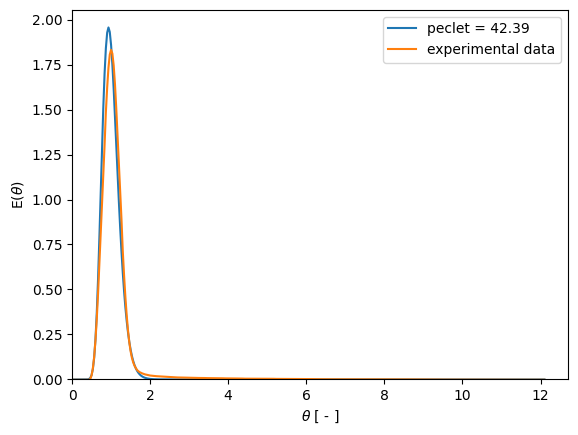

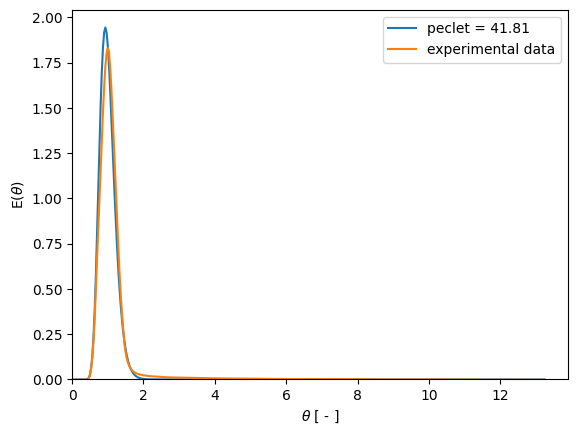

In [ ]:
#@title plotting 2 oo

Peclet_Plotter(AxDisRawBP2, Peclet_ResultsBP2_oo)

### exp1

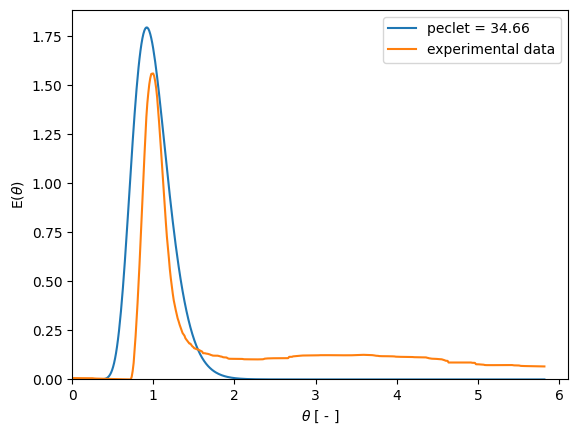

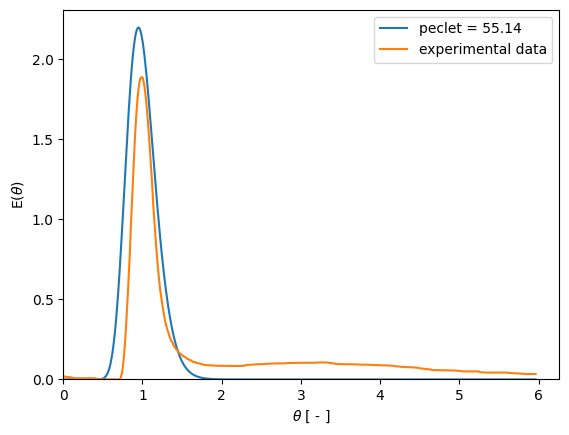

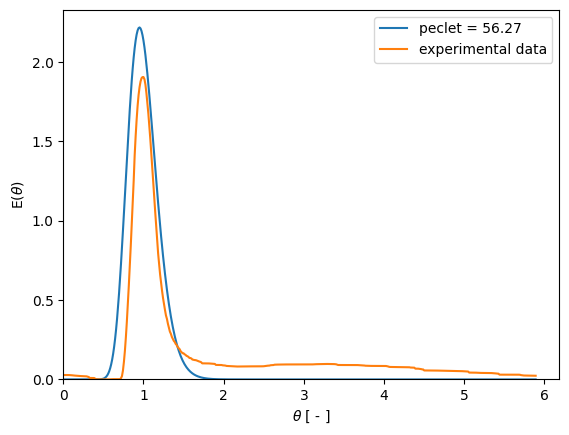

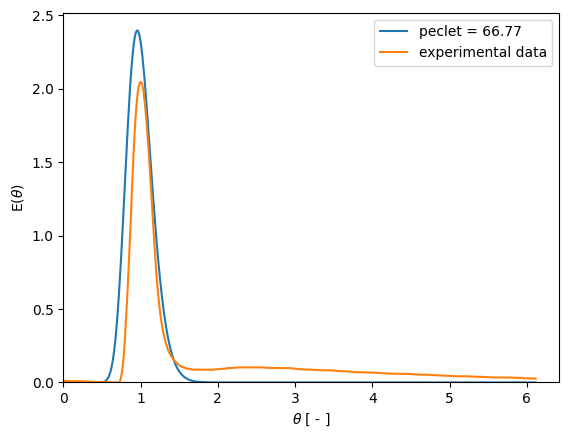

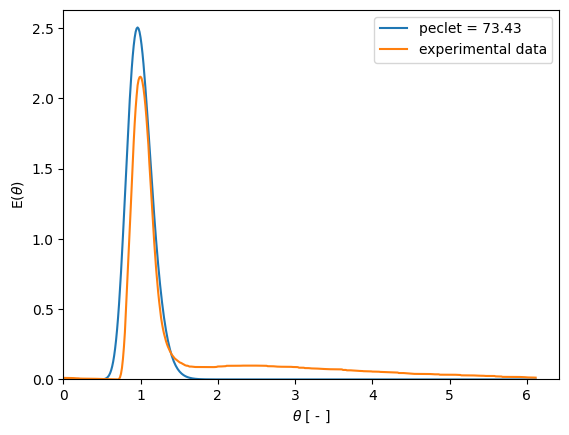

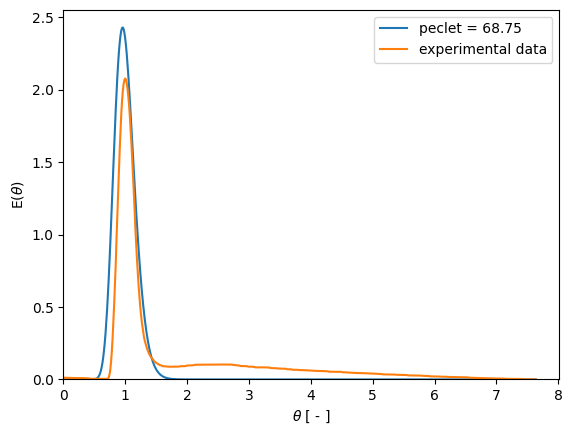

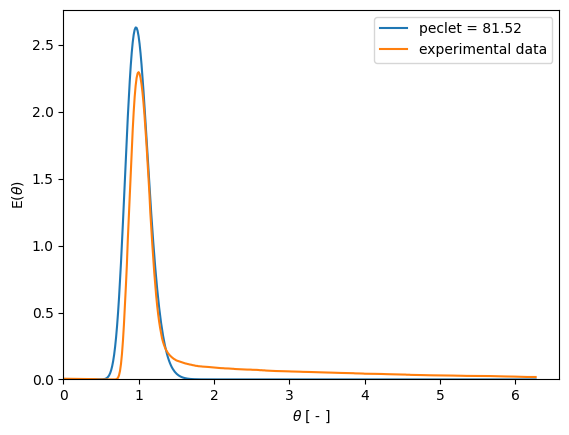

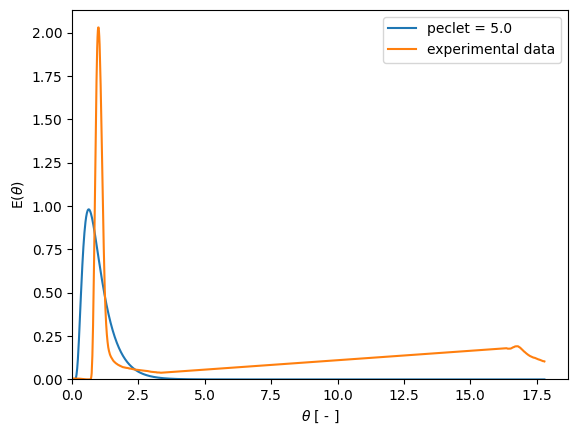

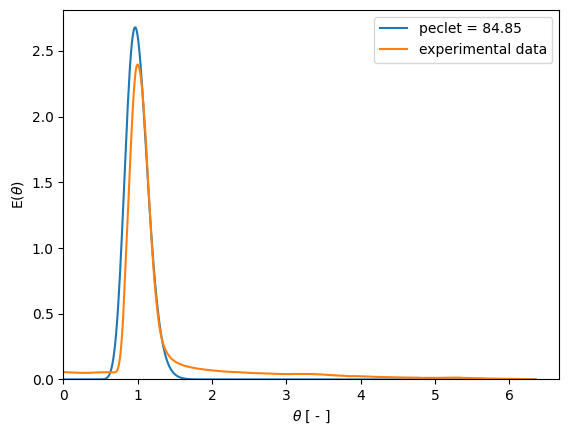

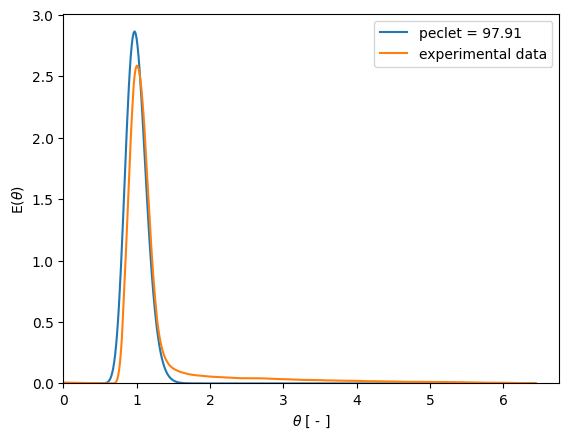

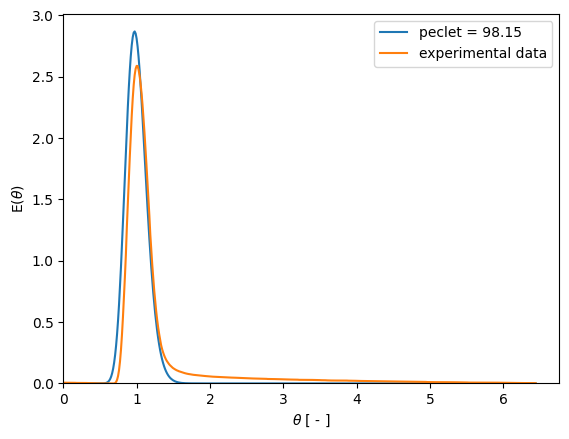

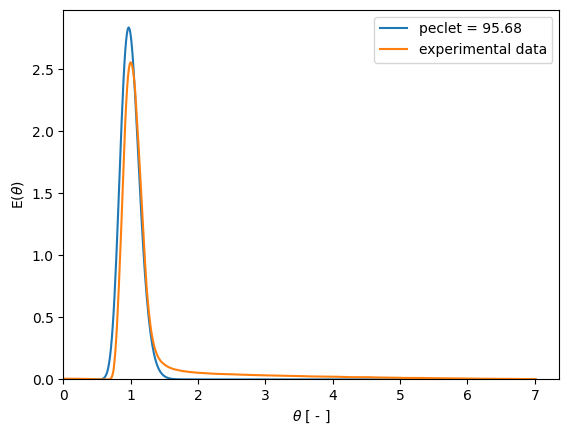

In [ ]:
#@title plotting CO

Peclet_Plotter(AxDisRaw1, Peclet_Results1)

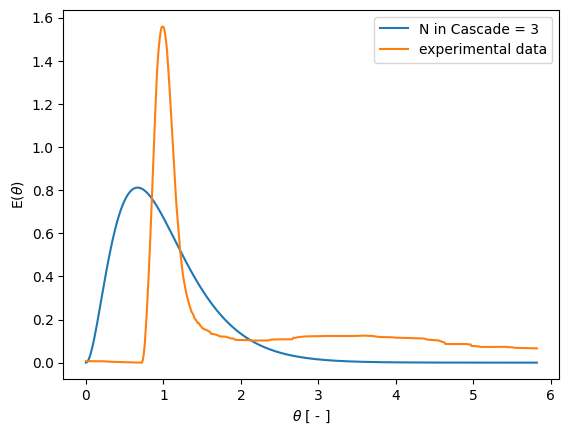

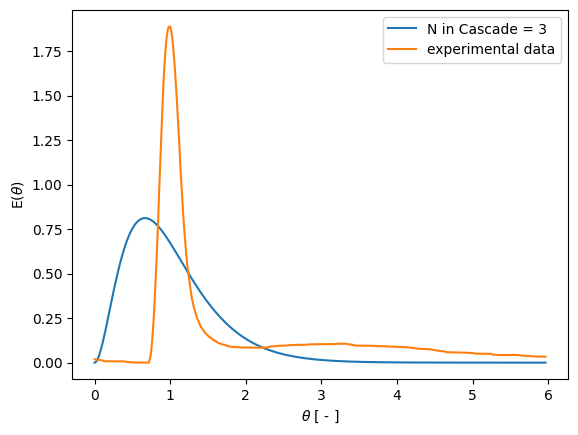

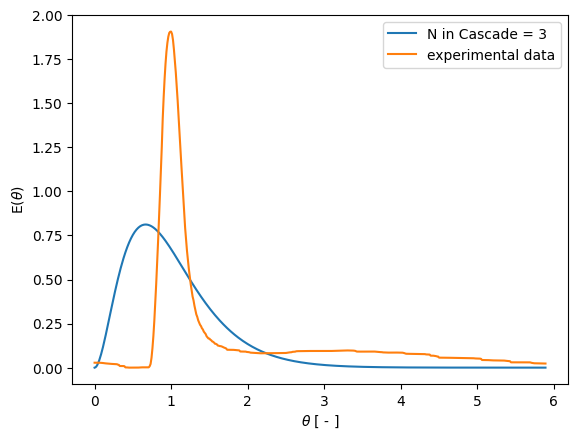

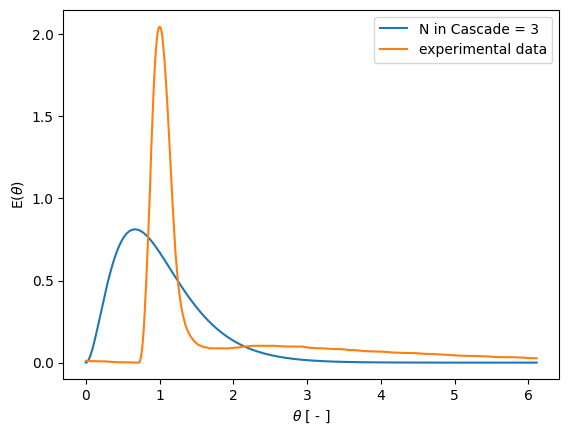

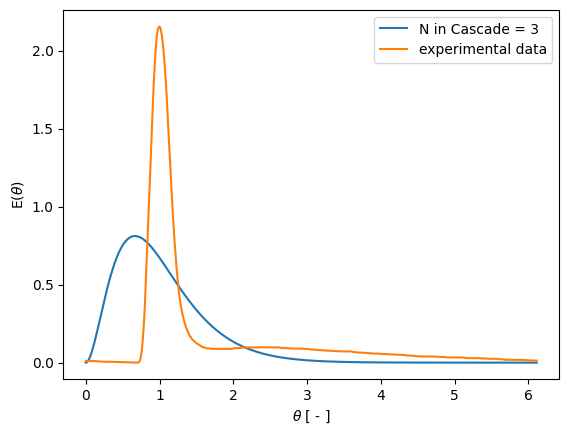

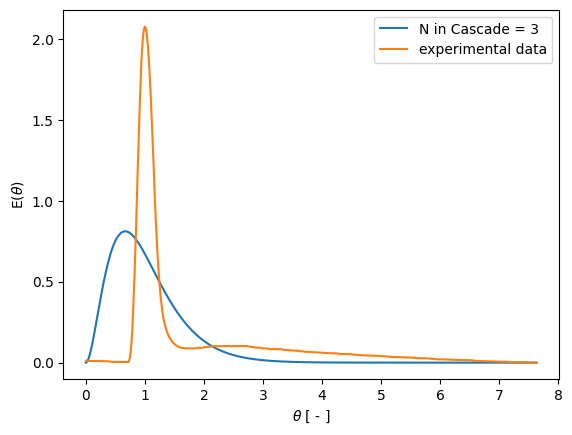

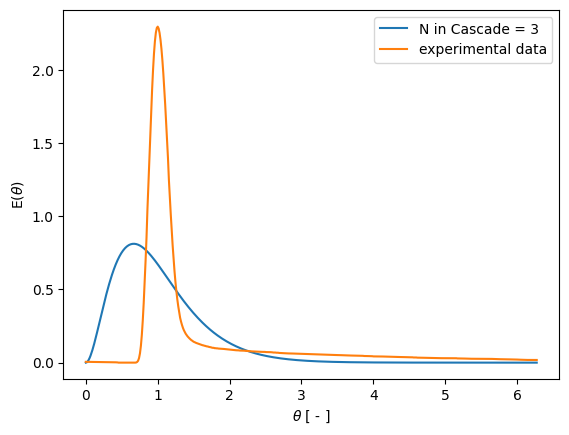

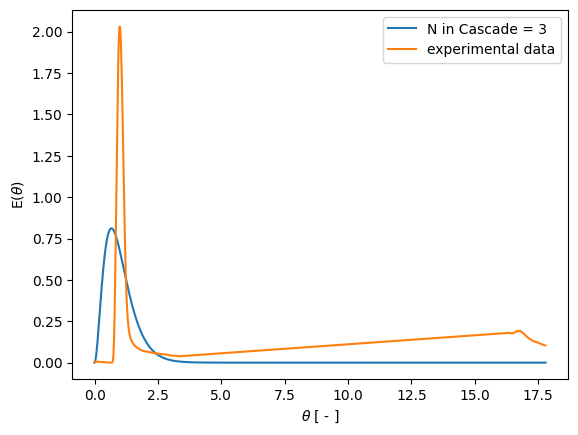

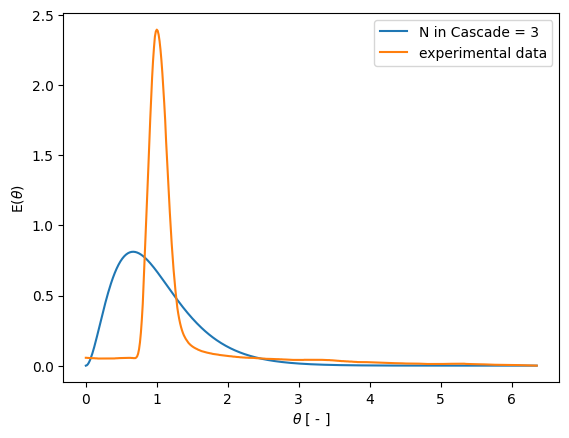

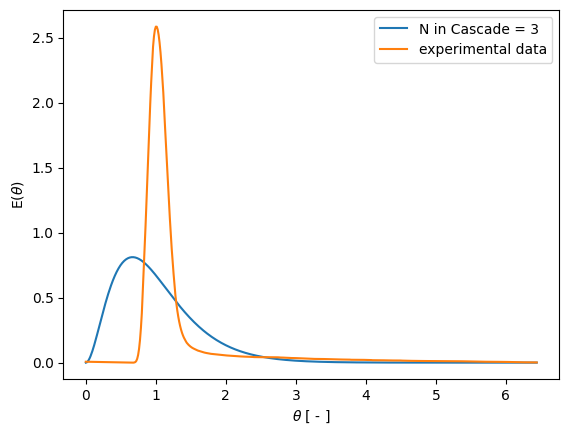

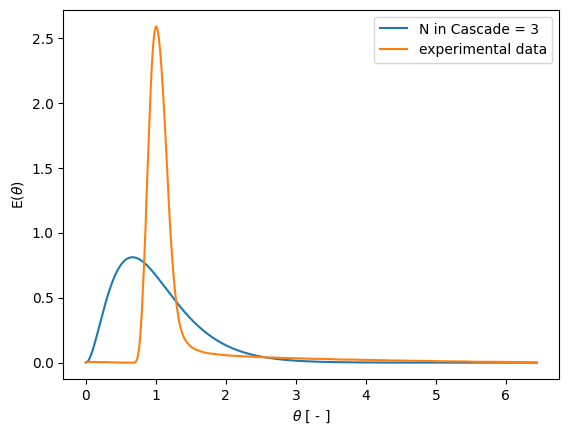

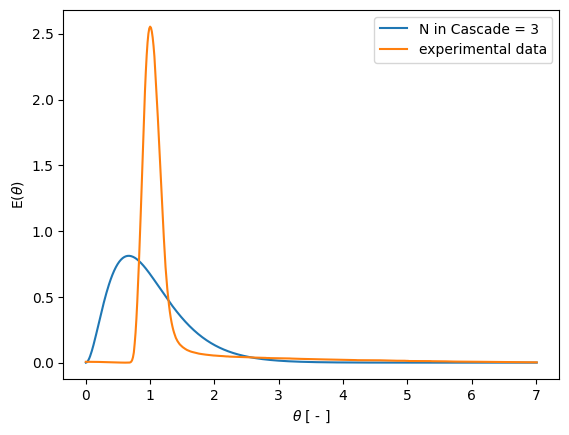

In [ ]:
#@title plotting casc

Peclet_Plotter_casc(AxDisRaw1, Peclet_Results1_casc)

### exp2

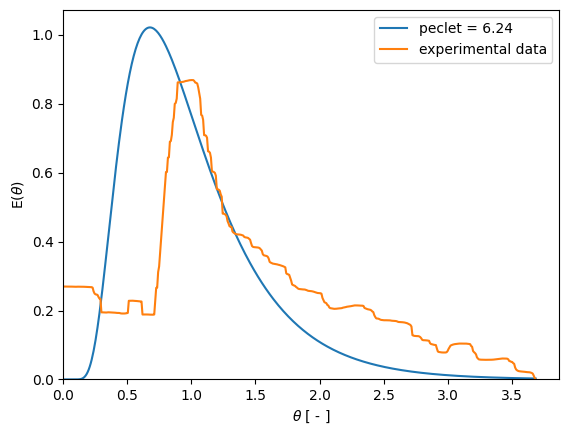

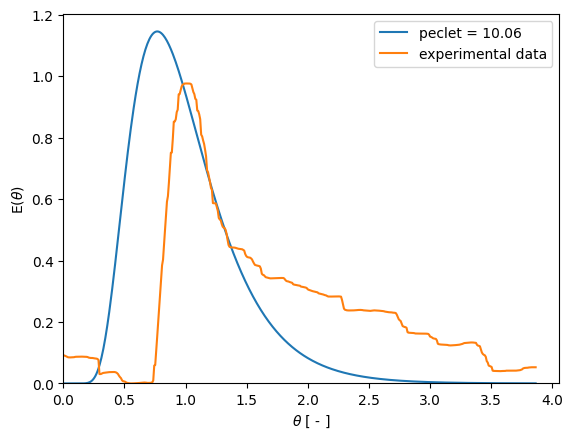

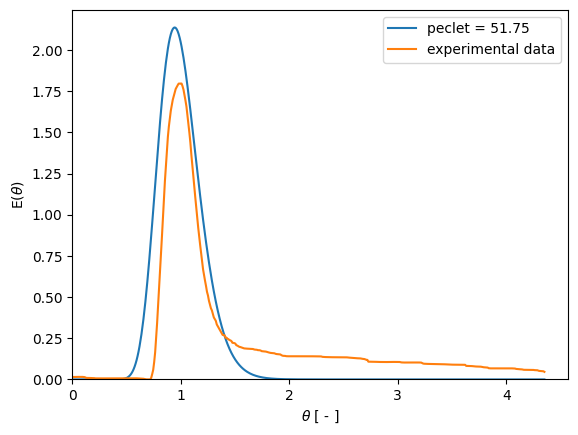

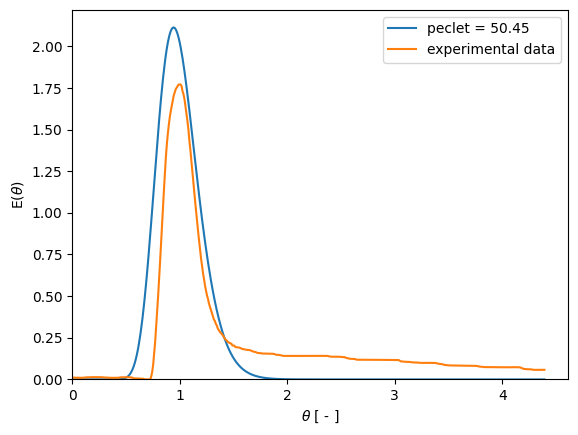

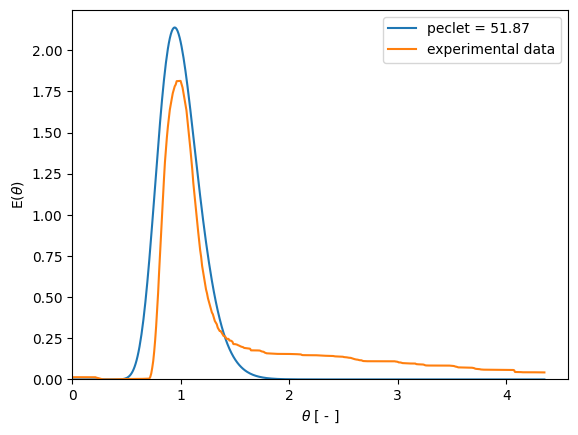

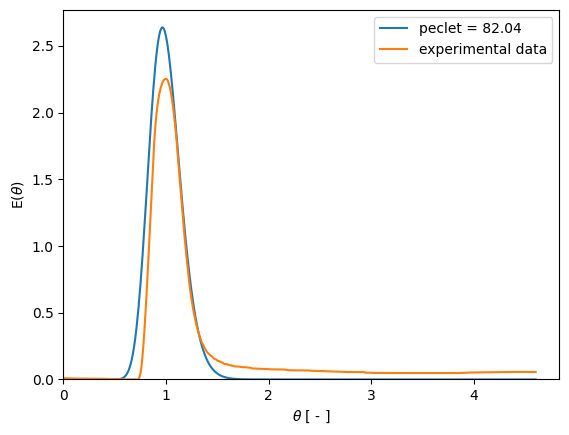

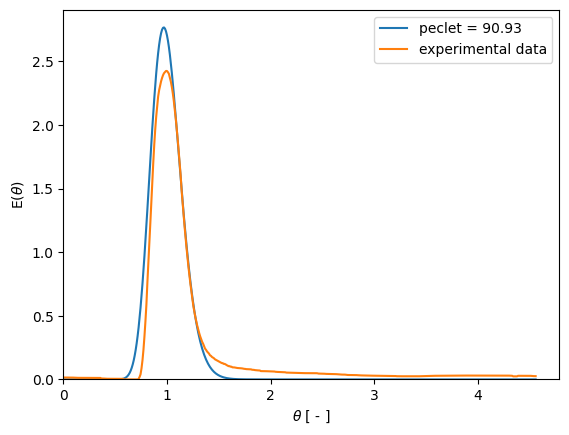

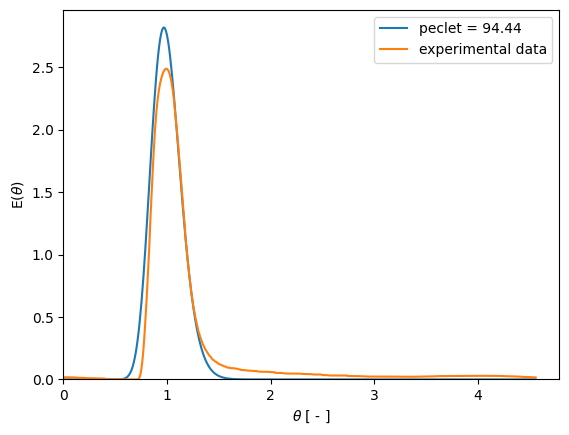

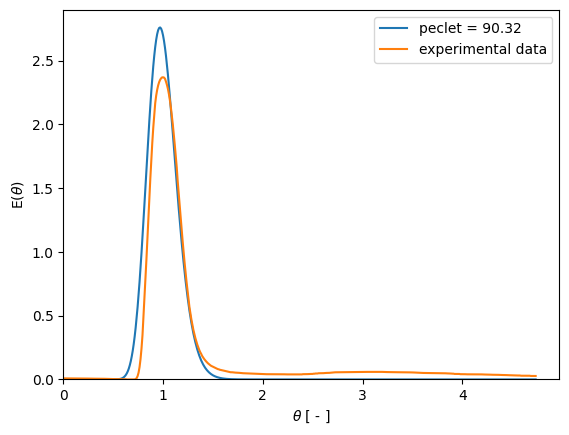

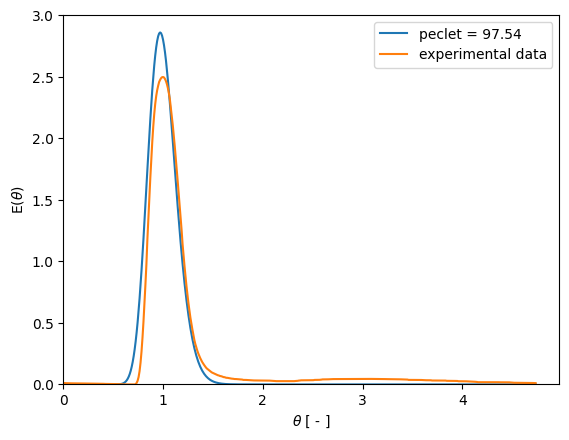

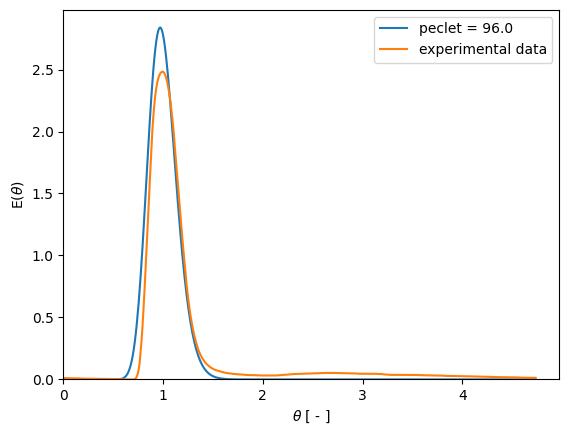

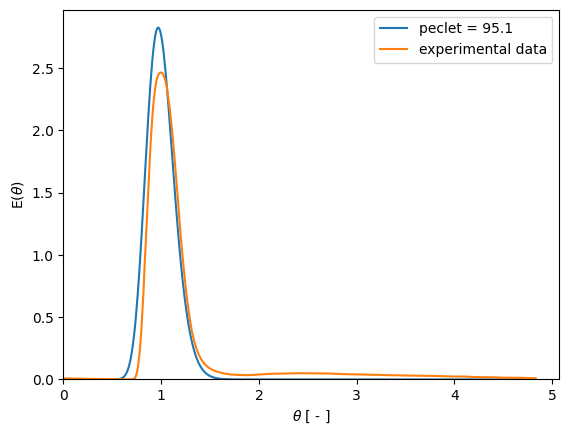

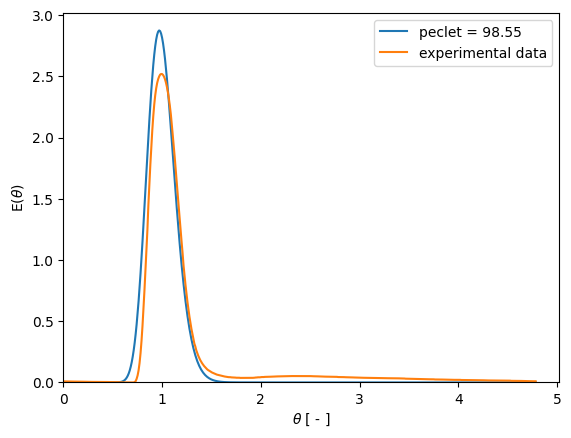

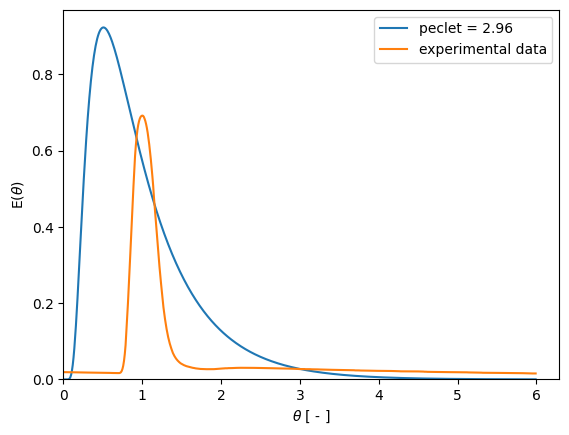

In [ ]:
#@title plotting

Peclet_Plotter(AxDisRaw2, Peclet_Results2)

In [ ]:
Peclet_Results2

array([ 6.24, 10.06, 51.75, 50.45, 51.87, 82.04, 90.93, 94.44, 90.32,
       97.54, 96.  , 95.1 , 98.55,  2.96])

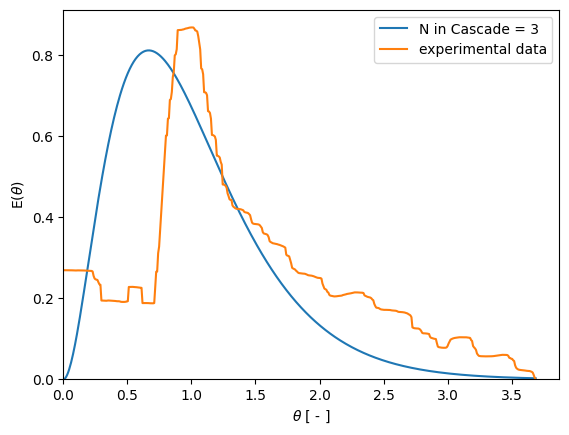

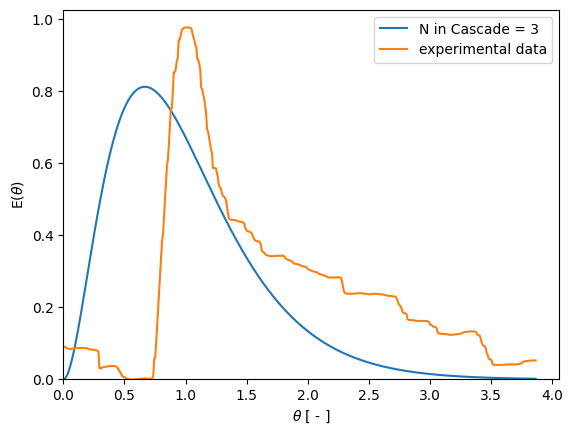

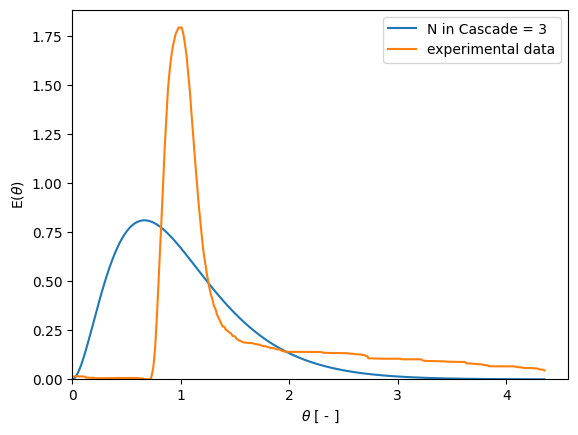

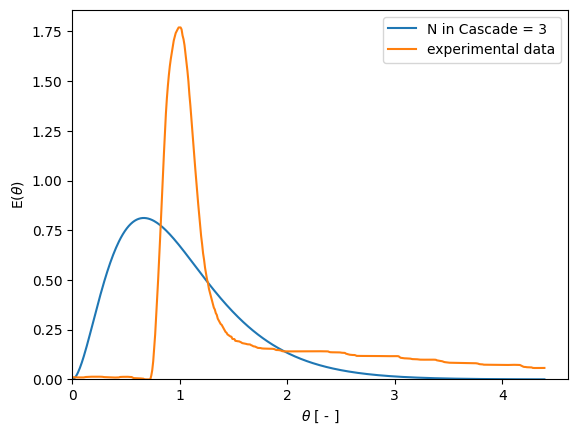

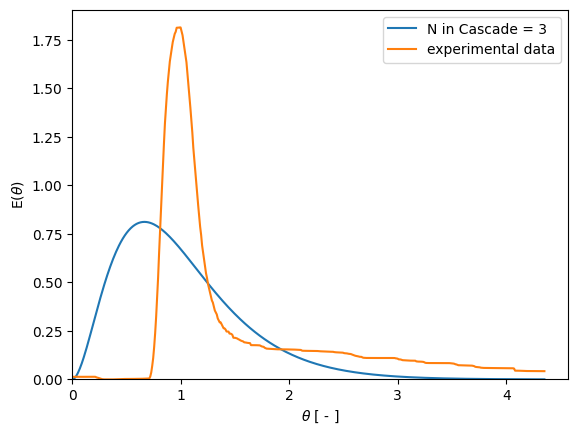

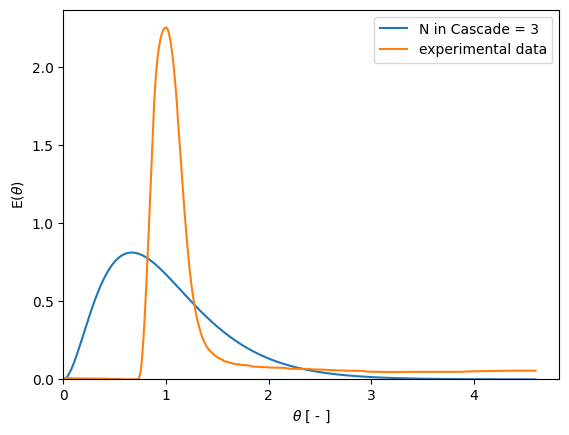

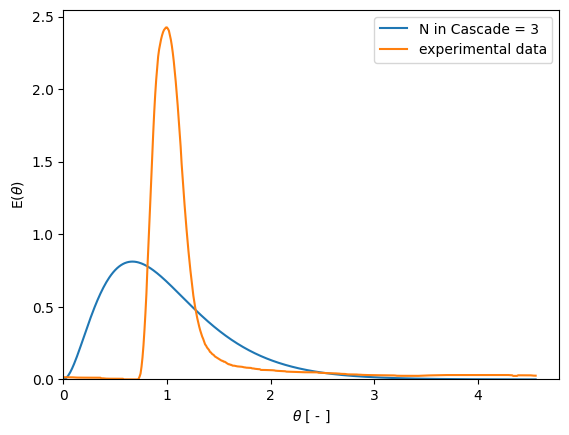

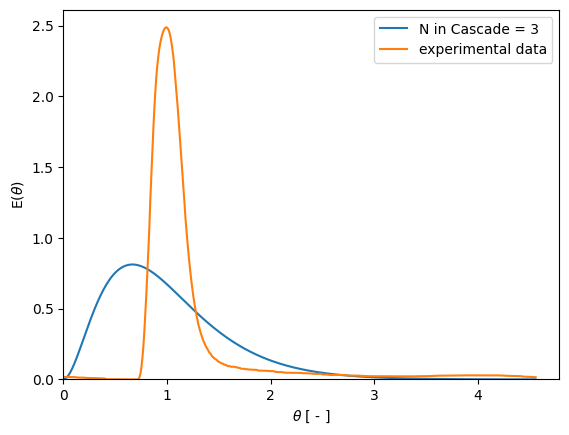

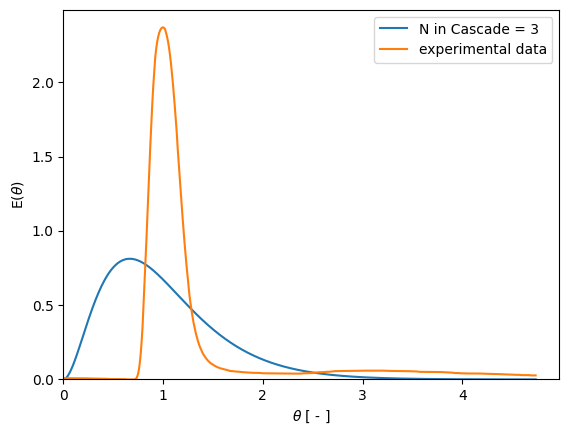

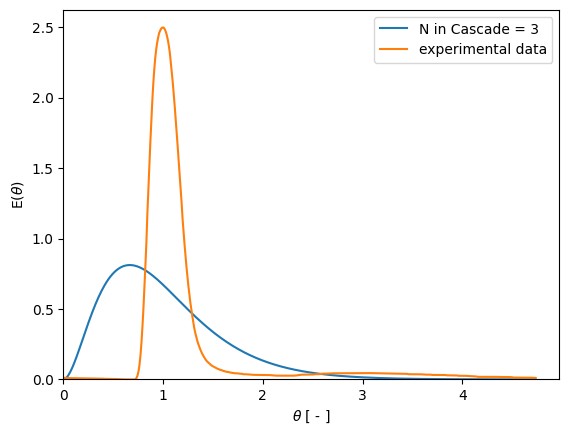

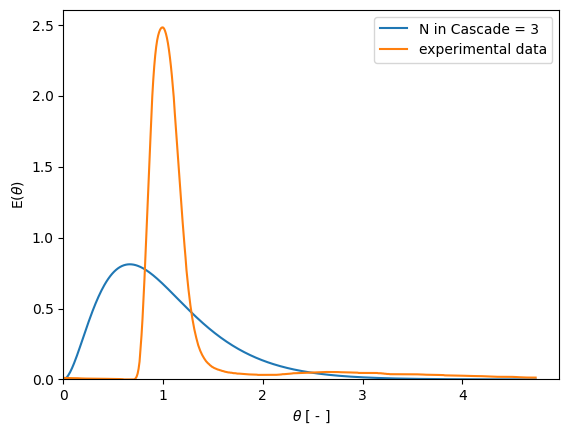

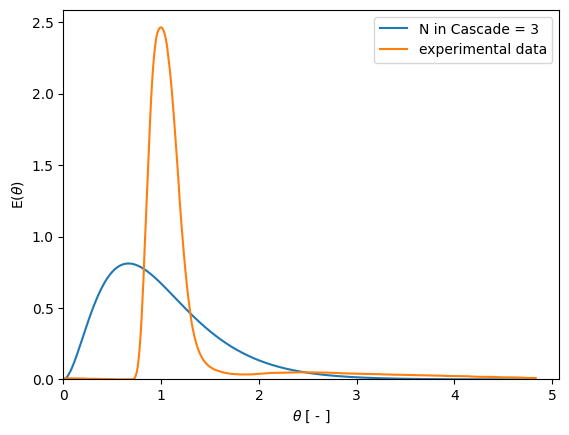

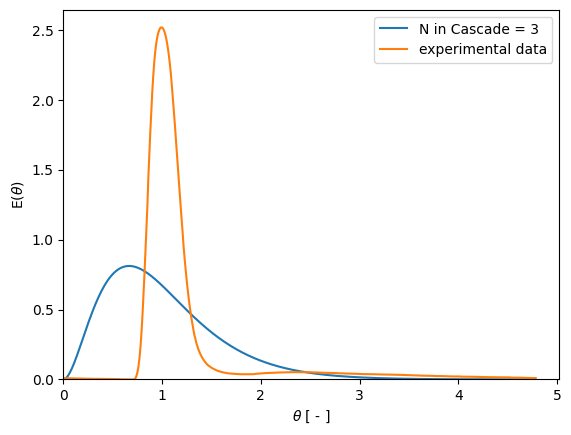

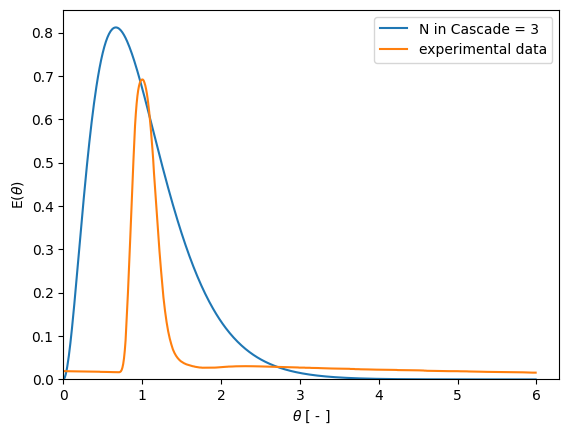

In [ ]:
#@title plotting casc

Peclet_Plotter_casc(AxDisRaw2, Peclet_Results2_casc)

### exp3

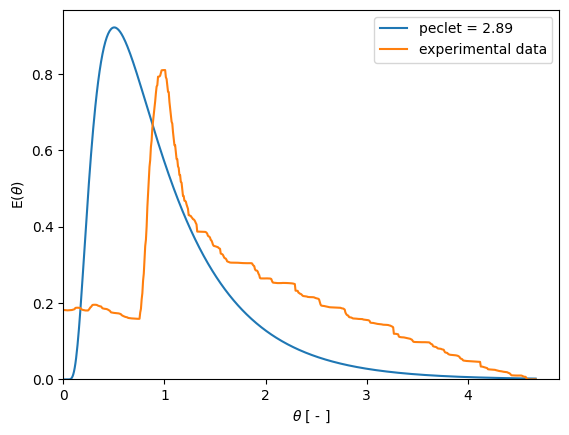

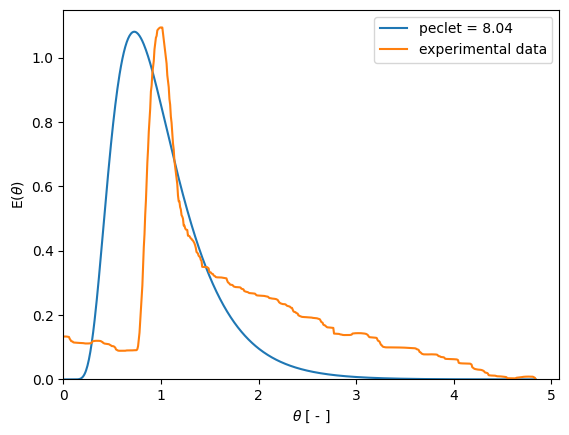

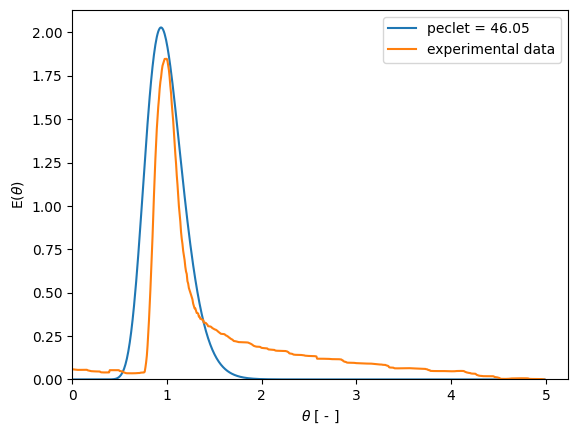

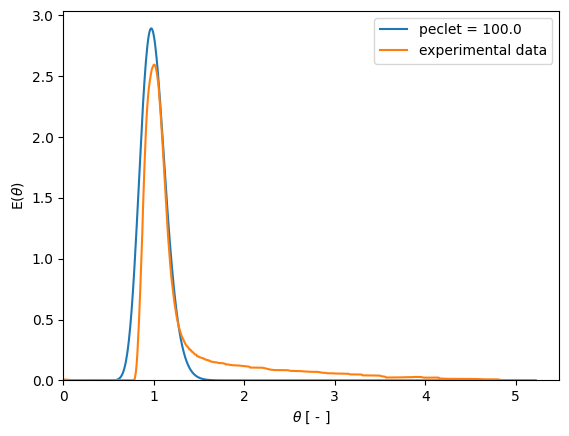

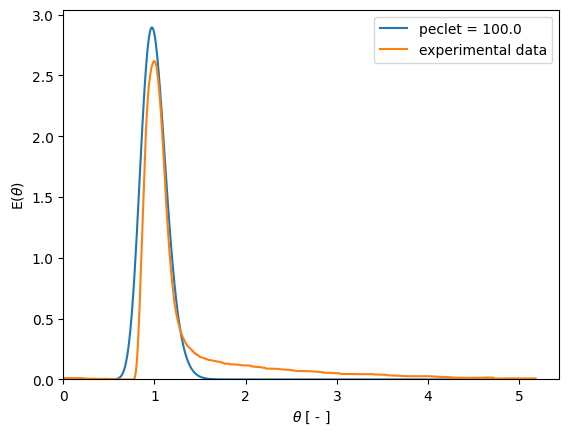

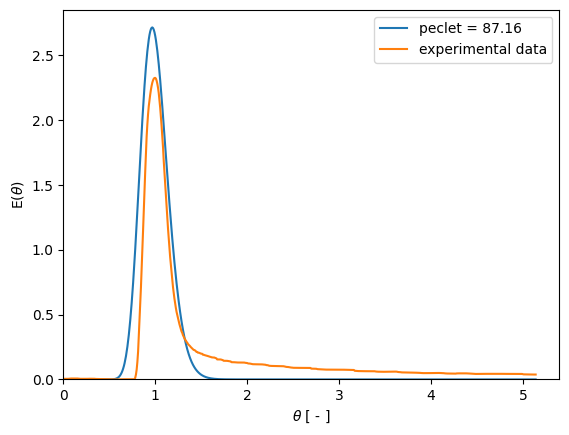

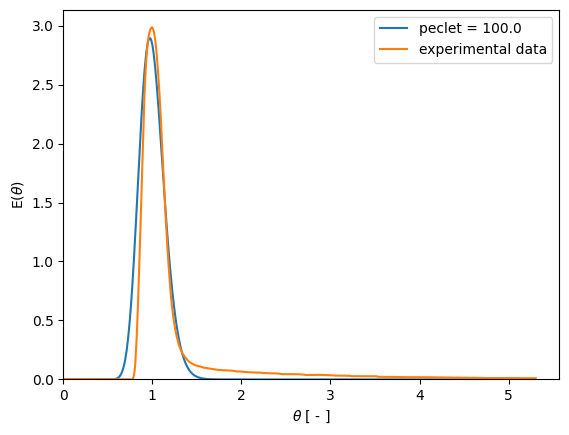

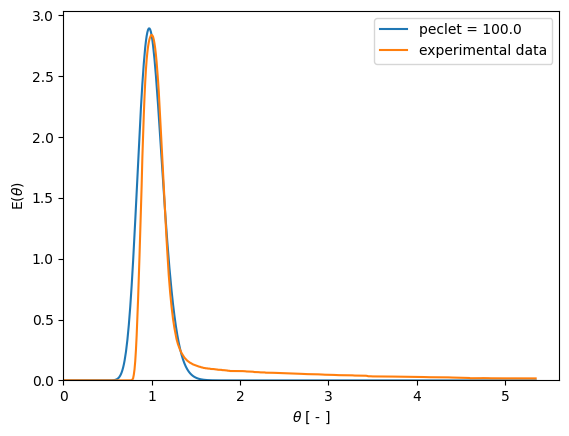

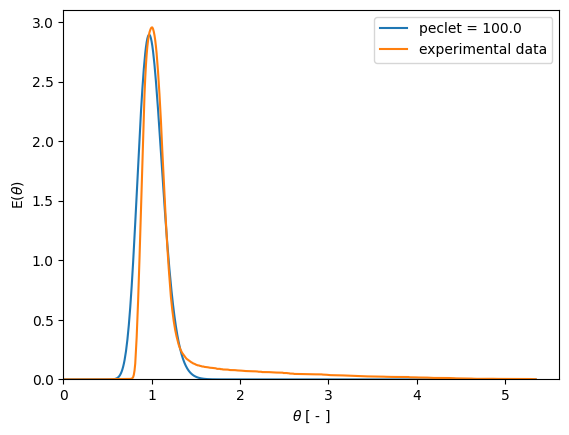

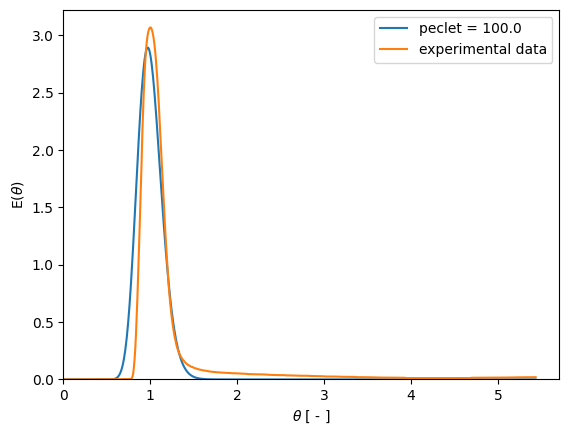

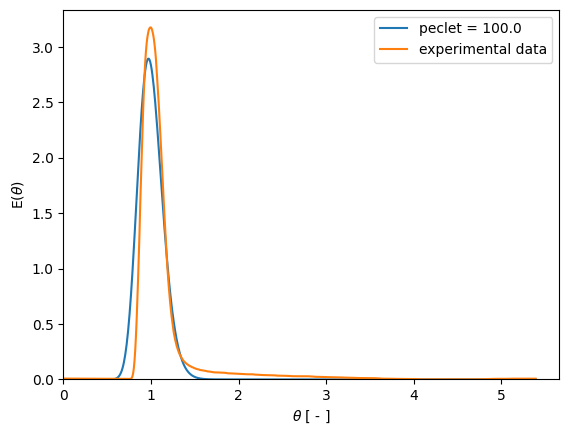

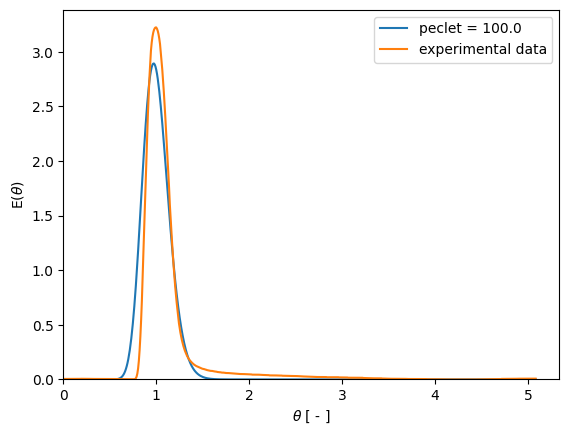

In [ ]:
#@title plotting

Peclet_Plotter(AxDisRaw3, Peclet_Results3)

In [ ]:
Peclet_Results3

array([  2.89,   8.04,  46.05, 100.  , 100.  ,  87.16, 100.  , 100.  ,
       100.  , 100.  , 100.  , 100.  ])

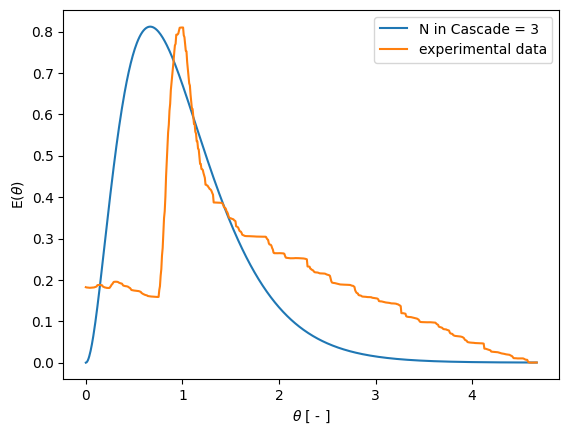

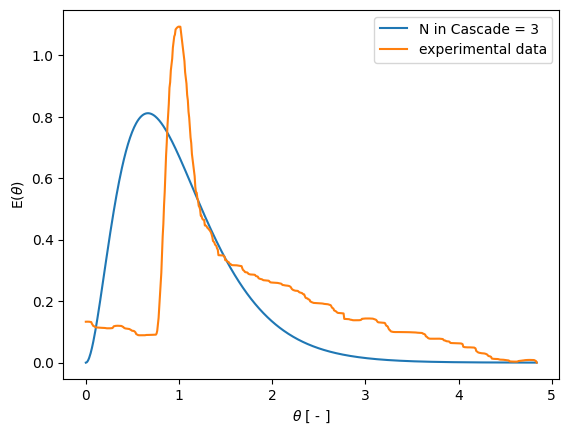

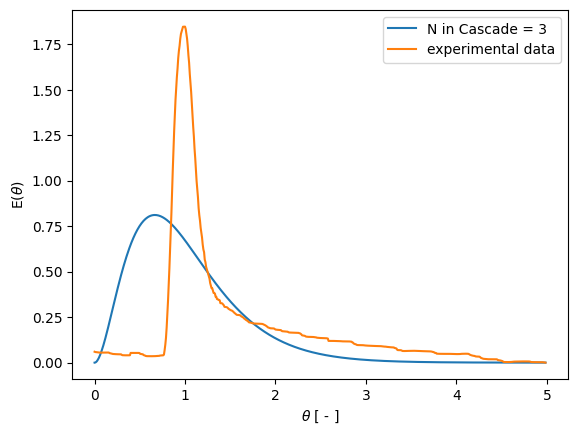

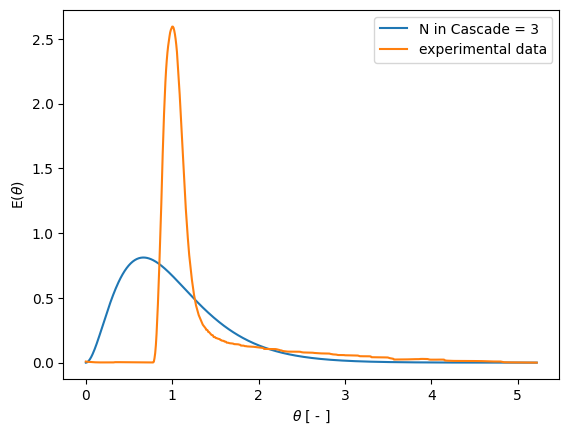

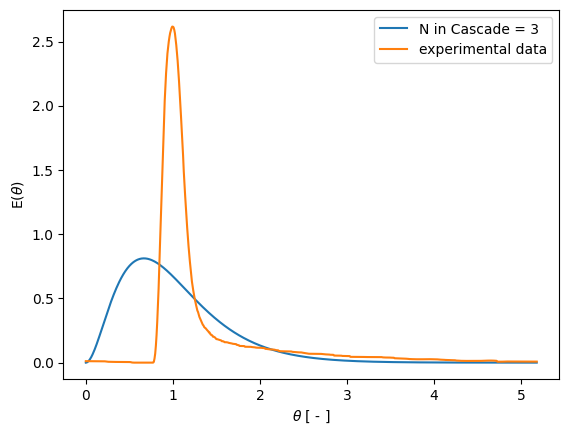

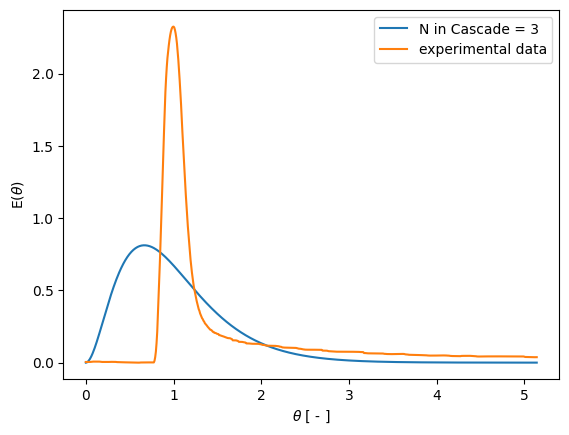

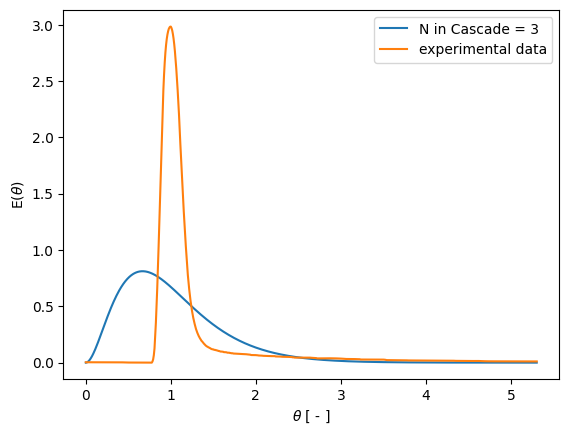

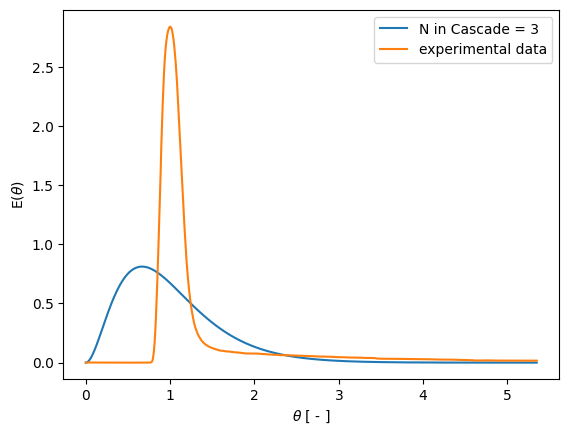

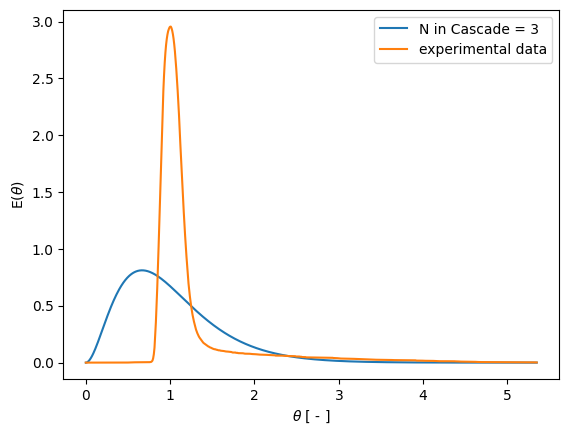

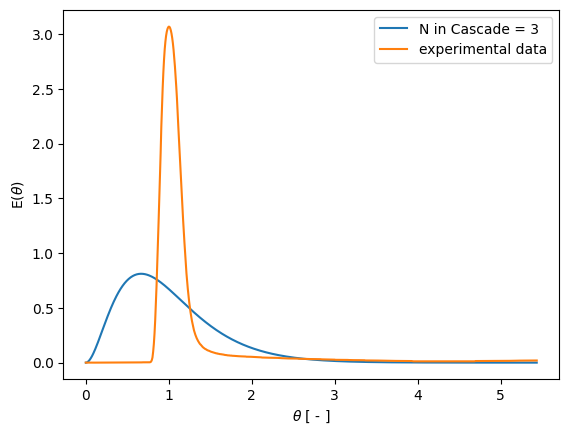

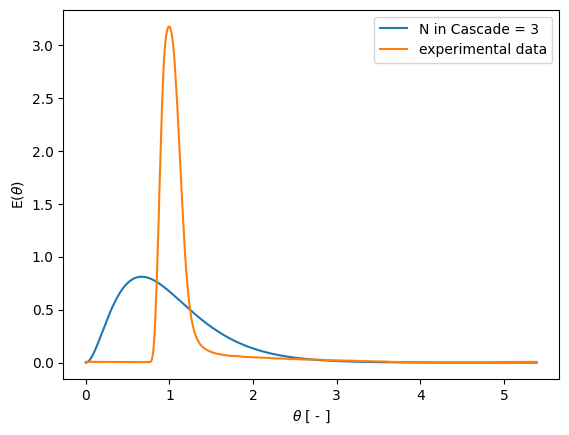

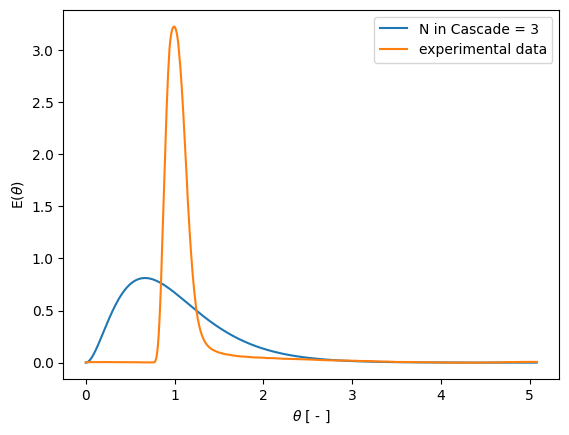

In [ ]:
#@title plotting casc

Peclet_Plotter_casc(AxDisRaw3, Peclet_Results3_casc)

### exp4

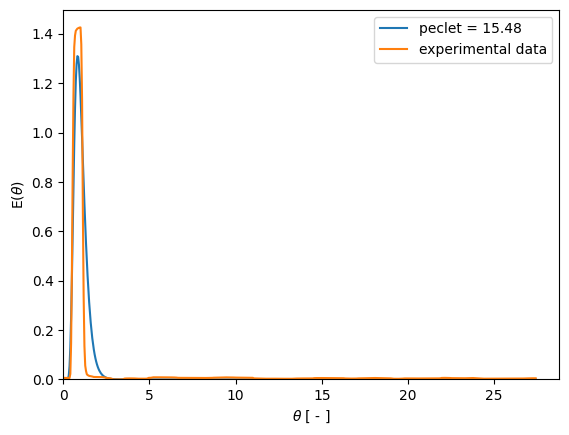

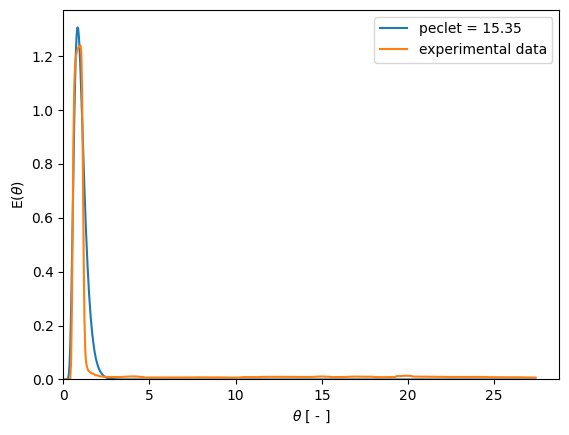

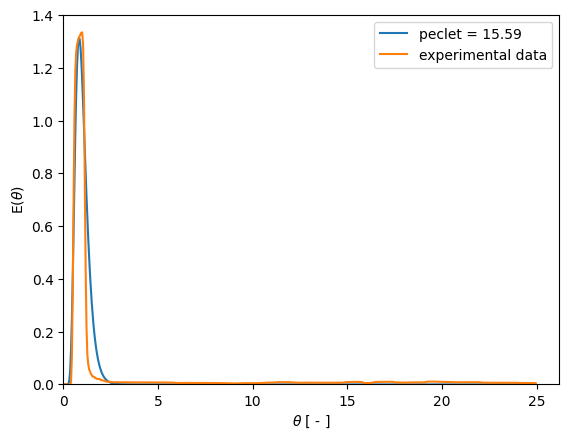

In [ ]:
#@title plotting

Peclet_Plotter(AxDisRaw4, Peclet_Results4)

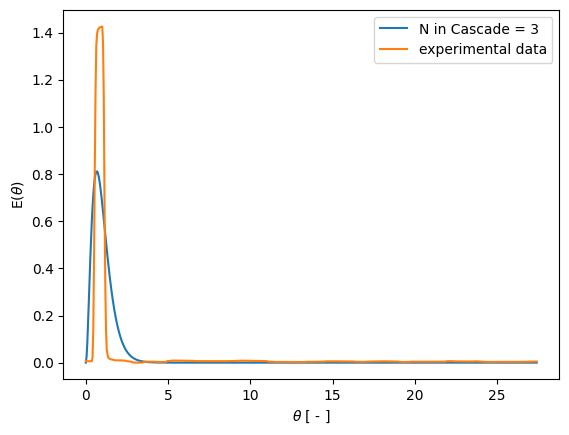

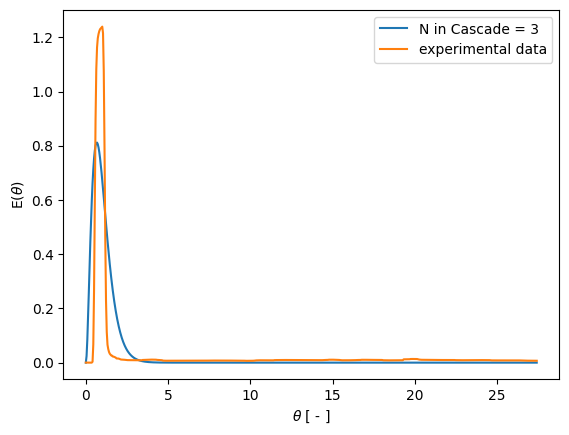

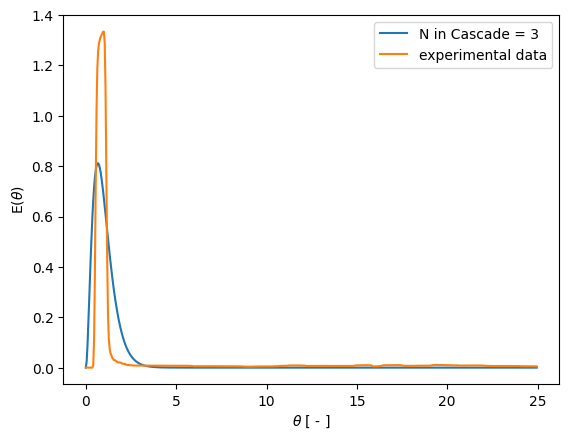

In [ ]:
#@title plotting casc

Peclet_Plotter_casc(AxDisRaw4, Peclet_Results4_casc)

### exp5

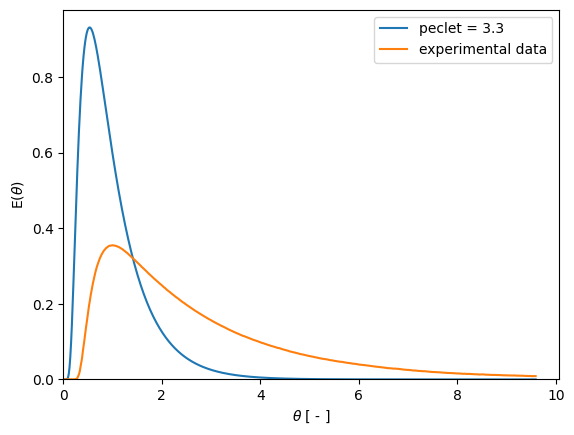

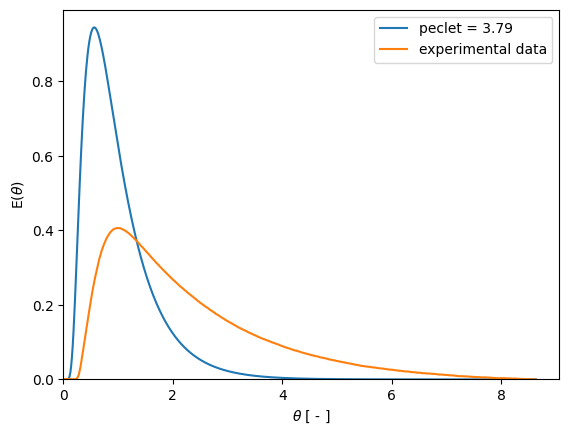

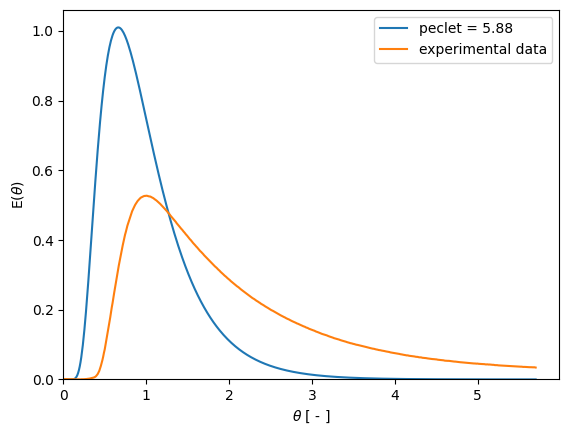

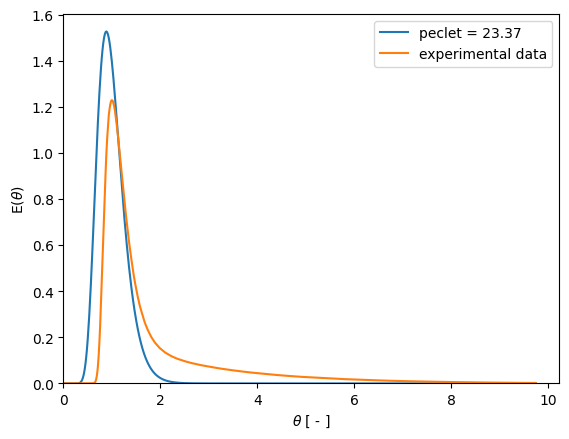

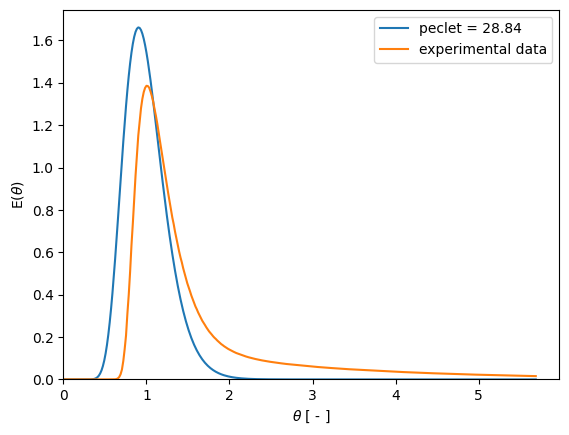

In [ ]:
#@title plotting

Peclet_Plotter(AxDisRaw5, Peclet_Results5)

In [ ]:
Peclet_Results5

array([ 3.3 ,  3.79,  5.88, 23.37, 28.84])

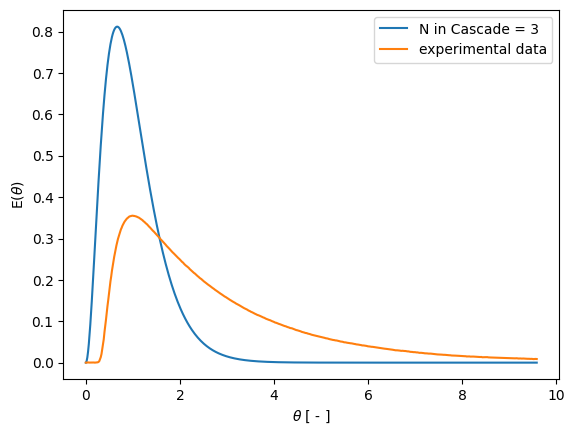

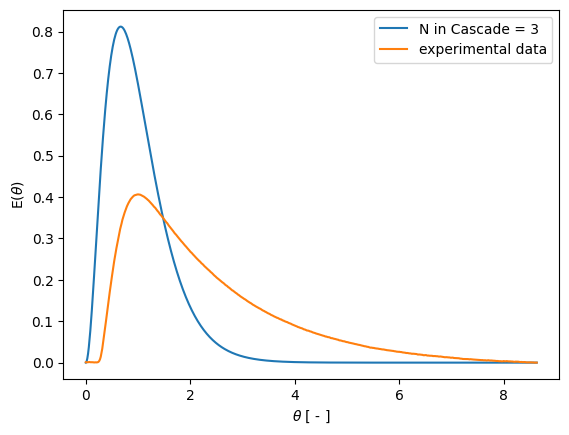

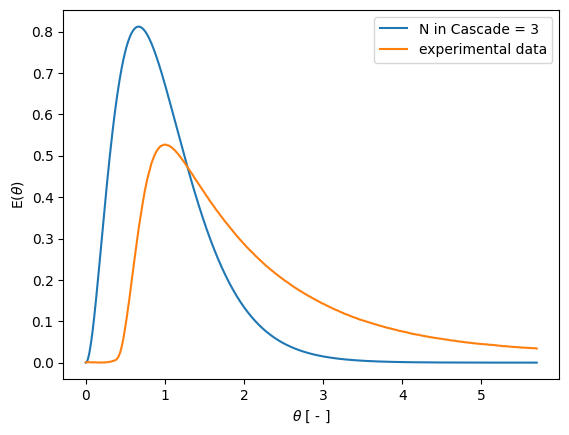

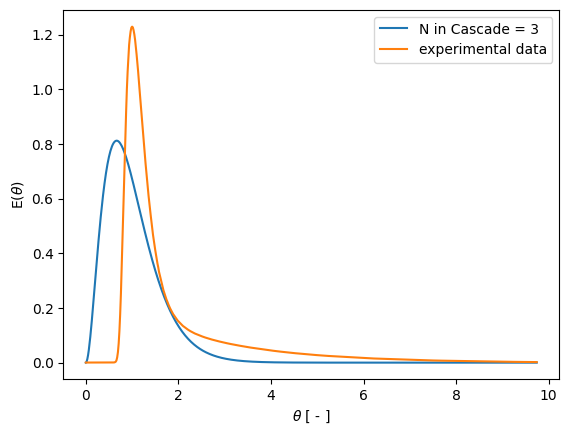

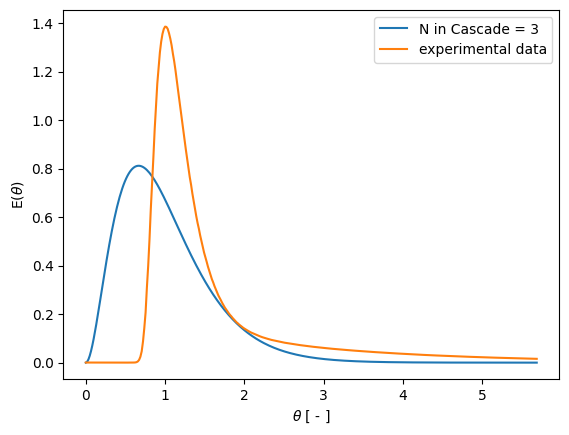

In [ ]:
#@title plotting casc

Peclet_Plotter_casc(AxDisRaw5, Peclet_Results5_casc)

In [ ]:
Peclet_Results5

array([ 3.3 ,  3.79,  5.88, 23.37, 28.84])

#First failed experiment

## Data Manipulation

In [ ]:
#@title read excel file

filepath = '/content/drive/MyDrive/Colab Notebooks/Masterarbeit Colabs/Experimental data - Excel sheets/240214_res_dist_10g_Al_var_CO2_01.xlsx'
AxDisRamp = pd.read_excel(filepath, sheet_name ='Ramp')
AxDisRaw = pd.read_excel(filepath, sheet_name ='Raw data')

In [ ]:
#@title maybe useless

AxDisRamp['Dauer (s)'] = AxDisRamp['Dauer (min)']*60
AxDisRamp['Dauer (s)'].iat[3] = 10
AxDisRamp['Dauer sum (s)'] = AxDisRamp['Dauer (s)'].cumsum()

# cols = list(AxDisRamp)
# cols.insert(0, cols.pop(cols.index('Dauer sum (s)')))
# AxDisRamp = AxDisRamp.loc[:, cols]

# AxDisRaw['group1'] = AxDisRaw['Dauer (s)'].isin(AxDisRamp['Dauer sum (s)']).astype(int).cumsum()
# AxDisRaw_dropped = AxDisRaw[AxDisRaw['CO2 (Vol%)'] > 3].groupby('group1').mean().index.tolist()

In [ ]:
#@title create input and output datasets

AxDisRaw['group1'] = AxDisRaw['CO2 (Vol%)'].rolling(25).std()
AxDisRaw['groupOUT'] = 0
AxDisRaw.loc[AxDisRaw['group1'] > 0.1, 'groupOUT'] = 1
AxDisRaw.loc[AxDisRaw['CO2 (Vol%)'] > 5, 'groupOUT'] = 1
AxDisRaw['groupOUT'] = AxDisRaw['groupOUT'].diff().abs().cumsum()
AxDisRaw['Dauer (min)'] = AxDisRaw['Dauer (s)']/60

AxDisRaw_indexing_out = AxDisRaw.groupby('groupOUT').first()
AxDisRaw_indexing_out = AxDisRaw_indexing_out[AxDisRaw_indexing_out.index > 0]['Dauer (s)'].tolist()

AxDisRawOUT = AxDisRaw[(AxDisRaw['Dauer (s)'] >= AxDisRaw_indexing_out[0]) & (AxDisRaw['Dauer (s)'] <= AxDisRaw_indexing_out[-1])]
AxDisRawOUT = AxDisRawOUT[AxDisRawOUT.groupOUT % 2 != 0]
AxDisRawOUT['groups'] = AxDisRawOUT['groupOUT'].diff().div(2).cumsum().fillna(0)

AxDisRaw['groupIN'] = 0
AxDisRaw.loc[AxDisRaw['MFC CO2 (mln/min)'] > 0, 'groupIN'] = 1
AxDisRaw.loc[AxDisRaw['MFC CO2 (mln/min)'].diff(1) < 0, 'groupIN'] = 1
AxDisRaw.loc[AxDisRaw['MFC CO2 (mln/min)'].diff(-1) < 0, 'groupIN'] = 1
AxDisRaw['groupIN'] = AxDisRaw['groupIN'].diff().abs().cumsum()

MFC_IN = np.array([93, 65, 46.5])

AxDisRawOUT['CO2 (mln/min) OUT'] = AxDisRawOUT['CO2 (Vol%)']/100 * (np.repeat(MFC_IN, AxDisRawOUT.groupby("groups")["CO2 (Vol%)"].count()) + 100) * (AxDisRawOUT['TIC-10 (ｰC)'] + 273)/273

AxDisRaw_indexing_in = AxDisRaw.groupby('groupIN').first()
AxDisRaw_indexing_in = AxDisRaw_indexing_in[AxDisRaw_indexing_in.index > 0]['Dauer (s)'].tolist()

AxDisRawIN = AxDisRaw[(AxDisRaw['Dauer (s)'] >= AxDisRaw_indexing_in[0]) & (AxDisRaw['Dauer (s)'] <= AxDisRaw_indexing_in[-3])]
AxDisRawIN = AxDisRawIN[AxDisRawIN.groupIN % 2 != 0]
AxDisRawIN['groups'] = AxDisRawIN['groupIN'].diff().div(2).cumsum().fillna(0)

Vol_CO2_Sum = np.zeros([3, 2])

Vol_CO2_Sum[:, 0] = AxDisRawIN.groupby('groups')['MFC CO2 (mln/min)'].sum()
Vol_CO2_Sum[:, 1] = AxDisRawOUT.groupby('groups')['CO2 (mln/min) OUT'].sum()

In [ ]:
#@title comparative time arrays

time_IN = np.zeros([int(AxDisRawIN['groups'].iat[-1]) + 1, 3])
time_OUT = np.zeros([int(AxDisRawOUT['groups'].iat[-1]) + 1, 3])

time_IN[:, 0] = AxDisRawIN.groupby('groups').nth([0])['Dauer (s)']
time_IN[:, 1] = AxDisRawIN.groupby('groups').nth([-1])['Dauer (s)']
time_IN[:, 2] = AxDisRawIN.groupby('groups').agg(lambda x: x.iat[-1] - x.iat[0])['Dauer (s)']

time_OUT[:, 0] = AxDisRawOUT.groupby('groups').nth([0])['Dauer (s)']
time_OUT[:, 1] = AxDisRawOUT.groupby('groups').nth([-1])['Dauer (s)']
time_OUT[:, 2] = AxDisRawOUT.groupby('groups').agg(lambda x: x.iat[-1] - x.iat[0])['Dauer (s)']


time_compare = np.concatenate((time_IN, time_OUT), axis=1)

time_compare_df = pd.DataFrame(time_compare, columns=['Input start [s]', 'Input end [s]', 'Input Difference [s]', 'Output start [s]', 'Output end [s]', 'Output Difference [s]'])
time_compare_df['In Out Difference [s]'] = time_compare_df['Input Difference [s]']-time_compare_df['Output Difference [s]']

time_compare_df = pd.concat([time_compare_df, pd.DataFrame(Vol_CO2_Sum, columns=['CO2 [mlN/min] IN', 'CO2 [mlN/min] OUT'])], axis=1).round(decimals=2)
time_compare_df['CO2 Diff [mlN/min] %'] = (time_compare_df['CO2 [mlN/min] IN'] - time_compare_df['CO2 [mlN/min] OUT']) / time_compare_df['CO2 [mlN/min] IN'] * 100

time_compare_df

Input start [s]  Input end [s]  Input Difference [s]  Output start [s]  \
0           1440.0         5160.0                3720.0            2720.0   
1          12250.0        15960.0                3710.0           13700.0   
2          17650.0        21430.0                3780.0           19250.0   

   Output end [s]  Output Difference [s]  In Out Difference [s]  \
0          6270.0                 3550.0                  170.0   
1         17060.0                 3360.0                  350.0   
2         22440.0                 3190.0                  590.0   

   CO2 [mlN/min] IN  CO2 [mlN/min] OUT  CO2 Diff [mlN/min] %  
0          33567.70           30906.42              7.928098  
1          23482.59           19157.58             18.417943  
2          16788.19           12115.91             27.830755

## Calculations

In [ ]:
d = 10                  # mm
dR = d/1000             # m
AR = np.pi*(dR/2)**2    # m^2
TN = 273                # K
T = 150 + 273           # K
L_max = 0.7             # m
V01 = (100 + MFC_IN[0]) * T/TN / 60 / 1000 / 1000  # m^3/s
V02 = (100 + MFC_IN[1]) * T/TN / 60 / 1000 / 1000  # m^3/s
V03 = (100 + MFC_IN[2]) * T/TN / 60 / 1000 / 1000  # m^3/s

u01 = V01/AR            # m/s
u02 = V02/AR            # m/s
u03 = V03/AR            # m/s

In [ ]:
V01

4.9840659340659345e-06

In [ ]:
(2630-1450)/60

19.666666666666668

In [ ]:
ALdens = 0.8    # g/cm^3
mAL = 5         # g


##Plots

<Figure size 640x480 with 0 Axes>

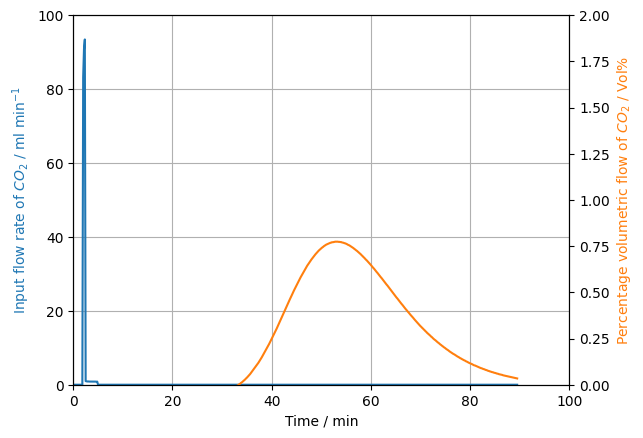

In [ ]:
#@title plot

plt.figure()

x = (AxDisRaw['Dauer (s)'] - 83000)/60

y1 = AxDisRaw['MFC CO2 (mln/min)']
y2 = AxDisRaw['CO2 (Vol%)']

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'tab:blue', label='temperature')
ax2.plot(x, y2, 'tab:orange', label='pressure')

ax1.set_xlabel('Time / min')
ax1.set_ylabel('Input flow rate of $CO_2$ / ml min$^{-1}$', color = 'tab:blue')
ax2.set_ylabel('Percentage volumetric flow of $CO_2$ / Vol%', color ='tab:orange')
ax1.axis((0, 100, 0, 100))
ax2.axis((0, 100, 0, 2))
ax1.grid()
plt.show()


(0.0, 43.5923)

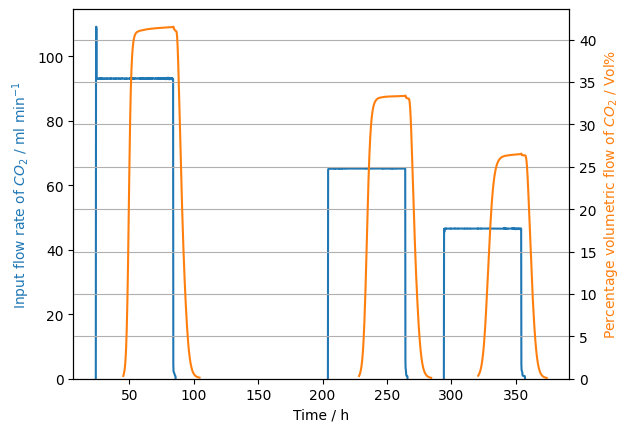

In [ ]:
#@title combined plot

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_xlabel('Time / h')

ax2.set_ylabel('Percentage volumetric flow of $CO_2$ / Vol%', color ='tab:orange')

for i in range(int(AxDisRawOUT['groups'].iat[-1]) + 1):
    ax2.plot(AxDisRawOUT[AxDisRawOUT['groups'] == i]['Dauer (min)'], AxDisRawOUT[AxDisRawOUT['groups'] == i]['CO2 (Vol%)'], color='tab:orange')

ax1.set_ylabel('Input flow rate of $CO_2$ / ml min$^{-1}$', color = 'tab:blue')  # we already handled the x-label with ax1

for i in range(int(AxDisRawOUT['groups'].iat[-1]) + 1):
    ax1.plot(AxDisRawIN[AxDisRawIN['groups'] == i]['Dauer (min)'], AxDisRawIN[AxDisRawIN['groups'] == i]['MFC CO2 (mln/min)'], color='tab:blue')
plt.grid()

ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)

(0.0, 130.30840384615385)

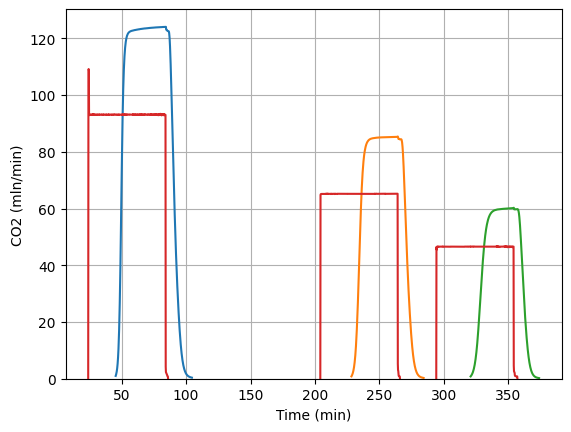

In [ ]:
#@title combined plot

plt.figure()


plt.xlabel('Time (min)')

plt.ylabel('CO2 (mln/min)')

for i in range(int(AxDisRawOUT['groups'].iat[-1]) + 1):
    plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == i]['Dauer (min)'], AxDisRawOUT[AxDisRawOUT['groups'] == i]['CO2 (mln/min) OUT'])

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

for i in range(int(AxDisRawOUT['groups'].iat[-1]) + 1):
    plt.plot(AxDisRawIN[AxDisRawIN['groups'] == i]['Dauer (min)'], AxDisRawIN[AxDisRawIN['groups'] == i]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0)


## single peak plotting

(0.0, 84.525)

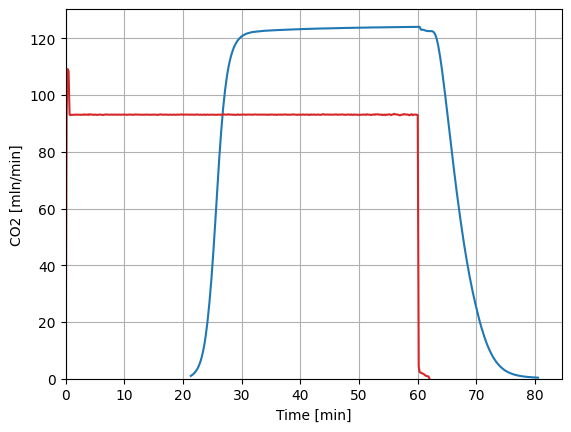

In [ ]:
#@title 1 full

plt.figure()


plt.xlabel('Time [min]')

plt.ylabel('CO2 [mln/min]')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 0]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 0]['CO2 (mln/min) OUT'])

color = 'tab:red'
ax2.set_ylabel('MFC CO2 [mln/min]', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 0]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0)
plt.xlim(left=0)


(0.0, 59.66666666666667)

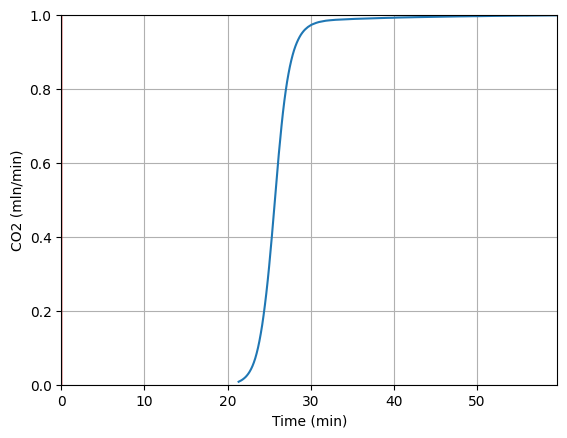

In [ ]:
#@title 1 clipped

plt.figure()


plt.xlabel('Time (min)')

plt.ylabel('CO2 (mln/min)')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 0]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 0]['CO2 (mln/min) OUT']
                                                                                                                                /AxDisRawOUT[AxDisRawOUT['groups'] == 0]['CO2 (mln/min) OUT'].max())

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 0]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0, top=1)
plt.xlim(left = 0, right = AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[-15] - AxDisRawIN[AxDisRawIN['groups'] == 0]['Dauer (min)'].iat[0])

(0.0, 84.17499999999998)

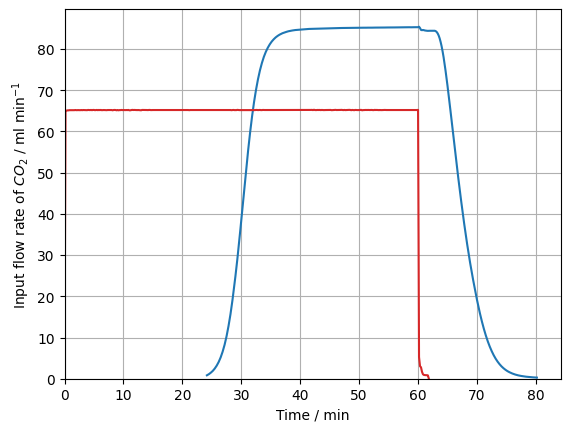

In [ ]:
#@title 2 full


plt.figure()


plt.xlabel('Time / min')

plt.ylabel('Input flow rate of $CO_2$ / ml min$^{-1}$')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 1]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 1]['CO2 (mln/min) OUT'])

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 1]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0)
plt.xlim(left=0)

(0.0, 59.50000000000003)

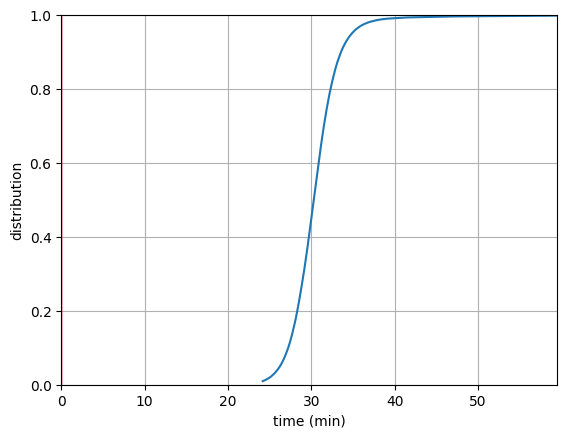

In [ ]:
#@title 2 clipped

plt.figure()


plt.xlabel('time (min)')

plt.ylabel('distribution')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 1]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 1]['CO2 (mln/min) OUT']
                                                                                                                                /AxDisRawOUT[AxDisRawOUT['groups'] == 1]['CO2 (mln/min) OUT'].max())

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 1]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0, top=1)
plt.xlim(left = 0,right = AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[-15] - AxDisRawIN[AxDisRawIN['groups'] == 1]['Dauer (min)'].iat[0])

(0.0, 83.82499999999997)

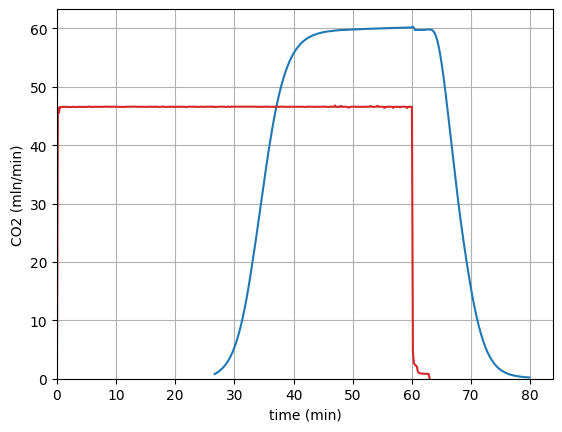

In [ ]:
#@title 3 full

plt.figure()

plt.xlabel('time (min)')

plt.ylabel('CO2 (mln/min)')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 2]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 2]['CO2 (mln/min) OUT'])

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 2]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0)
plt.xlim(left=0)

(0.0, 59.833333333333314)

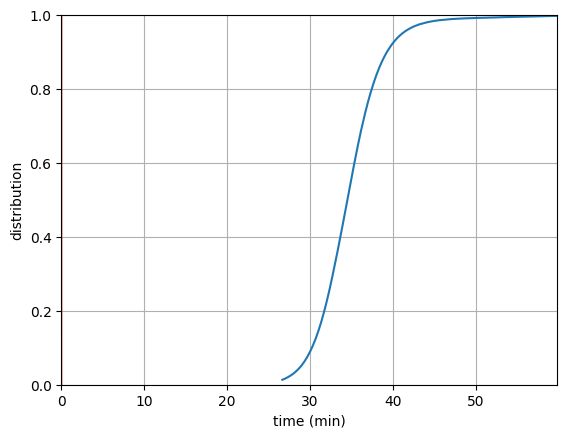

In [ ]:
#@title 3 clipped

plt.figure()

plt.xlabel('time (min)')

plt.ylabel('distribution')

plt.plot(AxDisRawOUT[AxDisRawOUT['groups'] == 2]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[0], AxDisRawOUT[AxDisRawOUT['groups'] == 2]['CO2 (mln/min) OUT']
                                                                                                                                /AxDisRawOUT[AxDisRawOUT['groups'] == 2]['CO2 (mln/min) OUT'].max())

color = 'tab:red'
ax2.set_ylabel('MFC CO2 (mln/min)', color=color)  # we already handled the x-label with ax1

plt.plot(AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'] - AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[0], AxDisRawIN[AxDisRawIN['groups'] == 2]['MFC CO2 (mln/min)'], color=color)

plt.grid()
plt.ylim(bottom=0, top=1)
plt.xlim(left = 0, right = AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[-20] - AxDisRawIN[AxDisRawIN['groups'] == 2]['Dauer (min)'].iat[0])